In [1]:
# 1. 표준 라이브러리
import sys
from pathlib import Path
import platform
import json
import os
import joblib
from datetime import datetime
import warnings
import logging

# 2. 서드파티 라이브러리 
import numpy as np
import pandas as pd

# 2-1. 시각화
import plotly.express as px

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
import seaborn as sns

# 2-2. 
import optuna
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


sys.path.append(str(Path.cwd().parent))
from utils import DATA_DIR, MODEL_DIR, REPORT_DIR

IMG_DIR = REPORT_DIR / 'figures'

In [2]:
# 한글 폰트 설정
if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif platform.system() == 'Darwin':  # macOS
    plt.rcParams['font.family'] = 'AppleGothic'
else:  # Linux
    plt.rcParams['font.family'] = 'NanumGothic'

plt.rcParams['axes.unicode_minus'] = False

mpl.rcParams['axes.unicode_minus'] = False
# 폰트 개인 경로에 맞춰서 변경
# FONT_DIR = Path("/path/to/fonts")
# font_path = FONT_DIR / 'FREESENTATION-6SEMIBOLD.ttf'
# prop = fm.FontProperties(fname=font_path)

In [3]:
pandas_kwargs = {
    'parse_dates': ['검정일자'],
    'date_format': '%Y-%m-%d'
}

milk: pd.DataFrame = pd.read_csv(DATA_DIR /'interim' / 'milk.csv', **pandas_kwargs)
milk.head()

,농장아이디,개체번호,검정일자,누적착유일(연계),무지고형분,MUN,305일유량,305일무지고형분,전산차비유지속성,전산차건유전유량,...,농장구분,정액코드분류,가격,가격미달,가격구분,분만간격,분만월령,공태일수_log,계절_sin,비유단계_sin
0,20249,20120709020022,2020-01-11,154,0,1,9714.0,805.0,50.5,16.1,...,1,NaN,1056.34,0,1,NaN,85,NaN,-2.449294e-16,1.000000e+00
1,20249,20120504020095,2020-01-11,52,0,1,NaN,NaN,68.8,22.6,...,1,NaN,1056.34,0,1,NaN,90,NaN,-2.449294e-16,1.000000e+00
2,20249,20111008020210,2020-01-11,115,0,1,11008.0,971.0,54.1,24.5,...,1,NaN,1060.34,0,1,NaN,95,NaN,-2.449294e-16,1.224647e-16
3,20249,20121014020049,2020-01-11,290,1,1,11318.0,1011.0,58.6,37.8,...,1,7HO,1062.31,0,1,NaN,77,5.4161,-2.449294e-16,-1.000000e+00
4,20249,20130812020216,2020-01-11,100,0,1,11324.0,957.0,68.1,20.5,...,1,NaN,1056.34,0,1,NaN,75,NaN,-2.449294e-16,1.224647e-16


In [4]:
df = milk[milk['가격미달'] == 0]
df.shape

(35956, 26)

In [5]:
features = [
    '전산차건유전유량', 
    '산차', 
    '농후사료급여량(연계)', 
    '공태일수', 
    '계절', 
    '농장구분', 
    '분만간격',
    # '정액코드분류'
]

target = '가격'

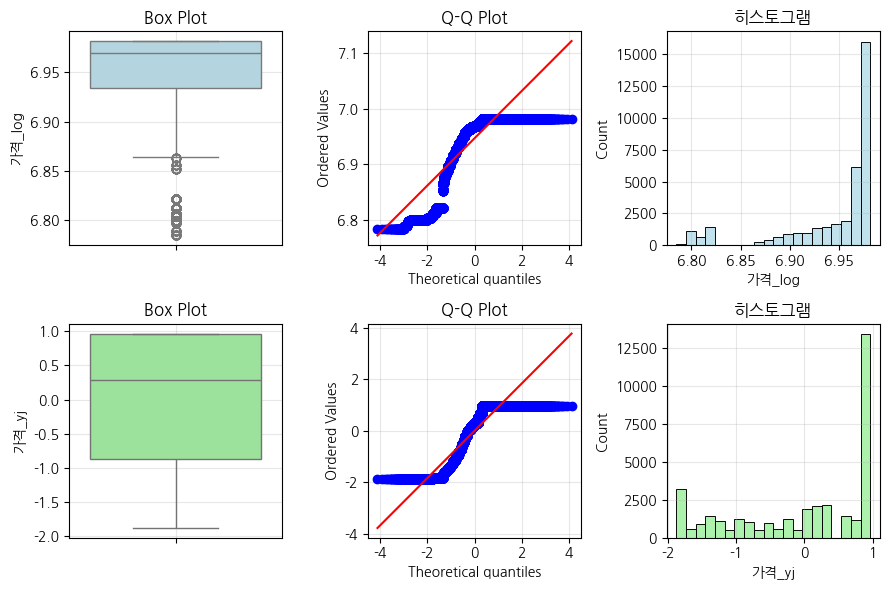

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PowerTransformer

def make_target_transforms(df: pd.DataFrame, target: str,
                           do_clip: bool = True,
                           clip_iqr_factor: float = 1.5):
    """
    df에 타깃 변환 컬럼들을 추가한다.
    생성되는 컬럼:
      1) {target}_clipped   : IQR 기준으로 양끝 클리핑한 값
      2) {target}_log       : log1p 적용
      3) {target}_yj        : Yeo-Johnson 변환 (sklearn PowerTransformer)

    주의:
    - Yeo-Johnson은 fit이 필요하므로 여기서 전체 df로 fit한다.
      학습 시에는 train으로만 다시 fit해서 쓰는 게 더 정석이다.
    """
    # 0. 원본 복사 느낌으로 진행
    df = df.copy()

    base_series = df[target].astype(float)

    # 1. (옵션) IQR 기반 클리핑
    if do_clip:
        q1, q3 = np.percentile(base_series, [25, 75])
        iqr = q3 - q1
        lower = q1 - clip_iqr_factor * iqr
        upper = q3 + clip_iqr_factor * iqr
        clipped = np.clip(base_series, lower, upper)
        df[f"{target}_clipped"] = clipped
    else:
        clipped = base_series  # 아래 단계에서 그대로 사용

    # 2. 지수 변환
    df[f"{target}_exp"] = np.expm1(clipped)

    # 3. Yeo-Johnson 변환
    pt = PowerTransformer(method="yeo-johnson")  # 음수도 처리 가능
    yj_vals = pt.fit_transform(clipped.values.reshape(-1, 1))
    df[f"{target}_yj"] = yj_vals

    # 변환기 돌려주면 train/test 나눈 뒤에 train으로 다시 fit해서 쓸 수 있음
    return df, pt


# 사용 예시
target = "가격"  # 예시
df, pt_target = make_target_transforms(df, target=target, do_clip=False)

# 기존처럼 시각화
from utils import plot_features

plot_features(
    df,
    [f"{target}_exp", f"{target}_yj"],
    ['lightblue', 'lightgreen'],
    bins=20
)


In [7]:
warnings.filterwarnings('ignore')

# ============================================
# 0. 저장 디렉토리 및 타임스탬프 설정
# ============================================

# 현재 시각 측정 (모든 파일에 동일하게 사용)
TIMESTAMP = datetime.now().strftime('%Y%m%d_%H%M%S')

# 모든 파일 경로 미리 정의
PATHS = {
    'log': MODEL_DIR / f'optuna_xgboost_{TIMESTAMP}.log',
    'db': f'sqlite:///{MODEL_DIR / f"optuna_xgboost_{TIMESTAMP}.db"}',
    'intermediate': MODEL_DIR / f'intermediate_results_{TIMESTAMP}.json',
    'best_params': MODEL_DIR / f'best_params_{TIMESTAMP}.json',
    'all_trials': MODEL_DIR / f'all_trials_{TIMESTAMP}.csv',
    'test_results': MODEL_DIR / f'test_results_{TIMESTAMP}.json',
    'predictions': MODEL_DIR / f'test_predictions_{TIMESTAMP}.csv',
    'feature_importance': MODEL_DIR / f'feature_importance_{TIMESTAMP}.csv',
    'final_model': MODEL_DIR / f'xgboost_final_model_{TIMESTAMP}.pkl',
    'final_report': MODEL_DIR / f'final_report_{TIMESTAMP}.txt',
    # 시각화 파일들
    'viz_history': IMG_DIR / f'optuna_optimization_history_{TIMESTAMP}.html',
    'viz_importance': IMG_DIR / f'optuna_param_importances_{TIMESTAMP}.html',
    'viz_contour': IMG_DIR / f'optuna_contour_{TIMESTAMP}.html',
    'viz_parallel': IMG_DIR / f'optuna_parallel_coordinate_{TIMESTAMP}.html',
    'viz_slice': IMG_DIR / f'optuna_slice_{TIMESTAMP}.html',
}

In [8]:
# ============================================
# 1. 로깅 설정
# ============================================
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(PATHS['log']),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

logger.info(f"📁 저장 디렉토리: {MODEL_DIR.absolute()}")
logger.info(f"⏰ 타임스탬프: {TIMESTAMP}")

# ============================================
# 2-1. 데이터 준비 (분포 분석 추가)
# ============================================
logger.info("📁 데이터 로딩 중...")

split_date = '2021-08-01'
train = df[df['검정일자'] < split_date]
test = df[df['검정일자'] >= split_date]

X_train, X_test = train[features], test[features]
y_train, y_test = train[target], test[target]

logger.info(f"  훈련 데이터: {X_train.shape}")
logger.info(f"  테스트 데이터: {X_test.shape}")

# ✅ 타겟 분포 비교
logger.info(f"\n📊 타겟 변수 분포 분석:")
logger.info(f"  훈련 세트 - 평균: {y_train.mean():.4f}, 표준편차: {y_train.std():.4f}")
logger.info(f"  테스트 세트 - 평균: {y_test.mean():.4f}, 표준편차: {y_test.std():.4f}")

# 분포 변화율
mean_shift = abs(y_test.mean() - y_train.mean()) / y_train.mean() * 100
logger.info(f"  평균 변화율: {mean_shift:.2f}%")

if mean_shift > 10:
    logger.warning(f"  ⚠️  타겟 분포가 {mean_shift:.1f}% 변화 → Concept Drift 의심")
    logger.warning("  → 시계열 교차검증(TimeSeriesSplit) 고려 또는 최근 데이터 가중치 증가")
    

2025-11-09 18:10:19,025 - INFO - 📁 저장 디렉토리: /home/dataiku/eric/Sparta/Smart-Farm-Growth-Analytics/models
2025-11-09 18:10:19,026 - INFO - ⏰ 타임스탬프: 20251109_181019
2025-11-09 18:10:19,026 - INFO - 📁 데이터 로딩 중...
2025-11-09 18:10:19,031 - INFO -   훈련 데이터: (28406, 7)
2025-11-09 18:10:19,032 - INFO -   테스트 데이터: (7550, 7)
2025-11-09 18:10:19,032 - INFO - 
📊 타겟 변수 분포 분석:
2025-11-09 18:10:19,033 - INFO -   훈련 세트 - 평균: 1040.6667, 표준편차: 49.9016
2025-11-09 18:10:19,033 - INFO -   테스트 세트 - 평균: 1039.3592, 표준편차: 52.0264
2025-11-09 18:10:19,033 - INFO -   평균 변화율: 0.13%


In [9]:
# ============================================
# 2. 멀티 GPU 설정
# ============================================
AVAILABLE_GPUS = [0, 1, 2, 3]  # 당신의 GPU 개수에 맞게 수정
NUM_GPUS = len(AVAILABLE_GPUS)

logger.info(f"🎮 사용 가능한 GPU: {AVAILABLE_GPUS}")

def get_gpu_device(trial_number):
    """Trial 번호에 따라 GPU 디바이스 문자열 반환 (라운드 로빈 방식)"""
    gpu_id = AVAILABLE_GPUS[trial_number % NUM_GPUS]
    return f'cuda:{gpu_id}'

# ============================================
# 3. 데이터 준비
# ============================================
logger.info("📁 데이터 로딩 중...")

split_date = '2021-08-01'
train = df[df['검정일자'] < split_date]
test = df[df['검정일자'] >= split_date]

X_train, X_test = train[features], test[features]
y_train, y_test = train[target], test[target]

logger.info(f"  훈련 데이터: {X_train.shape}")
logger.info(f"  테스트 데이터: {X_test.shape}")

# ============================================
# 4. 중간 결과 저장 함수 (optimize 전에 정의 필요)
# ============================================
def save_intermediate_results(study, trial):
    """10번마다 중간 결과 저장"""
    logger.info(f"\n💾 중간 저장 (Trial {trial.number})")
    
    intermediate_results = {
        'timestamp': TIMESTAMP,
        'saved_at': datetime.now().isoformat(),
        'trial_number': trial.number,
        'best_value': study.best_value,
        'best_params': study.best_params,
        'n_trials': len(study.trials)
    }
    
    with open(PATHS['intermediate'], 'w') as f:
        json.dump(intermediate_results, f, indent=2)

# ============================================
# 5. Objective 함수 (멀티 GPU 버전)
# ============================================
def objective(trial):
    """
    Optuna 목적 함수 - 과소적합 해결 버전
    """
    device = get_gpu_device(trial.number)
    logger.info(f"Trial {trial.number}: {device} 사용")
    
    params = {
        # ========== 모델 복잡도 증가 ==========
        'max_depth': trial.suggest_int('max_depth', 6, 15),  # ✅ 6~15 (기존 3~12)
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),  # ✅ 1~5 (기존 1~10, 낮을수록 복잡)
        'gamma': trial.suggest_float('gamma', 0, 2),  # ✅ 0~2 (기존 0~5, 낮을수록 복잡)
        
        # ========== 학습 속도 & 반복 증가 ==========
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),  # ✅ 0.01~0.3
        'n_estimators': trial.suggest_int('n_estimators', 200, 1500, step=50),  # ✅ 200~1500 (기존 100~1000)
        
        # ========== 샘플링 증가 (더 많은 데이터 사용) ==========
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),  # ✅ 0.7~1.0 (기존 0.5~1.0)
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),  # ✅ 0.7~1.0
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.7, 1.0),  # ✅ 0.7~1.0
        
        # ========== 정규화 감소 (과소적합이므로 규제 완화) ==========
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),  # ✅ 0~1 (기존 0~10)
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),  # ✅ 0~1 (기존 0~10)
        
        'device': device,
        'tree_method': 'hist',
        'random_state': 42,
        'verbosity': 0
    }
    
    try:
        model = XGBRegressor(**params)
        
        cv_scores = cross_val_score(
            model, X_train, y_train,
            cv=5,
            scoring='neg_mean_squared_error',
            n_jobs=5
        )
        
        mean_mse = -cv_scores.mean()
        
        trial.set_user_attr('cv_std', cv_scores.std())
        trial.set_user_attr('cv_scores', cv_scores.tolist())
        trial.set_user_attr('device', device)
        
        return mean_mse
        
    except Exception as e:
        logger.error(f"Trial {trial.number} 실패: {str(e)}")
        raise optuna.exceptions.TrialPruned()

# ============================================
# 6. Optuna Study 생성 (DB 저장)
# ============================================
STUDY_NAME = f'xgboost_regression_{TIMESTAMP}'

logger.info(f"🗄️  데이터베이스: {PATHS['db']}")
logger.info(f"📚 Study 이름: {STUDY_NAME}")

# Study 생성 또는 불러오기
study = optuna.create_study(
    study_name=STUDY_NAME,
    storage=PATHS['db'],
    load_if_exists=True,
    direction='minimize',
    sampler=optuna.samplers.TPESampler(
        seed=42,
        n_startup_trials=20,
        multivariate=True
    ),
    pruner=optuna.pruners.MedianPruner(
        n_startup_trials=10,
        n_warmup_steps=5
    )
)

# 이전 실행 정보 출력
if len(study.trials) > 0:
    logger.info(f"✅ 이전 실행 발견: {len(study.trials)}개 trials")
    logger.info(f"   현재 최적 MSE: {study.best_value:.4f}")

# ============================================
# 7. 최적화 실행
# ============================================
N_TRIALS = 300
TIMEOUT = None

logger.info("\n" + "="*60)
logger.info("🚀 Optuna 최적화 시작!")
logger.info(f"   목표 Trials: {N_TRIALS}")
logger.info(f"   멀티 GPU: {NUM_GPUS}개")
logger.info("="*60 + "\n")

study.optimize(
    objective,
    n_trials=N_TRIALS,
    timeout=TIMEOUT,
    n_jobs=1,
    show_progress_bar=True,
    callbacks=[
        lambda study, trial: save_intermediate_results(study, trial) 
        if trial.number % 10 == 0 else None
    ]
)

2025-11-09 18:10:19,041 - INFO - 🎮 사용 가능한 GPU: [0, 1, 2, 3]
2025-11-09 18:10:19,041 - INFO - 📁 데이터 로딩 중...
2025-11-09 18:10:19,046 - INFO -   훈련 데이터: (28406, 7)
2025-11-09 18:10:19,046 - INFO -   테스트 데이터: (7550, 7)
2025-11-09 18:10:19,047 - INFO - 🗄️  데이터베이스: sqlite:////home/dataiku/eric/Sparta/Smart-Farm-Growth-Analytics/models/optuna_xgboost_20251109_181019.db
2025-11-09 18:10:19,047 - INFO - 📚 Study 이름: xgboost_regression_20251109_181019
[I 2025-11-09 18:10:19,429] A new study created in RDB with name: xgboost_regression_20251109_181019
2025-11-09 18:10:19,433 - INFO - 
2025-11-09 18:10:19,433 - INFO - 🚀 Optuna 최적화 시작!
2025-11-09 18:10:19,434 - INFO -    목표 Trials: 300
2025-11-09 18:10:19,434 - INFO -    멀티 GPU: 4개
2025-11-09 18:10:19,434 - INFO - ============================================================



  0%|          | 0/300 [00:00<?, ?it/s]

2025-11-09 18:10:19,457 - INFO - Trial 0: cuda:0 사용
2025-11-09 18:10:23,941 - INFO - 
💾 중간 저장 (Trial 0)
2025-11-09 18:10:23,964 - INFO - Trial 1: cuda:1 사용


[I 2025-11-09 18:10:23,939] Trial 0 finished with value: 2228.54850685867 and parameters: {'max_depth': 9, 'min_child_weight': 5, 'gamma': 1.4639878836228102, 'learning_rate': 0.07661100707771368, 'n_estimators': 400, 'subsample': 0.7467983561008608, 'colsample_bytree': 0.7174250836504598, 'colsample_bylevel': 0.9598528437324805, 'reg_alpha': 0.0006440507553993703, 'reg_lambda': 0.004619347374377372}. Best is trial 0 with value: 2228.54850685867.


2025-11-09 18:10:26,573 - INFO - Trial 2: cuda:2 사용


[I 2025-11-09 18:10:26,552] Trial 1 finished with value: 2055.084989451464 and parameters: {'max_depth': 6, 'min_child_weight': 5, 'gamma': 1.6648852816008435, 'learning_rate': 0.020589728197687916, 'n_estimators': 400, 'subsample': 0.7550213529560301, 'colsample_bytree': 0.7912726728878613, 'colsample_bylevel': 0.8574269294896714, 'reg_alpha': 2.85469785779718e-05, 'reg_lambda': 2.1371407316372935e-06}. Best is trial 1 with value: 2055.084989451464.


2025-11-09 18:10:47,174 - INFO - Trial 3: cuda:3 사용


[I 2025-11-09 18:10:47,154] Trial 2 finished with value: 2330.750298968508 and parameters: {'max_depth': 12, 'min_child_weight': 1, 'gamma': 0.5842892970704363, 'learning_rate': 0.03476649150592621, 'n_estimators': 800, 'subsample': 0.935552788417904, 'colsample_bytree': 0.7599021346475079, 'colsample_bylevel': 0.8542703315240835, 'reg_alpha': 0.0005486767416600901, 'reg_lambda': 2.3528990899815284e-08}. Best is trial 1 with value: 2055.084989451464.


2025-11-09 18:11:22,510 - INFO - Trial 4: cuda:0 사용


[I 2025-11-09 18:11:22,491] Trial 3 finished with value: 2998.6844117038418 and parameters: {'max_depth': 12, 'min_child_weight': 1, 'gamma': 0.13010318597055903, 'learning_rate': 0.2521267904777921, 'n_estimators': 1500, 'subsample': 0.9425192044349383, 'colsample_bytree': 0.7913841307520112, 'colsample_bylevel': 0.7293016342019151, 'reg_alpha': 0.0029775853025212607, 'reg_lambda': 3.320625892007924e-05}. Best is trial 1 with value: 2055.084989451464.


2025-11-09 18:11:26,383 - INFO - Trial 5: cuda:1 사용


[I 2025-11-09 18:11:26,363] Trial 4 finished with value: 2395.257080927591 and parameters: {'max_depth': 7, 'min_child_weight': 3, 'gamma': 0.06877704223043679, 'learning_rate': 0.22038218939289875, 'n_estimators': 500, 'subsample': 0.8987566853061946, 'colsample_bytree': 0.7935133228268233, 'colsample_bylevel': 0.8560204063533432, 'reg_alpha': 0.00023641892308789696, 'reg_lambda': 3.0118659882617117e-07}. Best is trial 1 with value: 2055.084989451464.


2025-11-09 18:11:51,685 - INFO - Trial 6: cuda:2 사용


[I 2025-11-09 18:11:51,665] Trial 5 finished with value: 2551.26570870641 and parameters: {'max_depth': 15, 'min_child_weight': 4, 'gamma': 1.8789978831283782, 'learning_rate': 0.20978213384576816, 'n_estimators': 1000, 'subsample': 0.976562270506935, 'colsample_bytree': 0.7265477506155759, 'colsample_bylevel': 0.7587948587257435, 'reg_alpha': 2.300479202014574e-08, 'reg_lambda': 4.005370050283172e-06}. Best is trial 1 with value: 2055.084989451464.


2025-11-09 18:11:57,824 - INFO - Trial 7: cuda:3 사용


[I 2025-11-09 18:11:57,805] Trial 6 finished with value: 2135.6506248920746 and parameters: {'max_depth': 9, 'min_child_weight': 2, 'gamma': 1.6574750183038587, 'learning_rate': 0.03364867144187954, 'n_estimators': 550, 'subsample': 0.8628088249474746, 'colsample_bytree': 0.7422772674924287, 'colsample_bylevel': 0.9406590942262119, 'reg_alpha': 3.9482545946332394e-08, 'reg_lambda': 0.7854083114461319}. Best is trial 1 with value: 2055.084989451464.


2025-11-09 18:12:36,337 - INFO - Trial 8: cuda:0 사용


[I 2025-11-09 18:12:36,318] Trial 7 finished with value: 2696.3372516386407 and parameters: {'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.011044234247204798, 'learning_rate': 0.1601531217136121, 'n_estimators': 1150, 'subsample': 0.9187021504122962, 'colsample_bytree': 0.9313811040057838, 'colsample_bylevel': 0.7222133955202271, 'reg_alpha': 7.374385355858303e-06, 'reg_lambda': 8.451863533931625e-08}. Best is trial 1 with value: 2055.084989451464.


2025-11-09 18:12:54,843 - INFO - Trial 9: cuda:1 사용


[I 2025-11-09 18:12:54,823] Trial 8 finished with value: 2181.3575991252374 and parameters: {'max_depth': 14, 'min_child_weight': 4, 'gamma': 0.6617960497052984, 'learning_rate': 0.012413189635294229, 'n_estimators': 600, 'subsample': 0.7975549966080241, 'colsample_bytree': 0.9188818535014192, 'colsample_bylevel': 0.8912672414065639, 'reg_alpha': 0.12522814303053625, 'reg_lambda': 5.994036749692399e-05}. Best is trial 1 with value: 2055.084989451464.


2025-11-09 18:13:03,048 - INFO - Trial 10: cuda:2 사용


[I 2025-11-09 18:13:03,028] Trial 9 finished with value: 2261.767164593334 and parameters: {'max_depth': 7, 'min_child_weight': 4, 'gamma': 1.5215700972337949, 'learning_rate': 0.06746437142284309, 'n_estimators': 1200, 'subsample': 0.8481386789093173, 'colsample_bytree': 0.8568198488145982, 'colsample_bylevel': 0.8282623055075649, 'reg_alpha': 1.5971768764426203e-08, 'reg_lambda': 7.296782748701773e-08}. Best is trial 1 with value: 2055.084989451464.


2025-11-09 18:13:10,675 - INFO - 
💾 중간 저장 (Trial 10)
2025-11-09 18:13:10,698 - INFO - Trial 11: cuda:3 사용


[I 2025-11-09 18:13:10,674] Trial 10 finished with value: 2204.8557058584056 and parameters: {'max_depth': 6, 'min_child_weight': 4, 'gamma': 0.6287119621526533, 'learning_rate': 0.056392399916675585, 'n_estimators': 1400, 'subsample': 0.7747876687446624, 'colsample_bytree': 0.8231148769106889, 'colsample_bylevel': 0.9266653415629146, 'reg_alpha': 6.76683090208453e-07, 'reg_lambda': 4.128946718697511e-08}. Best is trial 1 with value: 2055.084989451464.


2025-11-09 18:13:19,882 - INFO - Trial 12: cuda:0 사용


[I 2025-11-09 18:13:19,862] Trial 11 finished with value: 2492.334571247764 and parameters: {'max_depth': 8, 'min_child_weight': 1, 'gamma': 1.8593953046851461, 'learning_rate': 0.156203869845265, 'n_estimators': 1050, 'subsample': 0.9614381770563153, 'colsample_bytree': 0.9411016230697343, 'colsample_bylevel': 0.7559710176658108, 'reg_alpha': 0.13818852711527843, 'reg_lambda': 0.00020641342272342887}. Best is trial 1 with value: 2055.084989451464.


2025-11-09 18:13:33,885 - INFO - Trial 13: cuda:1 사용


[I 2025-11-09 18:13:33,865] Trial 12 finished with value: 2170.3342154963043 and parameters: {'max_depth': 14, 'min_child_weight': 5, 'gamma': 0.6360069499437278, 'learning_rate': 0.014539853705640319, 'n_estimators': 500, 'subsample': 0.8281323365878769, 'colsample_bytree': 0.9454044297767479, 'colsample_bylevel': 0.958219174976903, 'reg_alpha': 1.1366245816554797e-08, 'reg_lambda': 0.0001218929030838671}. Best is trial 1 with value: 2055.084989451464.


2025-11-09 18:13:54,508 - INFO - Trial 14: cuda:2 사용


[I 2025-11-09 18:13:54,489] Trial 13 finished with value: 2303.150775358522 and parameters: {'max_depth': 10, 'min_child_weight': 2, 'gamma': 0.2397307346673656, 'learning_rate': 0.0315281541750961, 'n_estimators': 1450, 'subsample': 0.7969608796062265, 'colsample_bytree': 0.8556371865230098, 'colsample_bylevel': 0.9109056876685533, 'reg_alpha': 8.110298132030929e-06, 'reg_lambda': 0.5946434805027183}. Best is trial 1 with value: 2055.084989451464.


2025-11-09 18:14:20,035 - INFO - Trial 15: cuda:3 사용


[I 2025-11-09 18:14:20,016] Trial 14 finished with value: 2333.993406944475 and parameters: {'max_depth': 15, 'min_child_weight': 2, 'gamma': 0.9944970117847709, 'learning_rate': 0.027824908605603306, 'n_estimators': 550, 'subsample': 0.7110660842063597, 'colsample_bytree': 0.882869300193969, 'colsample_bylevel': 0.8508037069686585, 'reg_alpha': 2.5812496493273626e-08, 'reg_lambda': 1.695007850094144e-06}. Best is trial 1 with value: 2055.084989451464.


2025-11-09 18:15:27,060 - INFO - Trial 16: cuda:0 사용


[I 2025-11-09 18:15:27,033] Trial 15 finished with value: 2462.608900794123 and parameters: {'max_depth': 15, 'min_child_weight': 2, 'gamma': 0.2897897441824462, 'learning_rate': 0.052842222499425995, 'n_estimators': 1500, 'subsample': 0.7726165814534501, 'colsample_bytree': 0.9016406642217636, 'colsample_bylevel': 0.9284858845986153, 'reg_alpha': 7.963433393223581e-07, 'reg_lambda': 0.0066946948903108105}. Best is trial 1 with value: 2055.084989451464.


2025-11-09 18:15:30,665 - INFO - Trial 17: cuda:1 사용


[I 2025-11-09 18:15:30,645] Trial 16 finished with value: 2132.729828093832 and parameters: {'max_depth': 9, 'min_child_weight': 4, 'gamma': 1.2670594215217894, 'learning_rate': 0.06185918211556436, 'n_estimators': 300, 'subsample': 0.9505907486767714, 'colsample_bytree': 0.7962340194915207, 'colsample_bylevel': 0.7559555531199562, 'reg_alpha': 2.1193424275165945e-08, 'reg_lambda': 0.0005335112055356552}. Best is trial 1 with value: 2055.084989451464.


2025-11-09 18:15:57,656 - INFO - Trial 18: cuda:2 사용


[I 2025-11-09 18:15:57,636] Trial 17 finished with value: 2308.4348120789045 and parameters: {'max_depth': 12, 'min_child_weight': 1, 'gamma': 1.024186116598562, 'learning_rate': 0.02160537077027906, 'n_estimators': 1050, 'subsample': 0.7523099287014974, 'colsample_bytree': 0.9072813214307398, 'colsample_bylevel': 0.8160206038901612, 'reg_alpha': 0.31177401074836186, 'reg_lambda': 1.2594112057549154e-07}. Best is trial 1 with value: 2055.084989451464.


2025-11-09 18:16:03,429 - INFO - Trial 19: cuda:3 사용


[I 2025-11-09 18:16:03,410] Trial 18 finished with value: 2553.681301028156 and parameters: {'max_depth': 9, 'min_child_weight': 1, 'gamma': 1.8493872365571256, 'learning_rate': 0.1976681084946931, 'n_estimators': 500, 'subsample': 0.8979952138102537, 'colsample_bytree': 0.9451666600603648, 'colsample_bylevel': 0.8665602434798387, 'reg_alpha': 0.00017266512478892476, 'reg_lambda': 8.606336591203087e-07}. Best is trial 1 with value: 2055.084989451464.


2025-11-09 18:16:07,321 - INFO - Trial 20: cuda:0 사용


[I 2025-11-09 18:16:07,301] Trial 19 finished with value: 2172.818135490055 and parameters: {'max_depth': 6, 'min_child_weight': 5, 'gamma': 1.800836114326661, 'learning_rate': 0.0861326122761509, 'n_estimators': 650, 'subsample': 0.8047628723837983, 'colsample_bytree': 0.9177867036610718, 'colsample_bylevel': 0.9691330779857732, 'reg_alpha': 0.12493709226103174, 'reg_lambda': 0.017338214313606524}. Best is trial 1 with value: 2055.084989451464.


2025-11-09 18:16:13,170 - INFO - 
💾 중간 저장 (Trial 20)
2025-11-09 18:16:13,194 - INFO - Trial 21: cuda:1 사용


[I 2025-11-09 18:16:13,168] Trial 20 finished with value: 2062.588595541813 and parameters: {'max_depth': 7, 'min_child_weight': 5, 'gamma': 1.636622084635208, 'learning_rate': 0.014066001563609867, 'n_estimators': 850, 'subsample': 0.7857798827080982, 'colsample_bytree': 0.777607662876566, 'colsample_bylevel': 0.8456412486473462, 'reg_alpha': 0.00021642252037251084, 'reg_lambda': 4.39355124210888e-06}. Best is trial 1 with value: 2055.084989451464.


2025-11-09 18:16:18,530 - INFO - Trial 22: cuda:2 사용


[I 2025-11-09 18:16:18,510] Trial 21 finished with value: 2054.864808970143 and parameters: {'max_depth': 7, 'min_child_weight': 5, 'gamma': 1.6563097722215727, 'learning_rate': 0.011380504258821365, 'n_estimators': 750, 'subsample': 0.7147264539961519, 'colsample_bytree': 0.8079389139078039, 'colsample_bylevel': 0.8643826134787415, 'reg_alpha': 2.6687429007838843e-05, 'reg_lambda': 3.7309303933738513e-06}. Best is trial 21 with value: 2054.864808970143.


2025-11-09 18:16:24,081 - INFO - Trial 23: cuda:3 사용


[I 2025-11-09 18:16:24,061] Trial 22 finished with value: 2063.5690158024036 and parameters: {'max_depth': 7, 'min_child_weight': 4, 'gamma': 1.9151346588995313, 'learning_rate': 0.014568017350235492, 'n_estimators': 800, 'subsample': 0.7313945717439642, 'colsample_bytree': 0.831604731049246, 'colsample_bylevel': 0.8544103166198243, 'reg_alpha': 0.0019273671075816996, 'reg_lambda': 8.258620346310898e-05}. Best is trial 21 with value: 2054.864808970143.


2025-11-09 18:16:25,496 - INFO - Trial 24: cuda:0 사용


[I 2025-11-09 18:16:25,475] Trial 23 finished with value: 2061.0505958038443 and parameters: {'max_depth': 6, 'min_child_weight': 5, 'gamma': 1.7018322390987528, 'learning_rate': 0.050854697534136115, 'n_estimators': 200, 'subsample': 0.703881470697256, 'colsample_bytree': 0.7921435622845406, 'colsample_bylevel': 0.8021439899171161, 'reg_alpha': 4.440760916316433e-05, 'reg_lambda': 2.3949864943368784e-06}. Best is trial 21 with value: 2054.864808970143.


2025-11-09 18:16:27,773 - INFO - Trial 25: cuda:1 사용


[I 2025-11-09 18:16:27,754] Trial 24 finished with value: 2128.1629304556454 and parameters: {'max_depth': 7, 'min_child_weight': 4, 'gamma': 1.582595812351858, 'learning_rate': 0.08070021363101072, 'n_estimators': 300, 'subsample': 0.7649631248993749, 'colsample_bytree': 0.8370891236692722, 'colsample_bylevel': 0.8738725950083597, 'reg_alpha': 3.895542476367234e-05, 'reg_lambda': 6.73836171570869e-08}. Best is trial 21 with value: 2054.864808970143.


2025-11-09 18:16:30,463 - INFO - Trial 26: cuda:2 사용


[I 2025-11-09 18:16:30,441] Trial 25 finished with value: 2129.6368915503454 and parameters: {'max_depth': 8, 'min_child_weight': 4, 'gamma': 1.878127704696244, 'learning_rate': 0.06816384747818796, 'n_estimators': 300, 'subsample': 0.756943709417096, 'colsample_bytree': 0.7717782802281825, 'colsample_bylevel': 0.7608320652038619, 'reg_alpha': 6.587249448402227e-05, 'reg_lambda': 0.00022823418088605522}. Best is trial 21 with value: 2054.864808970143.


2025-11-09 18:16:33,390 - INFO - Trial 27: cuda:3 사용


[I 2025-11-09 18:16:33,370] Trial 26 finished with value: 2051.233990059853 and parameters: {'max_depth': 6, 'min_child_weight': 5, 'gamma': 1.1289325096165104, 'learning_rate': 0.014900142741412195, 'n_estimators': 500, 'subsample': 0.7116454362673358, 'colsample_bytree': 0.7379959821771569, 'colsample_bylevel': 0.8585550615228867, 'reg_alpha': 1.5660542126266622e-07, 'reg_lambda': 5.675628704754713e-07}. Best is trial 26 with value: 2051.233990059853.


2025-11-09 18:16:37,736 - INFO - Trial 28: cuda:0 사용


[I 2025-11-09 18:16:37,717] Trial 27 finished with value: 2065.668009039865 and parameters: {'max_depth': 7, 'min_child_weight': 4, 'gamma': 1.0068162677761316, 'learning_rate': 0.022893124551170364, 'n_estimators': 600, 'subsample': 0.7614371155417923, 'colsample_bytree': 0.7638175251094561, 'colsample_bylevel': 0.9301036407479077, 'reg_alpha': 2.19849047430878e-07, 'reg_lambda': 0.0003056115606459039}. Best is trial 26 with value: 2051.233990059853.


2025-11-09 18:16:39,301 - INFO - Trial 29: cuda:1 사용


[I 2025-11-09 18:16:39,281] Trial 28 finished with value: 2070.740263390473 and parameters: {'max_depth': 6, 'min_child_weight': 4, 'gamma': 1.1687883724067403, 'learning_rate': 0.011432384124379545, 'n_estimators': 200, 'subsample': 0.7107458471433858, 'colsample_bytree': 0.7275122252533412, 'colsample_bylevel': 0.8329628769429174, 'reg_alpha': 2.5685849236884136e-07, 'reg_lambda': 2.7530298832263215e-08}. Best is trial 26 with value: 2051.233990059853.


2025-11-09 18:16:44,820 - INFO - Trial 30: cuda:2 사용


[I 2025-11-09 18:16:44,800] Trial 29 finished with value: 2076.9938678419558 and parameters: {'max_depth': 10, 'min_child_weight': 5, 'gamma': 0.91419305423218, 'learning_rate': 0.012217500189894691, 'n_estimators': 400, 'subsample': 0.7654062628646671, 'colsample_bytree': 0.8673773733936813, 'colsample_bylevel': 0.846879486072391, 'reg_alpha': 0.00015953020122909677, 'reg_lambda': 1.1256101296268736e-08}. Best is trial 26 with value: 2051.233990059853.


2025-11-09 18:16:49,042 - INFO - 
💾 중간 저장 (Trial 30)
2025-11-09 18:16:49,066 - INFO - Trial 31: cuda:3 사용


[I 2025-11-09 18:16:49,040] Trial 30 finished with value: 2053.7699175436755 and parameters: {'max_depth': 6, 'min_child_weight': 5, 'gamma': 0.34884688935313, 'learning_rate': 0.012112954318738286, 'n_estimators': 750, 'subsample': 0.736272334006325, 'colsample_bytree': 0.7604134474537811, 'colsample_bylevel': 0.8424179698569457, 'reg_alpha': 1.794131557267342e-07, 'reg_lambda': 2.0988195115416605e-06}. Best is trial 26 with value: 2051.233990059853.


2025-11-09 18:16:53,546 - INFO - Trial 32: cuda:0 사용


[I 2025-11-09 18:16:53,527] Trial 31 finished with value: 2054.7004072101136 and parameters: {'max_depth': 6, 'min_child_weight': 5, 'gamma': 0.4293184575674406, 'learning_rate': 0.013227462701924018, 'n_estimators': 800, 'subsample': 0.7708621378395984, 'colsample_bytree': 0.8736167367509721, 'colsample_bylevel': 0.7511577219227069, 'reg_alpha': 1.0917829845185175e-08, 'reg_lambda': 5.244315761498941e-05}. Best is trial 26 with value: 2051.233990059853.


2025-11-09 18:16:58,320 - INFO - Trial 33: cuda:1 사용


[I 2025-11-09 18:16:58,301] Trial 32 finished with value: 2057.341819029743 and parameters: {'max_depth': 6, 'min_child_weight': 4, 'gamma': 0.516494179875255, 'learning_rate': 0.016635322450055876, 'n_estimators': 850, 'subsample': 0.766468920936395, 'colsample_bytree': 0.9039654574986364, 'colsample_bylevel': 0.7465580597019097, 'reg_alpha': 3.140076005580945e-07, 'reg_lambda': 5.346277738324217e-06}. Best is trial 26 with value: 2051.233990059853.


2025-11-09 18:17:02,227 - INFO - Trial 34: cuda:2 사용


[I 2025-11-09 18:17:02,208] Trial 33 finished with value: 2058.860495228519 and parameters: {'max_depth': 7, 'min_child_weight': 5, 'gamma': 0.06875180756372284, 'learning_rate': 0.013379410609260324, 'n_estimators': 550, 'subsample': 0.7412104109535713, 'colsample_bytree': 0.7809200416580836, 'colsample_bylevel': 0.7882901100467625, 'reg_alpha': 1.0265774531501162e-06, 'reg_lambda': 1.5238506003834066e-07}. Best is trial 26 with value: 2051.233990059853.


2025-11-09 18:17:13,856 - INFO - Trial 35: cuda:3 사용


[I 2025-11-09 18:17:13,836] Trial 34 finished with value: 2107.472392458534 and parameters: {'max_depth': 9, 'min_child_weight': 4, 'gamma': 0.205789586779345, 'learning_rate': 0.012789890513500558, 'n_estimators': 1100, 'subsample': 0.7062139796468931, 'colsample_bytree': 0.7813316785551295, 'colsample_bylevel': 0.8802262052969031, 'reg_alpha': 1.444644588258757e-08, 'reg_lambda': 5.545431568212623e-07}. Best is trial 26 with value: 2051.233990059853.


2025-11-09 18:17:18,567 - INFO - Trial 36: cuda:0 사용


[I 2025-11-09 18:17:18,548] Trial 35 finished with value: 2066.233450034803 and parameters: {'max_depth': 6, 'min_child_weight': 4, 'gamma': 1.4949488393983312, 'learning_rate': 0.020554571586605536, 'n_estimators': 850, 'subsample': 0.7033690770234298, 'colsample_bytree': 0.7750400446474913, 'colsample_bylevel': 0.8681545165472287, 'reg_alpha': 1.0761964469414722e-07, 'reg_lambda': 9.118410911918588e-07}. Best is trial 26 with value: 2051.233990059853.


2025-11-09 18:17:20,948 - INFO - Trial 37: cuda:1 사용


[I 2025-11-09 18:17:20,929] Trial 36 finished with value: 2062.761687480291 and parameters: {'max_depth': 6, 'min_child_weight': 4, 'gamma': 0.1867547992918383, 'learning_rate': 0.038031563778513626, 'n_estimators': 400, 'subsample': 0.7645894877656914, 'colsample_bytree': 0.8699358313665551, 'colsample_bylevel': 0.8573312777336788, 'reg_alpha': 1.1079468889051666e-08, 'reg_lambda': 0.0012691145480308967}. Best is trial 26 with value: 2051.233990059853.


2025-11-09 18:17:28,458 - INFO - Trial 38: cuda:2 사용


[I 2025-11-09 18:17:28,438] Trial 37 finished with value: 2071.7840122800167 and parameters: {'max_depth': 8, 'min_child_weight': 5, 'gamma': 0.6520001108374089, 'learning_rate': 0.012538169419026388, 'n_estimators': 900, 'subsample': 0.7131054478448935, 'colsample_bytree': 0.8112987357873112, 'colsample_bylevel': 0.8330231364354143, 'reg_alpha': 4.68920267486709e-07, 'reg_lambda': 0.014317509604445297}. Best is trial 26 with value: 2051.233990059853.


2025-11-09 18:17:37,201 - INFO - Trial 39: cuda:3 사용


[I 2025-11-09 18:17:37,182] Trial 38 finished with value: 2093.144647120075 and parameters: {'max_depth': 9, 'min_child_weight': 5, 'gamma': 0.08570397448759104, 'learning_rate': 0.012852301662625496, 'n_estimators': 850, 'subsample': 0.9306671453201512, 'colsample_bytree': 0.9284731528432011, 'colsample_bylevel': 0.7339454543339535, 'reg_alpha': 3.5852685400763287e-07, 'reg_lambda': 0.0018163984231432328}. Best is trial 26 with value: 2051.233990059853.


2025-11-09 18:17:40,665 - INFO - Trial 40: cuda:0 사용


[I 2025-11-09 18:17:40,645] Trial 39 finished with value: 2053.633196630538 and parameters: {'max_depth': 6, 'min_child_weight': 5, 'gamma': 0.29823148589224546, 'learning_rate': 0.012751540367493827, 'n_estimators': 600, 'subsample': 0.7151494978696346, 'colsample_bytree': 0.7611145755443245, 'colsample_bylevel': 0.8646217919610317, 'reg_alpha': 1.5127759753684827e-07, 'reg_lambda': 9.250634133774369e-05}. Best is trial 26 with value: 2051.233990059853.


2025-11-09 18:17:44,087 - INFO - 
💾 중간 저장 (Trial 40)
2025-11-09 18:17:44,111 - INFO - Trial 41: cuda:1 사용


[I 2025-11-09 18:17:44,085] Trial 40 finished with value: 2053.5664729131204 and parameters: {'max_depth': 6, 'min_child_weight': 4, 'gamma': 0.14947687068840623, 'learning_rate': 0.018518140466123007, 'n_estimators': 600, 'subsample': 0.7934067767772717, 'colsample_bytree': 0.7745776448334071, 'colsample_bylevel': 0.8326435008685398, 'reg_alpha': 2.2307345656035578e-05, 'reg_lambda': 0.0005673669719716324}. Best is trial 26 with value: 2051.233990059853.


2025-11-09 18:17:48,292 - INFO - Trial 42: cuda:2 사용


[I 2025-11-09 18:17:48,267] Trial 41 finished with value: 2056.201748642699 and parameters: {'max_depth': 6, 'min_child_weight': 4, 'gamma': 0.057339769428094614, 'learning_rate': 0.017230656781635854, 'n_estimators': 700, 'subsample': 0.9014300850949035, 'colsample_bytree': 0.7923979425642625, 'colsample_bylevel': 0.8143503608458602, 'reg_alpha': 0.00011288821438676323, 'reg_lambda': 0.0035359864212002683}. Best is trial 26 with value: 2051.233990059853.


2025-11-09 18:17:53,881 - INFO - Trial 43: cuda:3 사용


[I 2025-11-09 18:17:53,862] Trial 42 finished with value: 2071.6424840895897 and parameters: {'max_depth': 6, 'min_child_weight': 5, 'gamma': 0.22637478654888463, 'learning_rate': 0.020867202634842444, 'n_estimators': 1000, 'subsample': 0.7566232703300273, 'colsample_bytree': 0.8848720365216568, 'colsample_bylevel': 0.732815992258054, 'reg_alpha': 9.562292662915856e-08, 'reg_lambda': 0.002223933754223121}. Best is trial 26 with value: 2051.233990059853.


2025-11-09 18:17:58,849 - INFO - Trial 44: cuda:0 사용


[I 2025-11-09 18:17:58,828] Trial 43 finished with value: 2050.536755230213 and parameters: {'max_depth': 7, 'min_child_weight': 4, 'gamma': 0.09571008024668158, 'learning_rate': 0.010466380921552686, 'n_estimators': 700, 'subsample': 0.7918226432786328, 'colsample_bytree': 0.7690169535951056, 'colsample_bylevel': 0.9088802045935928, 'reg_alpha': 0.0004992735698290027, 'reg_lambda': 0.00020495334725848256}. Best is trial 43 with value: 2050.536755230213.


2025-11-09 18:18:08,046 - INFO - Trial 45: cuda:1 사용


[I 2025-11-09 18:18:08,026] Trial 44 finished with value: 2103.9859412733963 and parameters: {'max_depth': 9, 'min_child_weight': 3, 'gamma': 0.2585522504075559, 'learning_rate': 0.015931116214371915, 'n_estimators': 850, 'subsample': 0.8367374197733904, 'colsample_bytree': 0.7548481760519019, 'colsample_bylevel': 0.9696002771467352, 'reg_alpha': 0.00762597579453028, 'reg_lambda': 6.058060190583296e-05}. Best is trial 43 with value: 2050.536755230213.


2025-11-09 18:18:11,341 - INFO - Trial 46: cuda:2 사용


[I 2025-11-09 18:18:11,321] Trial 45 finished with value: 2067.5711048048447 and parameters: {'max_depth': 8, 'min_child_weight': 5, 'gamma': 0.11802341648060186, 'learning_rate': 0.025589673581478067, 'n_estimators': 350, 'subsample': 0.71012531827281, 'colsample_bytree': 0.7168841564463839, 'colsample_bylevel': 0.9102957957090749, 'reg_alpha': 2.840628841089514e-07, 'reg_lambda': 0.003114639515580456}. Best is trial 43 with value: 2050.536755230213.


2025-11-09 18:18:17,191 - INFO - Trial 47: cuda:3 사용


[I 2025-11-09 18:18:17,172] Trial 46 finished with value: 2085.841232961023 and parameters: {'max_depth': 8, 'min_child_weight': 3, 'gamma': 0.19221466607405815, 'learning_rate': 0.0217250060974636, 'n_estimators': 650, 'subsample': 0.7640374975247429, 'colsample_bytree': 0.7411192070608299, 'colsample_bylevel': 0.7783127489035992, 'reg_alpha': 0.00037127277546664177, 'reg_lambda': 0.0001363161149513625}. Best is trial 43 with value: 2050.536755230213.


2025-11-09 18:18:19,691 - INFO - Trial 48: cuda:0 사용


[I 2025-11-09 18:18:19,671] Trial 47 finished with value: 2057.172775783172 and parameters: {'max_depth': 6, 'min_child_weight': 4, 'gamma': 0.7295121894991833, 'learning_rate': 0.011013873046593053, 'n_estimators': 350, 'subsample': 0.7324965430200407, 'colsample_bytree': 0.8202960793164666, 'colsample_bylevel': 0.9037348224921733, 'reg_alpha': 0.001733441010491042, 'reg_lambda': 0.00028166334857959046}. Best is trial 43 with value: 2050.536755230213.


2025-11-09 18:18:24,521 - INFO - Trial 49: cuda:1 사용


[I 2025-11-09 18:18:24,501] Trial 48 finished with value: 2062.477649091858 and parameters: {'max_depth': 6, 'min_child_weight': 5, 'gamma': 0.20502951563599525, 'learning_rate': 0.016982615070423507, 'n_estimators': 850, 'subsample': 0.7718723173759372, 'colsample_bytree': 0.7932523454251202, 'colsample_bylevel': 0.8794884607125916, 'reg_alpha': 0.0006354608400924962, 'reg_lambda': 5.086249620056092e-05}. Best is trial 43 with value: 2050.536755230213.


2025-11-09 18:18:28,903 - INFO - Trial 50: cuda:2 사용


[I 2025-11-09 18:18:28,883] Trial 49 finished with value: 2060.39031999104 and parameters: {'max_depth': 6, 'min_child_weight': 5, 'gamma': 0.771080031133597, 'learning_rate': 0.014996508457783272, 'n_estimators': 750, 'subsample': 0.7090304746126642, 'colsample_bytree': 0.711763735837903, 'colsample_bylevel': 0.8781022468936512, 'reg_alpha': 6.482567761488968e-06, 'reg_lambda': 8.317967374002833e-07}. Best is trial 43 with value: 2050.536755230213.


2025-11-09 18:18:33,205 - INFO - 
💾 중간 저장 (Trial 50)
2025-11-09 18:18:33,230 - INFO - Trial 51: cuda:3 사용


[I 2025-11-09 18:18:33,203] Trial 50 finished with value: 2048.3124722877105 and parameters: {'max_depth': 7, 'min_child_weight': 4, 'gamma': 0.35146724631028836, 'learning_rate': 0.011093567761293662, 'n_estimators': 600, 'subsample': 0.7079477429462958, 'colsample_bytree': 0.7641286894699969, 'colsample_bylevel': 0.8601054833151718, 'reg_alpha': 7.598173449559915e-07, 'reg_lambda': 4.754508116961271e-06}. Best is trial 50 with value: 2048.3124722877105.


2025-11-09 18:18:37,728 - INFO - Trial 52: cuda:0 사용


[I 2025-11-09 18:18:37,708] Trial 51 finished with value: 2084.6952379251084 and parameters: {'max_depth': 7, 'min_child_weight': 5, 'gamma': 0.15828907436677106, 'learning_rate': 0.02741880771639564, 'n_estimators': 650, 'subsample': 0.7107708381714269, 'colsample_bytree': 0.8090982205031394, 'colsample_bylevel': 0.8719671721626883, 'reg_alpha': 3.881656558869237e-08, 'reg_lambda': 6.833456370828981e-06}. Best is trial 50 with value: 2048.3124722877105.


2025-11-09 18:18:40,490 - INFO - Trial 53: cuda:1 사용


[I 2025-11-09 18:18:40,469] Trial 52 finished with value: 2054.564943739121 and parameters: {'max_depth': 6, 'min_child_weight': 3, 'gamma': 0.29063429947423436, 'learning_rate': 0.0240768534278064, 'n_estimators': 450, 'subsample': 0.7176609409127894, 'colsample_bytree': 0.7904209778937941, 'colsample_bylevel': 0.8617461369862658, 'reg_alpha': 7.532994322311281e-07, 'reg_lambda': 2.1108228013710008e-07}. Best is trial 50 with value: 2048.3124722877105.


2025-11-09 18:18:45,061 - INFO - Trial 54: cuda:2 사용


[I 2025-11-09 18:18:45,040] Trial 53 finished with value: 2050.5421076593566 and parameters: {'max_depth': 6, 'min_child_weight': 3, 'gamma': 0.23905050408714162, 'learning_rate': 0.013323298287450505, 'n_estimators': 800, 'subsample': 0.7080316406122078, 'colsample_bytree': 0.7368624020303002, 'colsample_bylevel': 0.7933264908499702, 'reg_alpha': 1.4304730494116726e-08, 'reg_lambda': 8.166640656328762e-05}. Best is trial 50 with value: 2048.3124722877105.


2025-11-09 18:18:51,269 - INFO - Trial 55: cuda:3 사용


[I 2025-11-09 18:18:51,249] Trial 54 finished with value: 2061.3711865924897 and parameters: {'max_depth': 6, 'min_child_weight': 3, 'gamma': 0.7915023568837196, 'learning_rate': 0.014173573504847995, 'n_estimators': 1150, 'subsample': 0.7290490174616602, 'colsample_bytree': 0.7127463845703083, 'colsample_bylevel': 0.7310865428169855, 'reg_alpha': 7.109031013607679e-08, 'reg_lambda': 0.010080479264838078}. Best is trial 50 with value: 2048.3124722877105.


2025-11-09 18:18:54,848 - INFO - Trial 56: cuda:0 사용


[I 2025-11-09 18:18:54,828] Trial 55 finished with value: 2055.3162700934363 and parameters: {'max_depth': 6, 'min_child_weight': 2, 'gamma': 0.3687203168741476, 'learning_rate': 0.025993960090781018, 'n_estimators': 600, 'subsample': 0.70323867268274, 'colsample_bytree': 0.719635955101271, 'colsample_bylevel': 0.837697521680875, 'reg_alpha': 4.514217463394644e-07, 'reg_lambda': 0.0003803992192911734}. Best is trial 50 with value: 2048.3124722877105.


2025-11-09 18:19:02,048 - INFO - Trial 57: cuda:1 사용


[I 2025-11-09 18:19:02,028] Trial 56 finished with value: 2069.4876936019214 and parameters: {'max_depth': 9, 'min_child_weight': 3, 'gamma': 0.2110464721524675, 'learning_rate': 0.010385782662888912, 'n_estimators': 650, 'subsample': 0.7229579487487591, 'colsample_bytree': 0.8179845286831906, 'colsample_bylevel': 0.937912124498546, 'reg_alpha': 1.5991628706055258e-05, 'reg_lambda': 3.960498270121477e-05}. Best is trial 50 with value: 2048.3124722877105.


2025-11-09 18:19:11,043 - INFO - Trial 58: cuda:2 사용


[I 2025-11-09 18:19:11,025] Trial 57 finished with value: 2093.5078614055833 and parameters: {'max_depth': 8, 'min_child_weight': 3, 'gamma': 0.2120903059703676, 'learning_rate': 0.01571169369936556, 'n_estimators': 1050, 'subsample': 0.7884459624508114, 'colsample_bytree': 0.7393174583705557, 'colsample_bylevel': 0.7976638358192919, 'reg_alpha': 9.412900414905466e-08, 'reg_lambda': 1.893713681406216e-05}. Best is trial 50 with value: 2048.3124722877105.


2025-11-09 18:19:20,588 - INFO - Trial 59: cuda:3 사용


[I 2025-11-09 18:19:20,568] Trial 58 finished with value: 2080.641387421271 and parameters: {'max_depth': 9, 'min_child_weight': 4, 'gamma': 0.14211125674167285, 'learning_rate': 0.01031932870560872, 'n_estimators': 900, 'subsample': 0.7766170021183618, 'colsample_bytree': 0.8035175780565943, 'colsample_bylevel': 0.9166650074013976, 'reg_alpha': 0.0005324798271705193, 'reg_lambda': 0.025215980060971636}. Best is trial 50 with value: 2048.3124722877105.


2025-11-09 18:19:26,224 - INFO - Trial 60: cuda:0 사용


[I 2025-11-09 18:19:26,203] Trial 59 finished with value: 2074.132637148227 and parameters: {'max_depth': 7, 'min_child_weight': 4, 'gamma': 0.32619847086077447, 'learning_rate': 0.020292985496777605, 'n_estimators': 800, 'subsample': 0.7493012215820412, 'colsample_bytree': 0.7518643520703754, 'colsample_bylevel': 0.7612148737445598, 'reg_alpha': 1.839941217018986e-08, 'reg_lambda': 0.00011727075436609626}. Best is trial 50 with value: 2048.3124722877105.


2025-11-09 18:19:29,006 - INFO - 
💾 중간 저장 (Trial 60)
2025-11-09 18:19:29,032 - INFO - Trial 61: cuda:1 사용


[I 2025-11-09 18:19:29,003] Trial 60 finished with value: 2052.620121957936 and parameters: {'max_depth': 6, 'min_child_weight': 5, 'gamma': 1.0046797079055392, 'learning_rate': 0.01697024930342674, 'n_estimators': 450, 'subsample': 0.7052695463847057, 'colsample_bytree': 0.7577485223233867, 'colsample_bylevel': 0.7829228909087895, 'reg_alpha': 3.48838139908807e-08, 'reg_lambda': 1.0511261626614477e-05}. Best is trial 50 with value: 2048.3124722877105.


2025-11-09 18:19:33,092 - INFO - Trial 62: cuda:2 사용


[I 2025-11-09 18:19:33,072] Trial 61 finished with value: 2045.3991595745592 and parameters: {'max_depth': 6, 'min_child_weight': 2, 'gamma': 0.047635025587658905, 'learning_rate': 0.010433497934898704, 'n_estimators': 700, 'subsample': 0.8110214576107689, 'colsample_bytree': 0.7229649011698, 'colsample_bylevel': 0.8685810977436693, 'reg_alpha': 0.0037732671515103766, 'reg_lambda': 0.0033654856375959887}. Best is trial 61 with value: 2045.3991595745592.


2025-11-09 18:19:37,106 - INFO - Trial 63: cuda:3 사용


[I 2025-11-09 18:19:37,088] Trial 62 finished with value: 2104.010381054105 and parameters: {'max_depth': 7, 'min_child_weight': 5, 'gamma': 1.4582830666173636, 'learning_rate': 0.04086660411989149, 'n_estimators': 550, 'subsample': 0.7807360237347872, 'colsample_bytree': 0.7288329086166664, 'colsample_bylevel': 0.8098381773761355, 'reg_alpha': 2.903641377141476e-08, 'reg_lambda': 2.4314891500581765e-06}. Best is trial 61 with value: 2045.3991595745592.


2025-11-09 18:19:42,383 - INFO - Trial 64: cuda:0 사용


[I 2025-11-09 18:19:42,363] Trial 63 finished with value: 2048.8713169996854 and parameters: {'max_depth': 7, 'min_child_weight': 2, 'gamma': 0.840045690562273, 'learning_rate': 0.014120233727500174, 'n_estimators': 750, 'subsample': 0.7971541197826347, 'colsample_bytree': 0.7457940461621247, 'colsample_bylevel': 0.8383192961679097, 'reg_alpha': 0.044395510790577596, 'reg_lambda': 0.009165723458222624}. Best is trial 61 with value: 2045.3991595745592.


2025-11-09 18:19:46,704 - INFO - Trial 65: cuda:1 사용


[I 2025-11-09 18:19:46,684] Trial 64 finished with value: 2054.8758879992038 and parameters: {'max_depth': 6, 'min_child_weight': 1, 'gamma': 1.2896955490204607, 'learning_rate': 0.017328495266830335, 'n_estimators': 750, 'subsample': 0.7331446992509969, 'colsample_bytree': 0.7054934434887296, 'colsample_bylevel': 0.8198018454790825, 'reg_alpha': 0.13005975250608165, 'reg_lambda': 0.17936979379470505}. Best is trial 61 with value: 2045.3991595745592.


2025-11-09 18:19:52,313 - INFO - Trial 66: cuda:2 사용


[I 2025-11-09 18:19:52,293] Trial 65 finished with value: 2046.4314250808802 and parameters: {'max_depth': 7, 'min_child_weight': 2, 'gamma': 0.3685730471501906, 'learning_rate': 0.011178772263042189, 'n_estimators': 800, 'subsample': 0.7893076791198629, 'colsample_bytree': 0.7072811424474185, 'colsample_bylevel': 0.8590650245039049, 'reg_alpha': 0.0002045749909573558, 'reg_lambda': 0.001391566442838106}. Best is trial 61 with value: 2045.3991595745592.


2025-11-09 18:19:55,068 - INFO - Trial 67: cuda:3 사용


[I 2025-11-09 18:19:55,049] Trial 66 finished with value: 2046.213428897277 and parameters: {'max_depth': 6, 'min_child_weight': 1, 'gamma': 0.16460182390346662, 'learning_rate': 0.018119372034583213, 'n_estimators': 450, 'subsample': 0.8608931912262265, 'colsample_bytree': 0.7120800280424603, 'colsample_bylevel': 0.8662544371010823, 'reg_alpha': 0.00013521818454983634, 'reg_lambda': 1.6339800305298446e-05}. Best is trial 61 with value: 2045.3991595745592.


2025-11-09 18:19:57,196 - INFO - Trial 68: cuda:0 사용


[I 2025-11-09 18:19:57,177] Trial 67 finished with value: 2047.0078855683137 and parameters: {'max_depth': 6, 'min_child_weight': 2, 'gamma': 0.5511923832289591, 'learning_rate': 0.03154414572516929, 'n_estimators': 350, 'subsample': 0.8658248226658174, 'colsample_bytree': 0.7169643371507289, 'colsample_bylevel': 0.9357970099770341, 'reg_alpha': 1.9024429869251363e-05, 'reg_lambda': 0.0001074307989741841}. Best is trial 61 with value: 2045.3991595745592.


2025-11-09 18:20:00,266 - INFO - Trial 69: cuda:1 사용


[I 2025-11-09 18:20:00,244] Trial 68 finished with value: 2048.11915025772 and parameters: {'max_depth': 6, 'min_child_weight': 1, 'gamma': 0.3951340479499108, 'learning_rate': 0.015697327703862597, 'n_estimators': 500, 'subsample': 0.8818273548493503, 'colsample_bytree': 0.7390311583438228, 'colsample_bylevel': 0.894902312946289, 'reg_alpha': 3.591962225291913e-05, 'reg_lambda': 2.5934090988202645e-05}. Best is trial 61 with value: 2045.3991595745592.


2025-11-09 18:20:03,615 - INFO - Trial 70: cuda:2 사용


[I 2025-11-09 18:20:03,595] Trial 69 finished with value: 2063.9219612519582 and parameters: {'max_depth': 7, 'min_child_weight': 2, 'gamma': 0.3121461181753742, 'learning_rate': 0.028109779191168152, 'n_estimators': 450, 'subsample': 0.9190009328255655, 'colsample_bytree': 0.7307239119640919, 'colsample_bylevel': 0.9556645870186764, 'reg_alpha': 4.8224710578845755e-05, 'reg_lambda': 6.324028875169928e-05}. Best is trial 61 with value: 2045.3991595745592.


2025-11-09 18:20:06,302 - INFO - 
💾 중간 저장 (Trial 70)
2025-11-09 18:20:06,329 - INFO - Trial 71: cuda:3 사용


[I 2025-11-09 18:20:06,299] Trial 70 finished with value: 2051.32587351436 and parameters: {'max_depth': 6, 'min_child_weight': 1, 'gamma': 0.37597759841160105, 'learning_rate': 0.028073720387083133, 'n_estimators': 450, 'subsample': 0.8953132903188196, 'colsample_bytree': 0.738654422917756, 'colsample_bylevel': 0.828260657034299, 'reg_alpha': 0.006529483615275507, 'reg_lambda': 0.004453850653988663}. Best is trial 61 with value: 2045.3991595745592.


2025-11-09 18:20:18,618 - INFO - Trial 72: cuda:0 사용


[I 2025-11-09 18:20:18,598] Trial 71 finished with value: 2118.3458565141964 and parameters: {'max_depth': 10, 'min_child_weight': 2, 'gamma': 0.7377875518662447, 'learning_rate': 0.01725591360381366, 'n_estimators': 900, 'subsample': 0.7995322976429874, 'colsample_bytree': 0.7033612136493035, 'colsample_bylevel': 0.9134489119093037, 'reg_alpha': 1.4412511625554648e-05, 'reg_lambda': 0.027921499642099664}. Best is trial 61 with value: 2045.3991595745592.


2025-11-09 18:20:25,538 - INFO - Trial 73: cuda:1 사용


[I 2025-11-09 18:20:25,519] Trial 72 finished with value: 2066.592298107902 and parameters: {'max_depth': 7, 'min_child_weight': 2, 'gamma': 0.24456786451109808, 'learning_rate': 0.01526903431131688, 'n_estimators': 1000, 'subsample': 0.796429459709949, 'colsample_bytree': 0.7744603835222476, 'colsample_bylevel': 0.8231996089316516, 'reg_alpha': 0.027262442640341875, 'reg_lambda': 0.005278382668862577}. Best is trial 61 with value: 2045.3991595745592.


2025-11-09 18:20:27,185 - INFO - Trial 74: cuda:2 사용


[I 2025-11-09 18:20:27,164] Trial 73 finished with value: 2048.779724324735 and parameters: {'max_depth': 6, 'min_child_weight': 2, 'gamma': 1.074847323985093, 'learning_rate': 0.019972080316777517, 'n_estimators': 250, 'subsample': 0.8144624203886351, 'colsample_bytree': 0.7441979914295686, 'colsample_bylevel': 0.9030121949710118, 'reg_alpha': 0.0003651006311540745, 'reg_lambda': 3.0587153082368874e-05}. Best is trial 61 with value: 2045.3991595745592.


2025-11-09 18:20:30,669 - INFO - Trial 75: cuda:3 사용


[I 2025-11-09 18:20:30,650] Trial 74 finished with value: 2075.6897576591123 and parameters: {'max_depth': 6, 'min_child_weight': 2, 'gamma': 1.6710379224304095, 'learning_rate': 0.037815233739775675, 'n_estimators': 600, 'subsample': 0.8184100041482952, 'colsample_bytree': 0.7460048878690989, 'colsample_bylevel': 0.9531297649123804, 'reg_alpha': 0.0001267509244532998, 'reg_lambda': 2.557187778013723e-06}. Best is trial 61 with value: 2045.3991595745592.


2025-11-09 18:20:32,910 - INFO - Trial 76: cuda:0 사용


[I 2025-11-09 18:20:32,891] Trial 75 finished with value: 2054.927176770851 and parameters: {'max_depth': 6, 'min_child_weight': 1, 'gamma': 0.05689871453518153, 'learning_rate': 0.016496361678707935, 'n_estimators': 350, 'subsample': 0.9159546256006199, 'colsample_bytree': 0.7109129122988663, 'colsample_bylevel': 0.8323805140248851, 'reg_alpha': 4.1358240466519926e-05, 'reg_lambda': 1.2123169251731907e-05}. Best is trial 61 with value: 2045.3991595745592.


2025-11-09 18:20:34,288 - INFO - Trial 77: cuda:1 사용


[I 2025-11-09 18:20:34,268] Trial 76 finished with value: 2056.337284913296 and parameters: {'max_depth': 6, 'min_child_weight': 3, 'gamma': 0.9996813035048604, 'learning_rate': 0.020911396615697752, 'n_estimators': 200, 'subsample': 0.8598219034709319, 'colsample_bytree': 0.7658133179225166, 'colsample_bylevel': 0.9038233969310697, 'reg_alpha': 0.0035932069713212065, 'reg_lambda': 1.593984039801519e-06}. Best is trial 61 with value: 2045.3991595745592.


2025-11-09 18:20:35,967 - INFO - Trial 78: cuda:2 사용


[I 2025-11-09 18:20:35,947] Trial 77 finished with value: 2055.0778777123683 and parameters: {'max_depth': 6, 'min_child_weight': 1, 'gamma': 0.33007895924598973, 'learning_rate': 0.013230428335815073, 'n_estimators': 250, 'subsample': 0.8412380214478057, 'colsample_bytree': 0.8081188149491942, 'colsample_bylevel': 0.8897122642737487, 'reg_alpha': 5.380853107163783e-06, 'reg_lambda': 0.00022903490215945847}. Best is trial 61 with value: 2045.3991595745592.


2025-11-09 18:20:41,198 - INFO - Trial 79: cuda:3 사용


[I 2025-11-09 18:20:41,179] Trial 78 finished with value: 2055.57101926175 and parameters: {'max_depth': 6, 'min_child_weight': 3, 'gamma': 1.2784833273618357, 'learning_rate': 0.014120397270928776, 'n_estimators': 950, 'subsample': 0.8633824731737617, 'colsample_bytree': 0.7016299356779272, 'colsample_bylevel': 0.8246245665574533, 'reg_alpha': 0.001784012382940802, 'reg_lambda': 0.00012163298432583992}. Best is trial 61 with value: 2045.3991595745592.


2025-11-09 18:20:43,937 - INFO - Trial 80: cuda:0 사용


[I 2025-11-09 18:20:43,918] Trial 79 finished with value: 2134.031890201141 and parameters: {'max_depth': 8, 'min_child_weight': 3, 'gamma': 0.8769323267058828, 'learning_rate': 0.06827937243758239, 'n_estimators': 300, 'subsample': 0.806991079059311, 'colsample_bytree': 0.7356734867479273, 'colsample_bylevel': 0.9525900294230175, 'reg_alpha': 1.1898856193330319e-05, 'reg_lambda': 1.0892855344307367e-05}. Best is trial 61 with value: 2045.3991595745592.


2025-11-09 18:20:49,083 - INFO - 
💾 중간 저장 (Trial 80)
2025-11-09 18:20:49,110 - INFO - Trial 81: cuda:1 사용


[I 2025-11-09 18:20:49,081] Trial 80 finished with value: 2050.5001287875853 and parameters: {'max_depth': 8, 'min_child_weight': 1, 'gamma': 0.23062872586982575, 'learning_rate': 0.010753020535428212, 'n_estimators': 550, 'subsample': 0.710507619069659, 'colsample_bytree': 0.789622998410817, 'colsample_bylevel': 0.8185852230339431, 'reg_alpha': 0.13552982416316026, 'reg_lambda': 7.472639385174847e-05}. Best is trial 61 with value: 2045.3991595745592.


2025-11-09 18:20:58,043 - INFO - Trial 82: cuda:2 사용


[I 2025-11-09 18:20:58,023] Trial 81 finished with value: 2213.900377767382 and parameters: {'max_depth': 9, 'min_child_weight': 1, 'gamma': 0.21705074102384006, 'learning_rate': 0.03652697662961201, 'n_estimators': 750, 'subsample': 0.740137214386491, 'colsample_bytree': 0.805872859450516, 'colsample_bylevel': 0.9005912053765115, 'reg_alpha': 0.011460132593529593, 'reg_lambda': 4.6309111396814734e-06}. Best is trial 61 with value: 2045.3991595745592.


2025-11-09 18:21:00,734 - INFO - Trial 83: cuda:3 사용


[I 2025-11-09 18:21:00,714] Trial 82 finished with value: 2047.5224987259267 and parameters: {'max_depth': 7, 'min_child_weight': 1, 'gamma': 0.4678338071589653, 'learning_rate': 0.013560260639831378, 'n_estimators': 350, 'subsample': 0.7373602905996796, 'colsample_bytree': 0.8353549110637774, 'colsample_bylevel': 0.8187606489213923, 'reg_alpha': 0.18425390474152703, 'reg_lambda': 3.47265671728427e-05}. Best is trial 61 with value: 2045.3991595745592.


2025-11-09 18:21:03,760 - INFO - Trial 84: cuda:0 사용


[I 2025-11-09 18:21:03,740] Trial 83 finished with value: 2053.3551317380698 and parameters: {'max_depth': 6, 'min_child_weight': 1, 'gamma': 1.0642162376914253, 'learning_rate': 0.02710238812122357, 'n_estimators': 500, 'subsample': 0.7811712902512267, 'colsample_bytree': 0.8649774547912871, 'colsample_bylevel': 0.8359601300682072, 'reg_alpha': 0.1975213150766931, 'reg_lambda': 0.0006784316143370925}. Best is trial 61 with value: 2045.3991595745592.


2025-11-09 18:21:09,917 - INFO - Trial 85: cuda:1 사용


[I 2025-11-09 18:21:09,896] Trial 84 finished with value: 2064.7417696142493 and parameters: {'max_depth': 7, 'min_child_weight': 1, 'gamma': 0.7789967602417481, 'learning_rate': 0.01608386090982269, 'n_estimators': 850, 'subsample': 0.8755125020782761, 'colsample_bytree': 0.8152580361940819, 'colsample_bylevel': 0.8877003318491316, 'reg_alpha': 1.1169876863549879e-05, 'reg_lambda': 6.4161897822459505e-06}. Best is trial 61 with value: 2045.3991595745592.


2025-11-09 18:21:12,004 - INFO - Trial 86: cuda:2 사용


[I 2025-11-09 18:21:11,983] Trial 85 finished with value: 2044.7080256430024 and parameters: {'max_depth': 7, 'min_child_weight': 1, 'gamma': 0.27153855979685143, 'learning_rate': 0.02374294029523276, 'n_estimators': 250, 'subsample': 0.7857399845914632, 'colsample_bytree': 0.8514554323584523, 'colsample_bylevel': 0.7015318087905484, 'reg_alpha': 0.012606879304052524, 'reg_lambda': 0.00022217333942328902}. Best is trial 85 with value: 2044.7080256430024.


2025-11-09 18:21:14,299 - INFO - Trial 87: cuda:3 사용


[I 2025-11-09 18:21:14,279] Trial 86 finished with value: 2092.3703558286365 and parameters: {'max_depth': 8, 'min_child_weight': 2, 'gamma': 0.49178092009966434, 'learning_rate': 0.06245859015007755, 'n_estimators': 200, 'subsample': 0.8155628745765242, 'colsample_bytree': 0.9263892566983627, 'colsample_bylevel': 0.729023651698298, 'reg_alpha': 0.0065763998301445305, 'reg_lambda': 2.7438117322008117e-06}. Best is trial 85 with value: 2044.7080256430024.


2025-11-09 18:21:18,213 - INFO - Trial 88: cuda:0 사용


[I 2025-11-09 18:21:18,193] Trial 87 finished with value: 2048.152676268116 and parameters: {'max_depth': 6, 'min_child_weight': 2, 'gamma': 0.08835969090217582, 'learning_rate': 0.01681308843947162, 'n_estimators': 650, 'subsample': 0.7955309708808024, 'colsample_bytree': 0.7327868602181158, 'colsample_bylevel': 0.9427847655259154, 'reg_alpha': 0.008501235156965185, 'reg_lambda': 0.03837747661867277}. Best is trial 85 with value: 2044.7080256430024.


2025-11-09 18:21:22,906 - INFO - Trial 89: cuda:1 사용


[I 2025-11-09 18:21:22,886] Trial 88 finished with value: 2045.9593690636266 and parameters: {'max_depth': 6, 'min_child_weight': 2, 'gamma': 0.23946475716396431, 'learning_rate': 0.012520011773097488, 'n_estimators': 800, 'subsample': 0.8069342968621294, 'colsample_bytree': 0.7470991330067905, 'colsample_bylevel': 0.9272120479087725, 'reg_alpha': 0.03534925179669297, 'reg_lambda': 0.0781595530807922}. Best is trial 85 with value: 2044.7080256430024.


2025-11-09 18:21:26,526 - INFO - Trial 90: cuda:2 사용


[I 2025-11-09 18:21:26,506] Trial 89 finished with value: 2071.748765098111 and parameters: {'max_depth': 8, 'min_child_weight': 2, 'gamma': 0.07721288199436119, 'learning_rate': 0.028670785138594296, 'n_estimators': 400, 'subsample': 0.8061245908352033, 'colsample_bytree': 0.7702319631965062, 'colsample_bylevel': 0.8895013813129645, 'reg_alpha': 0.03191031619422669, 'reg_lambda': 0.7715937011341467}. Best is trial 85 with value: 2044.7080256430024.


2025-11-09 18:21:33,300 - INFO - 
💾 중간 저장 (Trial 90)
2025-11-09 18:21:33,329 - INFO - Trial 91: cuda:3 사용


[I 2025-11-09 18:21:33,298] Trial 90 finished with value: 2065.5498169553366 and parameters: {'max_depth': 8, 'min_child_weight': 2, 'gamma': 0.11279517121191576, 'learning_rate': 0.012097860868779729, 'n_estimators': 750, 'subsample': 0.7891974772744244, 'colsample_bytree': 0.9055148251495897, 'colsample_bylevel': 0.7210889633567154, 'reg_alpha': 0.03533540543926369, 'reg_lambda': 0.000290249379392078}. Best is trial 85 with value: 2044.7080256430024.


2025-11-09 18:21:40,559 - INFO - Trial 92: cuda:0 사용


[I 2025-11-09 18:21:40,539] Trial 91 finished with value: 2070.1871674685103 and parameters: {'max_depth': 8, 'min_child_weight': 2, 'gamma': 0.03224496370888427, 'learning_rate': 0.01302803302237489, 'n_estimators': 800, 'subsample': 0.8435878080024194, 'colsample_bytree': 0.732202755958239, 'colsample_bylevel': 0.9965951266378419, 'reg_alpha': 0.012339055417724879, 'reg_lambda': 0.3551195597502592}. Best is trial 85 with value: 2044.7080256430024.


2025-11-09 18:21:42,386 - INFO - Trial 93: cuda:1 사용


[I 2025-11-09 18:21:42,366] Trial 92 finished with value: 2060.903545332191 and parameters: {'max_depth': 6, 'min_child_weight': 2, 'gamma': 0.44083831981610816, 'learning_rate': 0.011241514279708289, 'n_estimators': 250, 'subsample': 0.8474917762826346, 'colsample_bytree': 0.8473187648289999, 'colsample_bylevel': 0.721225536449867, 'reg_alpha': 0.0031593681189876124, 'reg_lambda': 3.2188085187345507e-07}. Best is trial 85 with value: 2044.7080256430024.


2025-11-09 18:21:44,898 - INFO - Trial 94: cuda:2 사용


[I 2025-11-09 18:21:44,879] Trial 93 finished with value: 2068.142711577896 and parameters: {'max_depth': 7, 'min_child_weight': 2, 'gamma': 0.6416021323872403, 'learning_rate': 0.04642969752497449, 'n_estimators': 300, 'subsample': 0.8895914425151913, 'colsample_bytree': 0.7022206825239427, 'colsample_bylevel': 0.9705219598200789, 'reg_alpha': 8.890962438953352e-06, 'reg_lambda': 0.0652622828171406}. Best is trial 85 with value: 2044.7080256430024.


2025-11-09 18:21:47,714 - INFO - Trial 95: cuda:3 사용


[I 2025-11-09 18:21:47,694] Trial 94 finished with value: 2050.8652949162492 and parameters: {'max_depth': 6, 'min_child_weight': 1, 'gamma': 0.40251704910017927, 'learning_rate': 0.011572340314075029, 'n_estimators': 450, 'subsample': 0.7653532725781464, 'colsample_bytree': 0.8703450682320185, 'colsample_bylevel': 0.8819747390416235, 'reg_alpha': 0.03858608372953778, 'reg_lambda': 4.1734746893371204e-05}. Best is trial 85 with value: 2044.7080256430024.


2025-11-09 18:21:53,828 - INFO - Trial 96: cuda:0 사용


[I 2025-11-09 18:21:53,808] Trial 95 finished with value: 2090.997897568548 and parameters: {'max_depth': 6, 'min_child_weight': 3, 'gamma': 0.4164037426353192, 'learning_rate': 0.02768523103860972, 'n_estimators': 1100, 'subsample': 0.817217593029842, 'colsample_bytree': 0.7865583414291967, 'colsample_bylevel': 0.9236209765360559, 'reg_alpha': 0.017842958754125518, 'reg_lambda': 0.004132933106906741}. Best is trial 85 with value: 2044.7080256430024.


2025-11-09 18:21:55,264 - INFO - Trial 97: cuda:1 사용


[I 2025-11-09 18:21:55,245] Trial 96 finished with value: 2049.5227686325175 and parameters: {'max_depth': 6, 'min_child_weight': 1, 'gamma': 0.24202756114275753, 'learning_rate': 0.03838721839428761, 'n_estimators': 200, 'subsample': 0.7516536152721233, 'colsample_bytree': 0.8627118537721432, 'colsample_bylevel': 0.7587003631079748, 'reg_alpha': 0.009713761778094687, 'reg_lambda': 2.130147259423014e-05}. Best is trial 85 with value: 2044.7080256430024.


2025-11-09 18:21:59,647 - INFO - Trial 98: cuda:2 사용


[I 2025-11-09 18:21:59,627] Trial 97 finished with value: 2047.2964944023024 and parameters: {'max_depth': 7, 'min_child_weight': 2, 'gamma': 0.22049554020664275, 'learning_rate': 0.011197647916159105, 'n_estimators': 600, 'subsample': 0.7080860197695753, 'colsample_bytree': 0.7564052391036078, 'colsample_bylevel': 0.9299293539502842, 'reg_alpha': 0.08288407607043578, 'reg_lambda': 0.39383995661001675}. Best is trial 85 with value: 2044.7080256430024.


2025-11-09 18:22:07,411 - INFO - Trial 99: cuda:3 사용


[I 2025-11-09 18:22:07,391] Trial 98 finished with value: 2062.8517856813232 and parameters: {'max_depth': 9, 'min_child_weight': 2, 'gamma': 0.3971762489345694, 'learning_rate': 0.012666220248025903, 'n_estimators': 700, 'subsample': 0.7027610141963604, 'colsample_bytree': 0.702032550217049, 'colsample_bylevel': 0.9112177870384554, 'reg_alpha': 0.07356667393864566, 'reg_lambda': 0.07353806927114659}. Best is trial 85 with value: 2044.7080256430024.


2025-11-09 18:22:09,143 - INFO - Trial 100: cuda:0 사용


[I 2025-11-09 18:22:09,123] Trial 99 finished with value: 2071.8574405799436 and parameters: {'max_depth': 6, 'min_child_weight': 1, 'gamma': 0.0733946540042031, 'learning_rate': 0.011218353687463305, 'n_estimators': 250, 'subsample': 0.7577609425837843, 'colsample_bytree': 0.7015803269946994, 'colsample_bylevel': 0.8555763553795528, 'reg_alpha': 0.00483844470523854, 'reg_lambda': 0.03192810585409644}. Best is trial 85 with value: 2044.7080256430024.


2025-11-09 18:22:15,077 - INFO - 
💾 중간 저장 (Trial 100)
2025-11-09 18:22:15,105 - INFO - Trial 101: cuda:1 사용


[I 2025-11-09 18:22:15,075] Trial 100 finished with value: 2085.1475009792293 and parameters: {'max_depth': 7, 'min_child_weight': 2, 'gamma': 0.04729501158153329, 'learning_rate': 0.02323116842529276, 'n_estimators': 850, 'subsample': 0.7320573254333176, 'colsample_bytree': 0.7929746152535226, 'colsample_bylevel': 0.9568387749200914, 'reg_alpha': 0.008310820537800153, 'reg_lambda': 0.03148409995351954}. Best is trial 85 with value: 2044.7080256430024.


2025-11-09 18:22:19,223 - INFO - Trial 102: cuda:2 사용


[I 2025-11-09 18:22:19,203] Trial 101 finished with value: 2047.8755243706735 and parameters: {'max_depth': 7, 'min_child_weight': 1, 'gamma': 0.19119370067688332, 'learning_rate': 0.016037014733817356, 'n_estimators': 550, 'subsample': 0.8216864208979057, 'colsample_bytree': 0.707956341195408, 'colsample_bylevel': 0.8734043999891943, 'reg_alpha': 0.0033207016090006673, 'reg_lambda': 3.2390400495496496e-07}. Best is trial 85 with value: 2044.7080256430024.


2025-11-09 18:22:30,472 - INFO - Trial 103: cuda:3 사용


[I 2025-11-09 18:22:30,452] Trial 102 finished with value: 2100.2003782015313 and parameters: {'max_depth': 8, 'min_child_weight': 1, 'gamma': 0.42411051586753756, 'learning_rate': 0.01642500171119427, 'n_estimators': 1300, 'subsample': 0.8419230404394747, 'colsample_bytree': 0.7033735818986206, 'colsample_bylevel': 0.8462161988463667, 'reg_alpha': 0.017007736106475952, 'reg_lambda': 8.660303725566164e-07}. Best is trial 85 with value: 2044.7080256430024.


2025-11-09 18:22:33,260 - INFO - Trial 104: cuda:0 사용


[I 2025-11-09 18:22:33,240] Trial 103 finished with value: 2046.7318425806275 and parameters: {'max_depth': 6, 'min_child_weight': 1, 'gamma': 0.5444278562137602, 'learning_rate': 0.019261170253918238, 'n_estimators': 450, 'subsample': 0.8208344279328555, 'colsample_bytree': 0.7096733329557956, 'colsample_bylevel': 0.8252306914424842, 'reg_alpha': 0.02759803302842291, 'reg_lambda': 1.1060339605999221e-06}. Best is trial 85 with value: 2044.7080256430024.


2025-11-09 18:22:38,536 - INFO - Trial 105: cuda:1 사용


[I 2025-11-09 18:22:38,516] Trial 104 finished with value: 2067.1481254404557 and parameters: {'max_depth': 7, 'min_child_weight': 1, 'gamma': 0.8236906459194377, 'learning_rate': 0.022790996525471643, 'n_estimators': 750, 'subsample': 0.7251436351384715, 'colsample_bytree': 0.7134258020776644, 'colsample_bylevel': 0.8355249988310721, 'reg_alpha': 0.00018693657130335867, 'reg_lambda': 8.738190755443117e-08}. Best is trial 85 with value: 2044.7080256430024.


2025-11-09 18:22:41,554 - INFO - Trial 106: cuda:2 사용


[I 2025-11-09 18:22:41,533] Trial 105 finished with value: 2053.1026270589323 and parameters: {'max_depth': 7, 'min_child_weight': 2, 'gamma': 0.42564025124492966, 'learning_rate': 0.0156677572147246, 'n_estimators': 400, 'subsample': 0.8557382031268969, 'colsample_bytree': 0.7177396875599675, 'colsample_bylevel': 0.8961583290952796, 'reg_alpha': 0.42864251209065957, 'reg_lambda': 0.00013508667308844143}. Best is trial 85 with value: 2044.7080256430024.


2025-11-09 18:22:46,912 - INFO - Trial 107: cuda:3 사용


[I 2025-11-09 18:22:46,891] Trial 106 finished with value: 2065.2151563592656 and parameters: {'max_depth': 8, 'min_child_weight': 1, 'gamma': 0.1601145262186103, 'learning_rate': 0.020272101912083156, 'n_estimators': 600, 'subsample': 0.8462154453900955, 'colsample_bytree': 0.7005411669058131, 'colsample_bylevel': 0.8981347292341757, 'reg_alpha': 0.011488707552549018, 'reg_lambda': 9.127760320364936e-07}. Best is trial 85 with value: 2044.7080256430024.


2025-11-09 18:22:49,937 - INFO - Trial 108: cuda:0 사용


[I 2025-11-09 18:22:49,918] Trial 107 finished with value: 2064.880910768234 and parameters: {'max_depth': 8, 'min_child_weight': 3, 'gamma': 0.5169397790383521, 'learning_rate': 0.026503002870841928, 'n_estimators': 300, 'subsample': 0.7402752747253968, 'colsample_bytree': 0.8093206274689835, 'colsample_bylevel': 0.723434322898283, 'reg_alpha': 0.09033822262427839, 'reg_lambda': 0.005252062988789948}. Best is trial 85 with value: 2044.7080256430024.


2025-11-09 18:22:54,105 - INFO - Trial 109: cuda:1 사용


[I 2025-11-09 18:22:54,085] Trial 108 finished with value: 2073.786938262402 and parameters: {'max_depth': 6, 'min_child_weight': 2, 'gamma': 0.6661624497779782, 'learning_rate': 0.03208284534917185, 'n_estimators': 700, 'subsample': 0.853113170734476, 'colsample_bytree': 0.7508834263454355, 'colsample_bylevel': 0.8336492042783862, 'reg_alpha': 0.6958334961467488, 'reg_lambda': 1.3953057849544295e-07}. Best is trial 85 with value: 2044.7080256430024.


2025-11-09 18:22:58,097 - INFO - Trial 110: cuda:2 사용


[I 2025-11-09 18:22:58,077] Trial 109 finished with value: 2069.7283842014795 and parameters: {'max_depth': 9, 'min_child_weight': 1, 'gamma': 0.561368693628243, 'learning_rate': 0.01894453284513394, 'n_estimators': 300, 'subsample': 0.7925596390827486, 'colsample_bytree': 0.9283618035821973, 'colsample_bylevel': 0.7542350511047796, 'reg_alpha': 0.006528949210590009, 'reg_lambda': 0.010894083975814409}. Best is trial 85 with value: 2044.7080256430024.


2025-11-09 18:23:02,432 - INFO - 
💾 중간 저장 (Trial 110)
2025-11-09 18:23:02,462 - INFO - Trial 111: cuda:3 사용


[I 2025-11-09 18:23:02,430] Trial 110 finished with value: 2072.6155327450656 and parameters: {'max_depth': 8, 'min_child_weight': 1, 'gamma': 0.5763135320110357, 'learning_rate': 0.022265644797480735, 'n_estimators': 450, 'subsample': 0.7279775959627748, 'colsample_bytree': 0.8735250740022716, 'colsample_bylevel': 0.7940171609885935, 'reg_alpha': 0.9360275061835617, 'reg_lambda': 1.5463297165144812e-06}. Best is trial 85 with value: 2044.7080256430024.


2025-11-09 18:23:07,495 - INFO - Trial 112: cuda:0 사용


[I 2025-11-09 18:23:07,476] Trial 111 finished with value: 2049.3661463468916 and parameters: {'max_depth': 6, 'min_child_weight': 2, 'gamma': 0.3698405540537648, 'learning_rate': 0.010383854467543202, 'n_estimators': 850, 'subsample': 0.7786893020208944, 'colsample_bytree': 0.7124016693031912, 'colsample_bylevel': 0.9461030611927965, 'reg_alpha': 0.003766786191193207, 'reg_lambda': 0.00014961196810465781}. Best is trial 85 with value: 2044.7080256430024.


2025-11-09 18:23:09,837 - INFO - Trial 113: cuda:1 사용


[I 2025-11-09 18:23:09,818] Trial 112 finished with value: 2063.267604773062 and parameters: {'max_depth': 8, 'min_child_weight': 1, 'gamma': 0.5839533766282302, 'learning_rate': 0.022177749605244823, 'n_estimators': 200, 'subsample': 0.8174194038459924, 'colsample_bytree': 0.7490951562020244, 'colsample_bylevel': 0.8581248945365637, 'reg_alpha': 0.00040941754040793826, 'reg_lambda': 2.8039528896369152e-08}. Best is trial 85 with value: 2044.7080256430024.


2025-11-09 18:23:12,881 - INFO - Trial 114: cuda:2 사용


[I 2025-11-09 18:23:12,861] Trial 113 finished with value: 2052.2698222299723 and parameters: {'max_depth': 6, 'min_child_weight': 2, 'gamma': 0.2942458044501955, 'learning_rate': 0.023476364559707825, 'n_estimators': 500, 'subsample': 0.836979794352278, 'colsample_bytree': 0.7404632966249944, 'colsample_bylevel': 0.8327343618822264, 'reg_alpha': 0.0015650264196112945, 'reg_lambda': 3.7333130776294774e-06}. Best is trial 85 with value: 2044.7080256430024.


2025-11-09 18:23:18,742 - INFO - Trial 115: cuda:3 사용


[I 2025-11-09 18:23:18,722] Trial 114 finished with value: 2055.3536158401594 and parameters: {'max_depth': 7, 'min_child_weight': 2, 'gamma': 0.33246319368281435, 'learning_rate': 0.01289623106491273, 'n_estimators': 800, 'subsample': 0.9171043531624364, 'colsample_bytree': 0.791381255904998, 'colsample_bylevel': 0.861674252459604, 'reg_alpha': 0.0005548315906965749, 'reg_lambda': 0.029375096476228144}. Best is trial 85 with value: 2044.7080256430024.


2025-11-09 18:23:22,116 - INFO - Trial 116: cuda:0 사용


[I 2025-11-09 18:23:22,096] Trial 115 finished with value: 2061.0548107979275 and parameters: {'max_depth': 6, 'min_child_weight': 2, 'gamma': 0.3384320897225507, 'learning_rate': 0.029742860222599, 'n_estimators': 550, 'subsample': 0.782519652101383, 'colsample_bytree': 0.7527050119103831, 'colsample_bylevel': 0.9857097836447402, 'reg_alpha': 0.0005874776808057153, 'reg_lambda': 0.000595769236725606}. Best is trial 85 with value: 2044.7080256430024.


2025-11-09 18:23:26,453 - INFO - Trial 117: cuda:1 사용


[I 2025-11-09 18:23:26,433] Trial 116 finished with value: 2044.27605722722 and parameters: {'max_depth': 6, 'min_child_weight': 1, 'gamma': 0.016472240939591154, 'learning_rate': 0.010723929881511074, 'n_estimators': 750, 'subsample': 0.7802002690609656, 'colsample_bytree': 0.7944642749493791, 'colsample_bylevel': 0.8344232204943173, 'reg_alpha': 3.1549613150288824e-06, 'reg_lambda': 4.0722159047506495e-07}. Best is trial 116 with value: 2044.27605722722.


2025-11-09 18:23:29,006 - INFO - Trial 118: cuda:2 사용


[I 2025-11-09 18:23:28,987] Trial 117 finished with value: 2058.205608571873 and parameters: {'max_depth': 8, 'min_child_weight': 1, 'gamma': 0.6749264485617785, 'learning_rate': 0.02096839214026647, 'n_estimators': 250, 'subsample': 0.8557619079056785, 'colsample_bytree': 0.8043484133252446, 'colsample_bylevel': 0.7299474677317542, 'reg_alpha': 0.036117286916249366, 'reg_lambda': 9.813533867868023e-05}. Best is trial 116 with value: 2044.27605722722.


2025-11-09 18:23:31,483 - INFO - Trial 119: cuda:3 사용


[I 2025-11-09 18:23:31,463] Trial 118 finished with value: 2050.3540827303236 and parameters: {'max_depth': 6, 'min_child_weight': 1, 'gamma': 0.48601191089244433, 'learning_rate': 0.016925567420052592, 'n_estimators': 400, 'subsample': 0.7516959506741646, 'colsample_bytree': 0.7166785885423431, 'colsample_bylevel': 0.7848496163808684, 'reg_alpha': 0.2588822150599633, 'reg_lambda': 1.3924998007282325e-07}. Best is trial 116 with value: 2044.27605722722.


2025-11-09 18:23:37,289 - INFO - Trial 120: cuda:0 사용


[I 2025-11-09 18:23:37,270] Trial 119 finished with value: 2085.3884814649828 and parameters: {'max_depth': 7, 'min_child_weight': 1, 'gamma': 0.14624795273107946, 'learning_rate': 0.023723715597048722, 'n_estimators': 800, 'subsample': 0.7628335686136686, 'colsample_bytree': 0.8367940745166489, 'colsample_bylevel': 0.8071311389022784, 'reg_alpha': 5.459290932186519e-05, 'reg_lambda': 2.0774211763509017e-07}. Best is trial 116 with value: 2044.27605722722.


2025-11-09 18:23:39,312 - INFO - 
💾 중간 저장 (Trial 120)
2025-11-09 18:23:39,342 - INFO - Trial 121: cuda:1 사용


[I 2025-11-09 18:23:39,310] Trial 120 finished with value: 2068.053929928683 and parameters: {'max_depth': 8, 'min_child_weight': 2, 'gamma': 0.5558061206469647, 'learning_rate': 0.040719472449741244, 'n_estimators': 200, 'subsample': 0.8750566124657857, 'colsample_bytree': 0.8431028505593189, 'colsample_bylevel': 0.7253218930588294, 'reg_alpha': 7.30112271411812e-06, 'reg_lambda': 0.0019243812737188234}. Best is trial 116 with value: 2044.27605722722.


2025-11-09 18:23:44,693 - INFO - Trial 122: cuda:2 사용


[I 2025-11-09 18:23:44,674] Trial 121 finished with value: 2046.8257019207517 and parameters: {'max_depth': 7, 'min_child_weight': 1, 'gamma': 0.017928395579739298, 'learning_rate': 0.010789264082428847, 'n_estimators': 750, 'subsample': 0.8502573580998023, 'colsample_bytree': 0.7358178135010213, 'colsample_bylevel': 0.777879153442373, 'reg_alpha': 0.00041460903663966616, 'reg_lambda': 0.004720143429660576}. Best is trial 116 with value: 2044.27605722722.


2025-11-09 18:23:50,650 - INFO - Trial 123: cuda:3 사용


[I 2025-11-09 18:23:50,629] Trial 122 finished with value: 2058.786521462659 and parameters: {'max_depth': 7, 'min_child_weight': 1, 'gamma': 0.13667204661333363, 'learning_rate': 0.014938250707767458, 'n_estimators': 850, 'subsample': 0.8969924201636911, 'colsample_bytree': 0.7034762141800882, 'colsample_bylevel': 0.7705180950505253, 'reg_alpha': 0.0007626894654396943, 'reg_lambda': 0.04396449057972959}. Best is trial 116 with value: 2044.27605722722.


2025-11-09 18:23:54,318 - INFO - Trial 124: cuda:0 사용


[I 2025-11-09 18:23:54,297] Trial 123 finished with value: 2045.9863993828058 and parameters: {'max_depth': 6, 'min_child_weight': 2, 'gamma': 0.28608928144398205, 'learning_rate': 0.010193207014904691, 'n_estimators': 600, 'subsample': 0.8222909119990395, 'colsample_bytree': 0.8088378479256388, 'colsample_bylevel': 0.8004387172815922, 'reg_alpha': 5.169746842820171e-07, 'reg_lambda': 1.8604784247146418e-06}. Best is trial 116 with value: 2044.27605722722.


2025-11-09 18:23:58,645 - INFO - Trial 125: cuda:1 사용


[I 2025-11-09 18:23:58,625] Trial 124 finished with value: 2044.8598911751506 and parameters: {'max_depth': 6, 'min_child_weight': 2, 'gamma': 0.4430378417793127, 'learning_rate': 0.01077334993857016, 'n_estimators': 750, 'subsample': 0.8435338800578686, 'colsample_bytree': 0.7504646924036987, 'colsample_bylevel': 0.8175823968913117, 'reg_alpha': 2.571128146611666e-08, 'reg_lambda': 3.6525974396231674e-08}. Best is trial 116 with value: 2044.27605722722.


2025-11-09 18:24:07,251 - INFO - Trial 126: cuda:2 사용


[I 2025-11-09 18:24:07,231] Trial 125 finished with value: 2103.48256998554 and parameters: {'max_depth': 8, 'min_child_weight': 1, 'gamma': 0.4179484306672667, 'learning_rate': 0.01827281337986342, 'n_estimators': 950, 'subsample': 0.8840907115841222, 'colsample_bytree': 0.7706663693657462, 'colsample_bylevel': 0.8005569470589577, 'reg_alpha': 4.343784612807825e-08, 'reg_lambda': 9.213694853774474e-08}. Best is trial 116 with value: 2044.27605722722.


2025-11-09 18:24:10,353 - INFO - Trial 127: cuda:3 사용


[I 2025-11-09 18:24:10,333] Trial 126 finished with value: 2046.6399083942554 and parameters: {'max_depth': 6, 'min_child_weight': 1, 'gamma': 0.244311712366382, 'learning_rate': 0.013451735339943816, 'n_estimators': 500, 'subsample': 0.763815412882462, 'colsample_bytree': 0.7932277476354914, 'colsample_bylevel': 0.8120397253152564, 'reg_alpha': 7.324660507861263e-07, 'reg_lambda': 3.9045709359330307e-07}. Best is trial 116 with value: 2044.27605722722.


2025-11-09 18:24:14,514 - INFO - Trial 128: cuda:0 사용


[I 2025-11-09 18:24:14,494] Trial 127 finished with value: 2046.9966772829225 and parameters: {'max_depth': 7, 'min_child_weight': 1, 'gamma': 0.3728037464961934, 'learning_rate': 0.016275250302145786, 'n_estimators': 550, 'subsample': 0.7855934650235382, 'colsample_bytree': 0.8207675569604457, 'colsample_bylevel': 0.8474699013794699, 'reg_alpha': 2.9994377942851e-08, 'reg_lambda': 4.065728930497265e-08}. Best is trial 116 with value: 2044.27605722722.


2025-11-09 18:24:20,009 - INFO - Trial 129: cuda:1 사용


[I 2025-11-09 18:24:19,989] Trial 128 finished with value: 2045.1011623641468 and parameters: {'max_depth': 6, 'min_child_weight': 2, 'gamma': 0.354690107085684, 'learning_rate': 0.010616143887752264, 'n_estimators': 950, 'subsample': 0.7780924416240068, 'colsample_bytree': 0.7856953883584773, 'colsample_bylevel': 0.8110426593550785, 'reg_alpha': 3.73652670935671e-07, 'reg_lambda': 1.4934284213581678e-07}. Best is trial 116 with value: 2044.27605722722.


2025-11-09 18:24:26,087 - INFO - Trial 130: cuda:2 사용


[I 2025-11-09 18:24:26,067] Trial 129 finished with value: 2048.5875020628305 and parameters: {'max_depth': 7, 'min_child_weight': 1, 'gamma': 0.09395087610132774, 'learning_rate': 0.010107161082789133, 'n_estimators': 850, 'subsample': 0.773234382831258, 'colsample_bytree': 0.8309746523718363, 'colsample_bylevel': 0.8582068027521458, 'reg_alpha': 2.2251240020603592e-08, 'reg_lambda': 1.1381513944975061e-06}. Best is trial 116 with value: 2044.27605722722.


2025-11-09 18:24:29,120 - INFO - 
💾 중간 저장 (Trial 130)
2025-11-09 18:24:29,150 - INFO - Trial 131: cuda:3 사용


[I 2025-11-09 18:24:29,118] Trial 130 finished with value: 2051.9179309748724 and parameters: {'max_depth': 7, 'min_child_weight': 3, 'gamma': 0.39413721856766715, 'learning_rate': 0.015406944225445285, 'n_estimators': 400, 'subsample': 0.8880517032692371, 'colsample_bytree': 0.7956379814722663, 'colsample_bylevel': 0.7603448400082493, 'reg_alpha': 1.4718833041872423e-08, 'reg_lambda': 1.3351004127270948e-07}. Best is trial 116 with value: 2044.27605722722.


2025-11-09 18:24:32,956 - INFO - Trial 132: cuda:0 사용


[I 2025-11-09 18:24:32,937] Trial 131 finished with value: 2046.6305121653465 and parameters: {'max_depth': 6, 'min_child_weight': 2, 'gamma': 0.256367349005178, 'learning_rate': 0.010021311876961743, 'n_estimators': 650, 'subsample': 0.8170841546713933, 'colsample_bytree': 0.7365728863257373, 'colsample_bylevel': 0.8534487302367192, 'reg_alpha': 6.324835901263657e-07, 'reg_lambda': 7.784886205672465e-06}. Best is trial 116 with value: 2044.27605722722.


2025-11-09 18:24:38,012 - INFO - Trial 133: cuda:1 사용


[I 2025-11-09 18:24:37,992] Trial 132 finished with value: 2057.0605582343424 and parameters: {'max_depth': 8, 'min_child_weight': 1, 'gamma': 0.31132647797051805, 'learning_rate': 0.013132836230507145, 'n_estimators': 550, 'subsample': 0.8149326333392811, 'colsample_bytree': 0.7867277830487858, 'colsample_bylevel': 0.7215630565534703, 'reg_alpha': 5.094013095642313e-06, 'reg_lambda': 0.04315403910330503}. Best is trial 116 with value: 2044.27605722722.


2025-11-09 18:24:44,515 - INFO - Trial 134: cuda:2 사용


[I 2025-11-09 18:24:44,495] Trial 133 finished with value: 2052.4014797413283 and parameters: {'max_depth': 6, 'min_child_weight': 3, 'gamma': 0.2574452416123718, 'learning_rate': 0.010068165302194941, 'n_estimators': 1150, 'subsample': 0.770074622392922, 'colsample_bytree': 0.7448958194506468, 'colsample_bylevel': 0.7753556105917797, 'reg_alpha': 1.4918062551749417e-06, 'reg_lambda': 1.2719912586681439e-08}. Best is trial 116 with value: 2044.27605722722.


2025-11-09 18:24:46,959 - INFO - Trial 135: cuda:3 사용


[I 2025-11-09 18:24:46,940] Trial 134 finished with value: 2065.1128932408587 and parameters: {'max_depth': 7, 'min_child_weight': 1, 'gamma': 0.21319728389551193, 'learning_rate': 0.036963908054270044, 'n_estimators': 300, 'subsample': 0.7895045765373112, 'colsample_bytree': 0.8701874456807149, 'colsample_bylevel': 0.8933867762986368, 'reg_alpha': 7.450402338632746e-08, 'reg_lambda': 5.544158852803503e-07}. Best is trial 116 with value: 2044.27605722722.


2025-11-09 18:24:50,718 - INFO - Trial 136: cuda:0 사용


[I 2025-11-09 18:24:50,699] Trial 135 finished with value: 2049.7008975081394 and parameters: {'max_depth': 6, 'min_child_weight': 2, 'gamma': 0.30848511477564927, 'learning_rate': 0.011266650574175226, 'n_estimators': 650, 'subsample': 0.8766824139233529, 'colsample_bytree': 0.712457930888008, 'colsample_bylevel': 0.8140571883181029, 'reg_alpha': 1.1235645396712051e-06, 'reg_lambda': 1.91009156497252e-06}. Best is trial 116 with value: 2044.27605722722.


2025-11-09 18:24:53,730 - INFO - Trial 137: cuda:1 사용


[I 2025-11-09 18:24:53,709] Trial 136 finished with value: 2046.7661056173142 and parameters: {'max_depth': 6, 'min_child_weight': 1, 'gamma': 0.5485873492366753, 'learning_rate': 0.020143204930751075, 'n_estimators': 500, 'subsample': 0.778698581189748, 'colsample_bytree': 0.7861150654081647, 'colsample_bylevel': 0.7893612176967195, 'reg_alpha': 9.452133710166986e-08, 'reg_lambda': 1.0268817541612373e-06}. Best is trial 116 with value: 2044.27605722722.


2025-11-09 18:25:04,721 - INFO - Trial 138: cuda:2 사용


[I 2025-11-09 18:25:04,700] Trial 137 finished with value: 2092.2861038039396 and parameters: {'max_depth': 9, 'min_child_weight': 1, 'gamma': 1.1725486615183067, 'learning_rate': 0.011882173437282848, 'n_estimators': 950, 'subsample': 0.7287972742863023, 'colsample_bytree': 0.8071452614991711, 'colsample_bylevel': 0.7149700980428692, 'reg_alpha': 2.174962455617985e-06, 'reg_lambda': 2.9829479122985135e-06}. Best is trial 116 with value: 2044.27605722722.


2025-11-09 18:25:11,055 - INFO - Trial 139: cuda:3 사용


[I 2025-11-09 18:25:11,036] Trial 138 finished with value: 2068.810209017303 and parameters: {'max_depth': 8, 'min_child_weight': 2, 'gamma': 0.6346410708601788, 'learning_rate': 0.015603881267660965, 'n_estimators': 700, 'subsample': 0.7961887965320963, 'colsample_bytree': 0.7347494077157665, 'colsample_bylevel': 0.7236946460524971, 'reg_alpha': 3.9541718252987535e-07, 'reg_lambda': 1.4975478335627554e-08}. Best is trial 116 with value: 2044.27605722722.


2025-11-09 18:25:15,303 - INFO - Trial 140: cuda:0 사용


[I 2025-11-09 18:25:15,283] Trial 139 finished with value: 2043.8268383382533 and parameters: {'max_depth': 6, 'min_child_weight': 1, 'gamma': 0.017570456660456174, 'learning_rate': 0.011301717879017462, 'n_estimators': 700, 'subsample': 0.7617228261137294, 'colsample_bytree': 0.7725876682619306, 'colsample_bylevel': 0.7601093329586851, 'reg_alpha': 6.466879770701931e-07, 'reg_lambda': 4.543983868607399e-08}. Best is trial 139 with value: 2043.8268383382533.


2025-11-09 18:25:17,483 - INFO - 
💾 중간 저장 (Trial 140)
2025-11-09 18:25:17,513 - INFO - Trial 141: cuda:1 사용


[I 2025-11-09 18:25:17,481] Trial 140 finished with value: 2052.055784206431 and parameters: {'max_depth': 6, 'min_child_weight': 2, 'gamma': 0.11585465890353047, 'learning_rate': 0.01182023685725662, 'n_estimators': 300, 'subsample': 0.7640964405370393, 'colsample_bytree': 0.75399274436905, 'colsample_bylevel': 0.7878363336362613, 'reg_alpha': 2.992791800178464e-06, 'reg_lambda': 1.221895238155973e-07}. Best is trial 139 with value: 2043.8268383382533.


2025-11-09 18:25:21,957 - INFO - Trial 142: cuda:2 사용


[I 2025-11-09 18:25:21,937] Trial 141 finished with value: 2050.104287663945 and parameters: {'max_depth': 7, 'min_child_weight': 2, 'gamma': 0.23328036173121502, 'learning_rate': 0.013619861594193016, 'n_estimators': 600, 'subsample': 0.8366780318951331, 'colsample_bytree': 0.8447486121990466, 'colsample_bylevel': 0.8076269585071386, 'reg_alpha': 9.227100971152788e-06, 'reg_lambda': 2.1853439006101077e-06}. Best is trial 139 with value: 2043.8268383382533.


2025-11-09 18:25:30,093 - INFO - Trial 143: cuda:3 사용


[I 2025-11-09 18:25:30,074] Trial 142 finished with value: 2052.0014763621252 and parameters: {'max_depth': 7, 'min_child_weight': 1, 'gamma': 0.375375215069902, 'learning_rate': 0.010046169504287873, 'n_estimators': 1150, 'subsample': 0.8020871042822848, 'colsample_bytree': 0.8223613126745712, 'colsample_bylevel': 0.7106553306299392, 'reg_alpha': 0.00029031525089730123, 'reg_lambda': 4.564797737723814e-08}. Best is trial 139 with value: 2043.8268383382533.


2025-11-09 18:25:34,089 - INFO - Trial 144: cuda:0 사용


[I 2025-11-09 18:25:34,070] Trial 143 finished with value: 2049.475020596012 and parameters: {'max_depth': 7, 'min_child_weight': 1, 'gamma': 0.1492796125799915, 'learning_rate': 0.015243085428753423, 'n_estimators': 550, 'subsample': 0.7676023313361129, 'colsample_bytree': 0.763438062957266, 'colsample_bylevel': 0.7461045866617797, 'reg_alpha': 1.1294113986597796e-07, 'reg_lambda': 2.3342794738512884e-07}. Best is trial 139 with value: 2043.8268383382533.


2025-11-09 18:25:38,356 - INFO - Trial 145: cuda:1 사용


[I 2025-11-09 18:25:38,336] Trial 144 finished with value: 2077.5276113203413 and parameters: {'max_depth': 6, 'min_child_weight': 2, 'gamma': 0.5490716771878453, 'learning_rate': 0.030608375173656326, 'n_estimators': 750, 'subsample': 0.7871037998565338, 'colsample_bytree': 0.7275145289150738, 'colsample_bylevel': 0.8358867339823484, 'reg_alpha': 1.2259993575414745e-08, 'reg_lambda': 3.699953689855656e-08}. Best is trial 139 with value: 2043.8268383382533.


2025-11-09 18:25:42,426 - INFO - Trial 146: cuda:2 사용


[I 2025-11-09 18:25:42,407] Trial 145 finished with value: 2044.9624165356386 and parameters: {'max_depth': 6, 'min_child_weight': 2, 'gamma': 0.06798498188122473, 'learning_rate': 0.010400621531415188, 'n_estimators': 700, 'subsample': 0.7270717532123651, 'colsample_bytree': 0.7707394112177092, 'colsample_bylevel': 0.8873443935685686, 'reg_alpha': 1.3170846214098408e-06, 'reg_lambda': 2.175279571490505e-07}. Best is trial 139 with value: 2043.8268383382533.


2025-11-09 18:25:49,128 - INFO - Trial 147: cuda:3 사용


[I 2025-11-09 18:25:49,108] Trial 146 finished with value: 2052.7800748591644 and parameters: {'max_depth': 7, 'min_child_weight': 2, 'gamma': 0.5296027729097061, 'learning_rate': 0.011278358305200123, 'n_estimators': 950, 'subsample': 0.7634859955335912, 'colsample_bytree': 0.7983335835490307, 'colsample_bylevel': 0.8882187095291166, 'reg_alpha': 1.7165763694639004e-05, 'reg_lambda': 1.2606998346729628e-08}. Best is trial 139 with value: 2043.8268383382533.


2025-11-09 18:25:52,459 - INFO - Trial 148: cuda:0 사용


[I 2025-11-09 18:25:52,438] Trial 147 finished with value: 2049.140266078727 and parameters: {'max_depth': 6, 'min_child_weight': 1, 'gamma': 0.7041883752381846, 'learning_rate': 0.025089626727264745, 'n_estimators': 550, 'subsample': 0.7906276500274566, 'colsample_bytree': 0.7644605377392059, 'colsample_bylevel': 0.8246272386438617, 'reg_alpha': 3.714180449808652e-06, 'reg_lambda': 2.8722343892926506e-06}. Best is trial 139 with value: 2043.8268383382533.


2025-11-09 18:25:55,622 - INFO - Trial 149: cuda:1 사용


[I 2025-11-09 18:25:55,602] Trial 148 finished with value: 2077.6355282624722 and parameters: {'max_depth': 9, 'min_child_weight': 1, 'gamma': 0.16759482780479568, 'learning_rate': 0.031205837394873356, 'n_estimators': 250, 'subsample': 0.7743287772459417, 'colsample_bytree': 0.8021694803130173, 'colsample_bylevel': 0.749248744903558, 'reg_alpha': 0.002784148960455244, 'reg_lambda': 0.003761274433453253}. Best is trial 139 with value: 2043.8268383382533.


2025-11-09 18:26:04,005 - INFO - Trial 150: cuda:2 사용


[I 2025-11-09 18:26:03,984] Trial 149 finished with value: 2144.780602297457 and parameters: {'max_depth': 9, 'min_child_weight': 1, 'gamma': 0.10466361065169938, 'learning_rate': 0.024053883978934026, 'n_estimators': 700, 'subsample': 0.7334777617663745, 'colsample_bytree': 0.7208261893816733, 'colsample_bylevel': 0.8870018938088033, 'reg_alpha': 6.43747911030778e-07, 'reg_lambda': 1.9482896999405105e-08}. Best is trial 139 with value: 2043.8268383382533.


2025-11-09 18:26:11,134 - INFO - 
💾 중간 저장 (Trial 150)
2025-11-09 18:26:11,166 - INFO - Trial 151: cuda:3 사용


[I 2025-11-09 18:26:11,132] Trial 150 finished with value: 2065.7306913578714 and parameters: {'max_depth': 8, 'min_child_weight': 2, 'gamma': 0.038660181424620466, 'learning_rate': 0.011929448447234143, 'n_estimators': 800, 'subsample': 0.8031605530323728, 'colsample_bytree': 0.7241657127059307, 'colsample_bylevel': 0.8973438499913794, 'reg_alpha': 9.873782991617957e-06, 'reg_lambda': 1.5186003277936802e-06}. Best is trial 139 with value: 2043.8268383382533.


2025-11-09 18:26:16,228 - INFO - Trial 152: cuda:0 사용


[I 2025-11-09 18:26:16,208] Trial 151 finished with value: 2045.0308036445124 and parameters: {'max_depth': 6, 'min_child_weight': 1, 'gamma': 0.39025313327302413, 'learning_rate': 0.011542902261811535, 'n_estimators': 900, 'subsample': 0.8246336349721298, 'colsample_bytree': 0.8021602638561315, 'colsample_bylevel': 0.899749821960206, 'reg_alpha': 0.29852407296122346, 'reg_lambda': 0.07759944666841155}. Best is trial 139 with value: 2043.8268383382533.


2025-11-09 18:26:20,323 - INFO - Trial 153: cuda:1 사용


[I 2025-11-09 18:26:20,304] Trial 152 finished with value: 2044.9588109648946 and parameters: {'max_depth': 7, 'min_child_weight': 1, 'gamma': 0.8898550635166103, 'learning_rate': 0.01208731996614597, 'n_estimators': 550, 'subsample': 0.8212953586667735, 'colsample_bytree': 0.8108050614152832, 'colsample_bylevel': 0.7639452215683583, 'reg_alpha': 1.1646188615258365e-07, 'reg_lambda': 1.7582275276513984e-06}. Best is trial 139 with value: 2043.8268383382533.


2025-11-09 18:26:24,419 - INFO - Trial 154: cuda:2 사용


[I 2025-11-09 18:26:24,399] Trial 153 finished with value: 2051.897812208209 and parameters: {'max_depth': 6, 'min_child_weight': 2, 'gamma': 0.08692551993245334, 'learning_rate': 0.016798275724820684, 'n_estimators': 700, 'subsample': 0.7961259015680312, 'colsample_bytree': 0.804271802500796, 'colsample_bylevel': 0.8446493585348098, 'reg_alpha': 2.1749014171941942e-07, 'reg_lambda': 1.1754554658562005e-08}. Best is trial 139 with value: 2043.8268383382533.


2025-11-09 18:26:31,082 - INFO - Trial 155: cuda:3 사용


[I 2025-11-09 18:26:31,062] Trial 154 finished with value: 2053.1699958527843 and parameters: {'max_depth': 6, 'min_child_weight': 1, 'gamma': 0.5041717273559151, 'learning_rate': 0.012513813527255611, 'n_estimators': 1200, 'subsample': 0.8374516939138866, 'colsample_bytree': 0.7357653150225085, 'colsample_bylevel': 0.8957255282815659, 'reg_alpha': 0.0016594292337837853, 'reg_lambda': 0.014527656584995205}. Best is trial 139 with value: 2043.8268383382533.


2025-11-09 18:26:36,420 - INFO - Trial 156: cuda:0 사용


[I 2025-11-09 18:26:36,401] Trial 155 finished with value: 2075.7427600369547 and parameters: {'max_depth': 7, 'min_child_weight': 2, 'gamma': 0.4983743019055198, 'learning_rate': 0.021429574264276156, 'n_estimators': 750, 'subsample': 0.8267141243577901, 'colsample_bytree': 0.8851101779488938, 'colsample_bylevel': 0.9290868803806431, 'reg_alpha': 0.6984171527930156, 'reg_lambda': 0.07893654233292653}. Best is trial 139 with value: 2043.8268383382533.


2025-11-09 18:26:38,874 - INFO - Trial 157: cuda:1 사용


[I 2025-11-09 18:26:38,855] Trial 156 finished with value: 2054.3979499052557 and parameters: {'max_depth': 7, 'min_child_weight': 1, 'gamma': 1.0883485308051797, 'learning_rate': 0.013341801514674505, 'n_estimators': 300, 'subsample': 0.8300988531914304, 'colsample_bytree': 0.8664377068381692, 'colsample_bylevel': 0.7327680548945452, 'reg_alpha': 6.485690335706251e-07, 'reg_lambda': 2.3044974154814537e-06}. Best is trial 139 with value: 2043.8268383382533.


2025-11-09 18:26:54,688 - INFO - Trial 158: cuda:2 사용


[I 2025-11-09 18:26:54,669] Trial 157 finished with value: 2125.864587374546 and parameters: {'max_depth': 10, 'min_child_weight': 3, 'gamma': 1.2100639575650614, 'learning_rate': 0.010494156074072596, 'n_estimators': 1150, 'subsample': 0.9024981965652397, 'colsample_bytree': 0.86125549476553, 'colsample_bylevel': 0.8166168433873738, 'reg_alpha': 2.8231424010081245e-07, 'reg_lambda': 1.4312837065269568e-08}. Best is trial 139 with value: 2043.8268383382533.


2025-11-09 18:27:02,812 - INFO - Trial 159: cuda:3 사용


[I 2025-11-09 18:27:02,792] Trial 158 finished with value: 2068.6804635702597 and parameters: {'max_depth': 9, 'min_child_weight': 1, 'gamma': 0.33910704751342996, 'learning_rate': 0.0106978738352306, 'n_estimators': 650, 'subsample': 0.7015431136986312, 'colsample_bytree': 0.83282783238126, 'colsample_bylevel': 0.80793458955518, 'reg_alpha': 9.19912661086832e-06, 'reg_lambda': 3.9030466684638615e-06}. Best is trial 139 with value: 2043.8268383382533.


2025-11-09 18:27:16,850 - INFO - Trial 160: cuda:0 사용


[I 2025-11-09 18:27:16,831] Trial 159 finished with value: 2207.134322284108 and parameters: {'max_depth': 9, 'min_child_weight': 1, 'gamma': 0.46218156647022235, 'learning_rate': 0.02076587315136066, 'n_estimators': 1200, 'subsample': 0.8438914054696925, 'colsample_bytree': 0.8648180415214342, 'colsample_bylevel': 0.8856198172385856, 'reg_alpha': 0.030290336076919396, 'reg_lambda': 0.17775432289547732}. Best is trial 139 with value: 2043.8268383382533.


2025-11-09 18:27:22,085 - INFO - 
💾 중간 저장 (Trial 160)
2025-11-09 18:27:22,119 - INFO - Trial 161: cuda:1 사용


[I 2025-11-09 18:27:22,083] Trial 160 finished with value: 2055.781846602307 and parameters: {'max_depth': 6, 'min_child_weight': 1, 'gamma': 0.24671048428412298, 'learning_rate': 0.01659037832276836, 'n_estimators': 900, 'subsample': 0.7149323590049942, 'colsample_bytree': 0.7804101446234714, 'colsample_bylevel': 0.7809539664931198, 'reg_alpha': 1.747466912485488e-06, 'reg_lambda': 1.2697293890404908e-06}. Best is trial 139 with value: 2043.8268383382533.


2025-11-09 18:27:26,510 - INFO - Trial 162: cuda:2 사용


[I 2025-11-09 18:27:26,491] Trial 161 finished with value: 2051.7899085727095 and parameters: {'max_depth': 6, 'min_child_weight': 2, 'gamma': 0.37844706785416715, 'learning_rate': 0.015469699202726932, 'n_estimators': 750, 'subsample': 0.7446471006467713, 'colsample_bytree': 0.8627019565953872, 'colsample_bylevel': 0.9338094637047415, 'reg_alpha': 2.467506196367328e-06, 'reg_lambda': 1.0678645119223992e-05}. Best is trial 139 with value: 2043.8268383382533.


2025-11-09 18:27:31,415 - INFO - Trial 163: cuda:3 사용


[I 2025-11-09 18:27:31,395] Trial 162 finished with value: 2049.6842615360424 and parameters: {'max_depth': 6, 'min_child_weight': 2, 'gamma': 0.5764634170085026, 'learning_rate': 0.01274963394273142, 'n_estimators': 850, 'subsample': 0.813721692022124, 'colsample_bytree': 0.7360997777346154, 'colsample_bylevel': 0.869340758546565, 'reg_alpha': 1.348366305875527e-07, 'reg_lambda': 1.6829774819076704e-05}. Best is trial 139 with value: 2043.8268383382533.


2025-11-09 18:27:35,062 - INFO - Trial 164: cuda:0 사용


[I 2025-11-09 18:27:35,041] Trial 163 finished with value: 2049.6715526978955 and parameters: {'max_depth': 6, 'min_child_weight': 1, 'gamma': 0.7403681969252596, 'learning_rate': 0.010616444958565242, 'n_estimators': 600, 'subsample': 0.8576418828853359, 'colsample_bytree': 0.7983498646655731, 'colsample_bylevel': 0.8114398692739427, 'reg_alpha': 3.170969986537255e-08, 'reg_lambda': 5.292488551345242e-06}. Best is trial 139 with value: 2043.8268383382533.


2025-11-09 18:27:36,765 - INFO - Trial 165: cuda:1 사용


[I 2025-11-09 18:27:36,745] Trial 164 finished with value: 2050.530514353766 and parameters: {'max_depth': 6, 'min_child_weight': 1, 'gamma': 0.16189849813725052, 'learning_rate': 0.01664707101638108, 'n_estimators': 250, 'subsample': 0.776165675886774, 'colsample_bytree': 0.7501796759538004, 'colsample_bylevel': 0.9636849284734607, 'reg_alpha': 1.9240605589130683e-07, 'reg_lambda': 1.0339472828608192e-07}. Best is trial 139 with value: 2043.8268383382533.


2025-11-09 18:27:43,266 - INFO - Trial 166: cuda:2 사용


[I 2025-11-09 18:27:43,246] Trial 165 finished with value: 2049.641416610606 and parameters: {'max_depth': 7, 'min_child_weight': 1, 'gamma': 0.1937367580347728, 'learning_rate': 0.010554341351254708, 'n_estimators': 900, 'subsample': 0.7721462042661912, 'colsample_bytree': 0.8174827741566243, 'colsample_bylevel': 0.9433234886989359, 'reg_alpha': 0.018673192525169188, 'reg_lambda': 0.05946222001745302}. Best is trial 139 with value: 2043.8268383382533.


2025-11-09 18:27:49,519 - INFO - Trial 167: cuda:3 사용


[I 2025-11-09 18:27:49,499] Trial 166 finished with value: 2057.3357076087236 and parameters: {'max_depth': 7, 'min_child_weight': 2, 'gamma': 0.649131996189227, 'learning_rate': 0.016280675690230586, 'n_estimators': 900, 'subsample': 0.7909522712557167, 'colsample_bytree': 0.7132478624990941, 'colsample_bylevel': 0.8746970087964874, 'reg_alpha': 8.058057960205548e-05, 'reg_lambda': 0.06629717062952704}. Best is trial 139 with value: 2043.8268383382533.


2025-11-09 18:27:56,604 - INFO - Trial 168: cuda:0 사용


[I 2025-11-09 18:27:56,585] Trial 167 finished with value: 2070.6197372013708 and parameters: {'max_depth': 8, 'min_child_weight': 2, 'gamma': 0.7960729702744547, 'learning_rate': 0.014389114937437863, 'n_estimators': 800, 'subsample': 0.8841419500329176, 'colsample_bytree': 0.7472137603005892, 'colsample_bylevel': 0.9219550150984893, 'reg_alpha': 0.49301872757763876, 'reg_lambda': 0.033059324544076535}. Best is trial 139 with value: 2043.8268383382533.


2025-11-09 18:28:01,317 - INFO - Trial 169: cuda:1 사용


[I 2025-11-09 18:28:01,296] Trial 168 finished with value: 2054.725385030022 and parameters: {'max_depth': 7, 'min_child_weight': 1, 'gamma': 0.028532744382947173, 'learning_rate': 0.01448279880860495, 'n_estimators': 650, 'subsample': 0.8744396562356354, 'colsample_bytree': 0.8008712707407541, 'colsample_bylevel': 0.8918508438820051, 'reg_alpha': 0.2659432149372729, 'reg_lambda': 0.026507356740951334}. Best is trial 139 with value: 2043.8268383382533.


2025-11-09 18:28:08,303 - INFO - Trial 170: cuda:2 사용


[I 2025-11-09 18:28:08,283] Trial 169 finished with value: 2050.5896582301866 and parameters: {'max_depth': 6, 'min_child_weight': 1, 'gamma': 0.05445530527741377, 'learning_rate': 0.010653662882447784, 'n_estimators': 1250, 'subsample': 0.8783748240878433, 'colsample_bytree': 0.7714708177916603, 'colsample_bylevel': 0.7972905404502009, 'reg_alpha': 1.0553309845031626e-05, 'reg_lambda': 1.7346776091928483e-06}. Best is trial 139 with value: 2043.8268383382533.


2025-11-09 18:28:11,761 - INFO - 
💾 중간 저장 (Trial 170)
2025-11-09 18:28:11,794 - INFO - Trial 171: cuda:3 사용


[I 2025-11-09 18:28:11,759] Trial 170 finished with value: 2047.358082433199 and parameters: {'max_depth': 6, 'min_child_weight': 1, 'gamma': 0.005750230520026402, 'learning_rate': 0.013110727276739363, 'n_estimators': 600, 'subsample': 0.8123439247676171, 'colsample_bytree': 0.842352958433392, 'colsample_bylevel': 0.7322467466779641, 'reg_alpha': 3.711586890729869e-08, 'reg_lambda': 1.1530322579686638e-07}. Best is trial 139 with value: 2043.8268383382533.


2025-11-09 18:28:16,095 - INFO - Trial 172: cuda:0 사용


[I 2025-11-09 18:28:16,074] Trial 171 finished with value: 2048.999665263167 and parameters: {'max_depth': 6, 'min_child_weight': 3, 'gamma': 0.06336160158123386, 'learning_rate': 0.011118119499152966, 'n_estimators': 750, 'subsample': 0.7331218822705766, 'colsample_bytree': 0.7259981516201698, 'colsample_bylevel': 0.9414742653495464, 'reg_alpha': 1.0488889472383812e-06, 'reg_lambda': 3.520480783076081e-06}. Best is trial 139 with value: 2043.8268383382533.


2025-11-09 18:28:21,820 - INFO - Trial 173: cuda:1 사용


[I 2025-11-09 18:28:21,800] Trial 172 finished with value: 2047.1718897353844 and parameters: {'max_depth': 6, 'min_child_weight': 1, 'gamma': 0.7519733104147068, 'learning_rate': 0.010731408614612695, 'n_estimators': 1000, 'subsample': 0.8402542532496671, 'colsample_bytree': 0.7922436505221284, 'colsample_bylevel': 0.8995887606089399, 'reg_alpha': 0.6998867676350099, 'reg_lambda': 0.009652275451557907}. Best is trial 139 with value: 2043.8268383382533.


2025-11-09 18:28:25,926 - INFO - Trial 174: cuda:2 사용


[I 2025-11-09 18:28:25,907] Trial 173 finished with value: 2047.9354447918674 and parameters: {'max_depth': 7, 'min_child_weight': 1, 'gamma': 1.1613634030424507, 'learning_rate': 0.010442842396864905, 'n_estimators': 550, 'subsample': 0.7646605428128513, 'colsample_bytree': 0.775720178486533, 'colsample_bylevel': 0.727569640176443, 'reg_alpha': 6.213526545810053e-08, 'reg_lambda': 3.4155851959320184e-05}. Best is trial 139 with value: 2043.8268383382533.


2025-11-09 18:28:27,938 - INFO - Trial 175: cuda:3 사용


[I 2025-11-09 18:28:27,918] Trial 174 finished with value: 2046.089619870516 and parameters: {'max_depth': 6, 'min_child_weight': 1, 'gamma': 0.07566154040212175, 'learning_rate': 0.02023613760271795, 'n_estimators': 300, 'subsample': 0.7726402881768034, 'colsample_bytree': 0.8149329872740676, 'colsample_bylevel': 0.7452435194479884, 'reg_alpha': 3.910596788126442e-06, 'reg_lambda': 9.755830601919859e-05}. Best is trial 139 with value: 2043.8268383382533.


2025-11-09 18:28:29,846 - INFO - Trial 176: cuda:0 사용


[I 2025-11-09 18:28:29,824] Trial 175 finished with value: 2075.787339915325 and parameters: {'max_depth': 6, 'min_child_weight': 1, 'gamma': 0.4925791921014127, 'learning_rate': 0.055834585703209275, 'n_estimators': 300, 'subsample': 0.8405457466273889, 'colsample_bytree': 0.8949200623361304, 'colsample_bylevel': 0.748704056557433, 'reg_alpha': 0.10722673999813288, 'reg_lambda': 0.0161583464236283}. Best is trial 139 with value: 2043.8268383382533.


2025-11-09 18:28:32,423 - INFO - Trial 177: cuda:1 사용


[I 2025-11-09 18:28:32,403] Trial 176 finished with value: 2047.4593706912 and parameters: {'max_depth': 6, 'min_child_weight': 1, 'gamma': 0.2212686234240439, 'learning_rate': 0.02515207530841147, 'n_estimators': 400, 'subsample': 0.7906341789118381, 'colsample_bytree': 0.8655508725233285, 'colsample_bylevel': 0.7087101377117013, 'reg_alpha': 6.278982552196974e-05, 'reg_lambda': 0.00587414096696353}. Best is trial 139 with value: 2043.8268383382533.


2025-11-09 18:28:34,767 - INFO - Trial 178: cuda:2 사용


[I 2025-11-09 18:28:34,746] Trial 177 finished with value: 2050.2500462550333 and parameters: {'max_depth': 7, 'min_child_weight': 2, 'gamma': 0.030528657799993086, 'learning_rate': 0.026190838770344508, 'n_estimators': 300, 'subsample': 0.7738575792096929, 'colsample_bytree': 0.8266865748435775, 'colsample_bylevel': 0.7120686108702827, 'reg_alpha': 2.9611034796677356e-07, 'reg_lambda': 0.00011279843716644234}. Best is trial 139 with value: 2043.8268383382533.


2025-11-09 18:28:38,539 - INFO - Trial 179: cuda:3 사용


[I 2025-11-09 18:28:38,518] Trial 178 finished with value: 2059.5539635790815 and parameters: {'max_depth': 6, 'min_child_weight': 3, 'gamma': 0.24009096175986872, 'learning_rate': 0.019412639747196293, 'n_estimators': 650, 'subsample': 0.7584236851084258, 'colsample_bytree': 0.7114339857978123, 'colsample_bylevel': 0.8102867486618137, 'reg_alpha': 0.027406797961358517, 'reg_lambda': 0.005950821688630991}. Best is trial 139 with value: 2043.8268383382533.


2025-11-09 18:28:40,933 - INFO - Trial 180: cuda:0 사용


[I 2025-11-09 18:28:40,913] Trial 179 finished with value: 2056.8970158196807 and parameters: {'max_depth': 7, 'min_child_weight': 1, 'gamma': 0.807927849546993, 'learning_rate': 0.03936878182606241, 'n_estimators': 300, 'subsample': 0.8456925045529062, 'colsample_bytree': 0.7593343914956318, 'colsample_bylevel': 0.7182331778342357, 'reg_alpha': 1.1780101547500562e-08, 'reg_lambda': 6.457085990302556e-07}. Best is trial 139 with value: 2043.8268383382533.


2025-11-09 18:28:46,598 - INFO - 
💾 중간 저장 (Trial 180)
2025-11-09 18:28:46,632 - INFO - Trial 181: cuda:1 사용


[I 2025-11-09 18:28:46,596] Trial 180 finished with value: 2045.4577692527394 and parameters: {'max_depth': 7, 'min_child_weight': 1, 'gamma': 0.19693673147798685, 'learning_rate': 0.01075794871850144, 'n_estimators': 800, 'subsample': 0.736813825864464, 'colsample_bytree': 0.7252944707991533, 'colsample_bylevel': 0.8295656910791338, 'reg_alpha': 7.748682593417923e-07, 'reg_lambda': 1.283370458851071e-07}. Best is trial 139 with value: 2043.8268383382533.


2025-11-09 18:28:49,670 - INFO - Trial 182: cuda:2 사용


[I 2025-11-09 18:28:49,650] Trial 181 finished with value: 2072.1650787898097 and parameters: {'max_depth': 6, 'min_child_weight': 2, 'gamma': 0.7610007414706297, 'learning_rate': 0.039426258598592986, 'n_estimators': 500, 'subsample': 0.7552388166111557, 'colsample_bytree': 0.8542431442478685, 'colsample_bylevel': 0.7447350222479134, 'reg_alpha': 6.836395117241752e-08, 'reg_lambda': 1.720054079944398e-06}. Best is trial 139 with value: 2043.8268383382533.


2025-11-09 18:28:52,837 - INFO - Trial 183: cuda:3 사용


[I 2025-11-09 18:28:52,817] Trial 182 finished with value: 2050.484781640849 and parameters: {'max_depth': 7, 'min_child_weight': 1, 'gamma': 0.5507056318469069, 'learning_rate': 0.010054496820698514, 'n_estimators': 400, 'subsample': 0.7118415622279125, 'colsample_bytree': 0.7848516601638214, 'colsample_bylevel': 0.8146673080288048, 'reg_alpha': 1.327792431153333e-07, 'reg_lambda': 2.5086167126389734e-08}. Best is trial 139 with value: 2043.8268383382533.


2025-11-09 18:29:01,779 - INFO - Trial 184: cuda:0 사용


[I 2025-11-09 18:29:01,760] Trial 183 finished with value: 2056.848048387549 and parameters: {'max_depth': 7, 'min_child_weight': 1, 'gamma': 0.5043029635997412, 'learning_rate': 0.011183431851202026, 'n_estimators': 1300, 'subsample': 0.7871191545397099, 'colsample_bytree': 0.7065010085591764, 'colsample_bylevel': 0.8625431215782919, 'reg_alpha': 1.5241654071325514e-07, 'reg_lambda': 2.324886612843326e-08}. Best is trial 139 with value: 2043.8268383382533.


2025-11-09 18:29:06,688 - INFO - Trial 185: cuda:1 사용


[I 2025-11-09 18:29:06,668] Trial 184 finished with value: 2059.8372573590236 and parameters: {'max_depth': 8, 'min_child_weight': 2, 'gamma': 0.02508321323655968, 'learning_rate': 0.012277452530388294, 'n_estimators': 500, 'subsample': 0.7748721438194948, 'colsample_bytree': 0.754506157040395, 'colsample_bylevel': 0.8633969135623549, 'reg_alpha': 7.42967844177945e-08, 'reg_lambda': 0.0001910172844480391}. Best is trial 139 with value: 2043.8268383382533.


2025-11-09 18:29:09,769 - INFO - Trial 186: cuda:2 사용


[I 2025-11-09 18:29:09,750] Trial 185 finished with value: 2048.1051752191497 and parameters: {'max_depth': 6, 'min_child_weight': 1, 'gamma': 0.18837422982386798, 'learning_rate': 0.01598131788134246, 'n_estimators': 500, 'subsample': 0.7274058936664863, 'colsample_bytree': 0.7490323131754272, 'colsample_bylevel': 0.8401137802751519, 'reg_alpha': 5.487568855357764e-07, 'reg_lambda': 1.5354594421969358e-06}. Best is trial 139 with value: 2043.8268383382533.


2025-11-09 18:29:19,460 - INFO - Trial 187: cuda:3 사용


[I 2025-11-09 18:29:19,440] Trial 186 finished with value: 2078.6690341315557 and parameters: {'max_depth': 8, 'min_child_weight': 2, 'gamma': 0.7737621662020354, 'learning_rate': 0.012343515908725618, 'n_estimators': 1100, 'subsample': 0.7000595254079459, 'colsample_bytree': 0.716736624408135, 'colsample_bylevel': 0.8526112099802261, 'reg_alpha': 9.527158878490754e-05, 'reg_lambda': 0.0002715846456538231}. Best is trial 139 with value: 2043.8268383382533.


2025-11-09 18:29:26,883 - INFO - Trial 188: cuda:0 사용


[I 2025-11-09 18:29:26,863] Trial 187 finished with value: 2052.2833849616936 and parameters: {'max_depth': 8, 'min_child_weight': 1, 'gamma': 0.07506443635705103, 'learning_rate': 0.012873001793053269, 'n_estimators': 800, 'subsample': 0.7071896554042332, 'colsample_bytree': 0.7052263345794294, 'colsample_bylevel': 0.8114188939558662, 'reg_alpha': 4.445949994173946e-06, 'reg_lambda': 3.077502690868495e-07}. Best is trial 139 with value: 2043.8268383382533.


2025-11-09 18:29:32,204 - INFO - Trial 189: cuda:1 사용


[I 2025-11-09 18:29:32,185] Trial 188 finished with value: 2048.4495432947697 and parameters: {'max_depth': 6, 'min_child_weight': 1, 'gamma': 0.13222374015072763, 'learning_rate': 0.01340903925328923, 'n_estimators': 950, 'subsample': 0.8137895055408335, 'colsample_bytree': 0.787067568266611, 'colsample_bylevel': 0.842936332929904, 'reg_alpha': 0.5499063780206523, 'reg_lambda': 0.09547910994796192}. Best is trial 139 with value: 2043.8268383382533.


2025-11-09 18:29:37,960 - INFO - Trial 190: cuda:2 사용


[I 2025-11-09 18:29:37,939] Trial 189 finished with value: 2051.631274420193 and parameters: {'max_depth': 6, 'min_child_weight': 3, 'gamma': 0.24962201847435536, 'learning_rate': 0.010909837794949128, 'n_estimators': 1000, 'subsample': 0.865066281248307, 'colsample_bytree': 0.7210465453457002, 'colsample_bylevel': 0.8876162238759455, 'reg_alpha': 0.30338298294297367, 'reg_lambda': 0.038674697049386045}. Best is trial 139 with value: 2043.8268383382533.


2025-11-09 18:29:42,551 - INFO - 
💾 중간 저장 (Trial 190)
2025-11-09 18:29:42,671 - INFO - Trial 191: cuda:3 사용


[I 2025-11-09 18:29:42,549] Trial 190 finished with value: 2067.9278816786705 and parameters: {'max_depth': 6, 'min_child_weight': 3, 'gamma': 0.08878191884001066, 'learning_rate': 0.022502376352358203, 'n_estimators': 800, 'subsample': 0.9392482067744111, 'colsample_bytree': 0.7843784670917757, 'colsample_bylevel': 0.8830699172640808, 'reg_alpha': 4.251584821649672e-08, 'reg_lambda': 7.066160439107109e-06}. Best is trial 139 with value: 2043.8268383382533.


2025-11-09 18:29:44,576 - INFO - Trial 192: cuda:0 사용


[I 2025-11-09 18:29:44,556] Trial 191 finished with value: 2063.610014628079 and parameters: {'max_depth': 6, 'min_child_weight': 2, 'gamma': 0.11990916186200579, 'learning_rate': 0.010350465918770296, 'n_estimators': 250, 'subsample': 0.7624967333920029, 'colsample_bytree': 0.7878867960510767, 'colsample_bylevel': 0.7184839404400263, 'reg_alpha': 0.8874785216389908, 'reg_lambda': 0.000790954681362229}. Best is trial 139 with value: 2043.8268383382533.


2025-11-09 18:29:46,350 - INFO - Trial 193: cuda:1 사용


[I 2025-11-09 18:29:46,330] Trial 192 finished with value: 2052.831673581867 and parameters: {'max_depth': 6, 'min_child_weight': 1, 'gamma': 0.03451714215536589, 'learning_rate': 0.018316063849813904, 'n_estimators': 250, 'subsample': 0.8121981514015927, 'colsample_bytree': 0.9330844606031511, 'colsample_bylevel': 0.7013785613200239, 'reg_alpha': 0.0169796873266516, 'reg_lambda': 0.00046776910298506794}. Best is trial 139 with value: 2043.8268383382533.


2025-11-09 18:29:52,528 - INFO - Trial 194: cuda:2 사용


[I 2025-11-09 18:29:52,507] Trial 193 finished with value: 2062.2753625897035 and parameters: {'max_depth': 8, 'min_child_weight': 3, 'gamma': 0.8829869219850914, 'learning_rate': 0.011764680872272762, 'n_estimators': 700, 'subsample': 0.790683006160268, 'colsample_bytree': 0.8456037969036048, 'colsample_bylevel': 0.826479513214781, 'reg_alpha': 9.34695592250716e-07, 'reg_lambda': 1.8379989659357696e-06}. Best is trial 139 with value: 2043.8268383382533.


2025-11-09 18:29:58,084 - INFO - Trial 195: cuda:3 사용


[I 2025-11-09 18:29:58,064] Trial 194 finished with value: 2050.2167144069713 and parameters: {'max_depth': 6, 'min_child_weight': 3, 'gamma': 0.35067970159873435, 'learning_rate': 0.011171198510884864, 'n_estimators': 1000, 'subsample': 0.8370335106564974, 'colsample_bytree': 0.7173495805066067, 'colsample_bylevel': 0.8240087318910967, 'reg_alpha': 1.8458168307677273e-08, 'reg_lambda': 8.96160516821403e-08}. Best is trial 139 with value: 2043.8268383382533.


2025-11-09 18:30:09,631 - INFO - Trial 196: cuda:0 사용


[I 2025-11-09 18:30:09,611] Trial 195 finished with value: 2092.9128995847323 and parameters: {'max_depth': 9, 'min_child_weight': 1, 'gamma': 0.17945484359521824, 'learning_rate': 0.0121962009510689, 'n_estimators': 1000, 'subsample': 0.8186251592127375, 'colsample_bytree': 0.7376232858493887, 'colsample_bylevel': 0.7528798420475608, 'reg_alpha': 1.6842278031653458e-05, 'reg_lambda': 0.010077744823868515}. Best is trial 139 with value: 2043.8268383382533.


2025-11-09 18:30:13,717 - INFO - Trial 197: cuda:1 사용


[I 2025-11-09 18:30:13,695] Trial 196 finished with value: 2051.581812878734 and parameters: {'max_depth': 7, 'min_child_weight': 1, 'gamma': 1.0004725969925703, 'learning_rate': 0.01049787161188072, 'n_estimators': 550, 'subsample': 0.9234238273353385, 'colsample_bytree': 0.760728035756657, 'colsample_bylevel': 0.8541116690318072, 'reg_alpha': 0.06053354297636448, 'reg_lambda': 7.315203020043525e-07}. Best is trial 139 with value: 2043.8268383382533.


2025-11-09 18:30:20,909 - INFO - Trial 198: cuda:2 사용


[I 2025-11-09 18:30:20,889] Trial 197 finished with value: 2069.3879667424308 and parameters: {'max_depth': 8, 'min_child_weight': 2, 'gamma': 0.5571255067560239, 'learning_rate': 0.013349619370779251, 'n_estimators': 800, 'subsample': 0.7920182191485473, 'colsample_bytree': 0.7731597840018998, 'colsample_bylevel': 0.8115161887749505, 'reg_alpha': 0.00021551901069242306, 'reg_lambda': 0.0009859168152845852}. Best is trial 139 with value: 2043.8268383382533.


2025-11-09 18:30:27,778 - INFO - Trial 199: cuda:3 사용


[I 2025-11-09 18:30:27,758] Trial 198 finished with value: 2049.31825135243 and parameters: {'max_depth': 7, 'min_child_weight': 1, 'gamma': 0.16100918367007136, 'learning_rate': 0.010231854220537753, 'n_estimators': 950, 'subsample': 0.8200876845763487, 'colsample_bytree': 0.7170843501283527, 'colsample_bylevel': 0.8388198628443961, 'reg_alpha': 1.7765907682452722e-05, 'reg_lambda': 0.00013408355505939575}. Best is trial 139 with value: 2043.8268383382533.


2025-11-09 18:30:30,794 - INFO - Trial 200: cuda:0 사용


[I 2025-11-09 18:30:30,773] Trial 199 finished with value: 2046.0703336091224 and parameters: {'max_depth': 6, 'min_child_weight': 2, 'gamma': 0.546577115510255, 'learning_rate': 0.01128033857325987, 'n_estimators': 500, 'subsample': 0.7288866486943729, 'colsample_bytree': 0.8492934019147641, 'colsample_bylevel': 0.8204393712288337, 'reg_alpha': 2.3453900915883108e-07, 'reg_lambda': 0.00012364719587008104}. Best is trial 139 with value: 2043.8268383382533.


2025-11-09 18:30:33,324 - INFO - 
💾 중간 저장 (Trial 200)
2025-11-09 18:30:33,358 - INFO - Trial 201: cuda:1 사용


[I 2025-11-09 18:30:33,322] Trial 200 finished with value: 2056.4979802216026 and parameters: {'max_depth': 8, 'min_child_weight': 1, 'gamma': 0.039951510288619596, 'learning_rate': 0.015607568707593356, 'n_estimators': 250, 'subsample': 0.787567016738742, 'colsample_bytree': 0.8012832184812101, 'colsample_bylevel': 0.7206520514585805, 'reg_alpha': 0.000419331473661231, 'reg_lambda': 6.895591186006186e-06}. Best is trial 139 with value: 2043.8268383382533.


2025-11-09 18:30:38,863 - INFO - Trial 202: cuda:2 사용


[I 2025-11-09 18:30:38,843] Trial 201 finished with value: 2053.1919870519278 and parameters: {'max_depth': 6, 'min_child_weight': 1, 'gamma': 0.3179541399396073, 'learning_rate': 0.01531603263593504, 'n_estimators': 950, 'subsample': 0.8196061803678262, 'colsample_bytree': 0.7909945647440945, 'colsample_bylevel': 0.8357563844359116, 'reg_alpha': 5.117200726373907e-06, 'reg_lambda': 4.046885382234657e-06}. Best is trial 139 with value: 2043.8268383382533.


2025-11-09 18:30:42,025 - INFO - Trial 203: cuda:3 사용


[I 2025-11-09 18:30:42,005] Trial 202 finished with value: 2050.542048833185 and parameters: {'max_depth': 7, 'min_child_weight': 3, 'gamma': 0.4550307790705834, 'learning_rate': 0.012232585421739595, 'n_estimators': 400, 'subsample': 0.7585817044211876, 'colsample_bytree': 0.8390121319953986, 'colsample_bylevel': 0.8295796856448675, 'reg_alpha': 8.651436088082233e-07, 'reg_lambda': 7.627442078086757e-05}. Best is trial 139 with value: 2043.8268383382533.


2025-11-09 18:30:46,903 - INFO - Trial 204: cuda:0 사용


[I 2025-11-09 18:30:46,883] Trial 203 finished with value: 2053.396492782534 and parameters: {'max_depth': 6, 'min_child_weight': 2, 'gamma': 0.1641666999882531, 'learning_rate': 0.015360526893411898, 'n_estimators': 850, 'subsample': 0.7969558465583644, 'colsample_bytree': 0.7558105150908291, 'colsample_bylevel': 0.7921737179921663, 'reg_alpha': 7.364330416120706e-08, 'reg_lambda': 4.848837293947875e-07}. Best is trial 139 with value: 2043.8268383382533.


2025-11-09 18:30:50,685 - INFO - Trial 205: cuda:1 사용


[I 2025-11-09 18:30:50,665] Trial 204 finished with value: 2042.5272507827747 and parameters: {'max_depth': 6, 'min_child_weight': 1, 'gamma': 0.2160147927896238, 'learning_rate': 0.011785836044243195, 'n_estimators': 650, 'subsample': 0.7390287449537312, 'colsample_bytree': 0.8109155469071276, 'colsample_bylevel': 0.8773838134819752, 'reg_alpha': 1.8828470304300668e-05, 'reg_lambda': 3.081830931333632e-06}. Best is trial 204 with value: 2042.5272507827747.


2025-11-09 18:30:52,328 - INFO - Trial 206: cuda:2 사용


[I 2025-11-09 18:30:52,308] Trial 205 finished with value: 2046.508151890758 and parameters: {'max_depth': 6, 'min_child_weight': 1, 'gamma': 0.48003372677477685, 'learning_rate': 0.024993649072019793, 'n_estimators': 250, 'subsample': 0.8419092321909556, 'colsample_bytree': 0.7786418682951142, 'colsample_bylevel': 0.74489432402462, 'reg_alpha': 1.5661796460621e-05, 'reg_lambda': 0.0003327666416327535}. Best is trial 204 with value: 2042.5272507827747.


2025-11-09 18:30:56,345 - INFO - Trial 207: cuda:3 사용


[I 2025-11-09 18:30:56,325] Trial 206 finished with value: 2068.7129207405546 and parameters: {'max_depth': 8, 'min_child_weight': 1, 'gamma': 0.36828104012233676, 'learning_rate': 0.020539897458002956, 'n_estimators': 400, 'subsample': 0.7334325439769287, 'colsample_bytree': 0.8681979884077592, 'colsample_bylevel': 0.7923501225738314, 'reg_alpha': 1.7944862403473705e-07, 'reg_lambda': 0.0006753697792094184}. Best is trial 204 with value: 2042.5272507827747.


2025-11-09 18:31:00,332 - INFO - Trial 208: cuda:0 사용


[I 2025-11-09 18:31:00,312] Trial 207 finished with value: 2054.5794112246977 and parameters: {'max_depth': 7, 'min_child_weight': 3, 'gamma': 0.876522559443223, 'learning_rate': 0.013401497078451266, 'n_estimators': 550, 'subsample': 0.7104781016043772, 'colsample_bytree': 0.8601419038313572, 'colsample_bylevel': 0.8450130113948288, 'reg_alpha': 9.730390933823959e-08, 'reg_lambda': 0.00028654615087304696}. Best is trial 204 with value: 2042.5272507827747.


2025-11-09 18:31:02,199 - INFO - Trial 209: cuda:1 사용


[I 2025-11-09 18:31:02,180] Trial 208 finished with value: 2049.925359115424 and parameters: {'max_depth': 6, 'min_child_weight': 1, 'gamma': 0.7087414766652057, 'learning_rate': 0.027187918172190885, 'n_estimators': 300, 'subsample': 0.8379446032200009, 'colsample_bytree': 0.7162591190377844, 'colsample_bylevel': 0.7670431233002036, 'reg_alpha': 0.001663837365102734, 'reg_lambda': 2.331811514489633e-06}. Best is trial 204 with value: 2042.5272507827747.


2025-11-09 18:31:05,856 - INFO - Trial 210: cuda:2 사용


[I 2025-11-09 18:31:05,835] Trial 209 finished with value: 2045.3709119908513 and parameters: {'max_depth': 6, 'min_child_weight': 1, 'gamma': 0.2890861688826951, 'learning_rate': 0.012143612771425965, 'n_estimators': 600, 'subsample': 0.7818737762264515, 'colsample_bytree': 0.799062560200822, 'colsample_bylevel': 0.8341639101147087, 'reg_alpha': 0.0003337799238650221, 'reg_lambda': 5.291787315123481e-06}. Best is trial 204 with value: 2042.5272507827747.


2025-11-09 18:31:08,540 - INFO - 
💾 중간 저장 (Trial 210)
2025-11-09 18:31:08,577 - INFO - Trial 211: cuda:3 사용


[I 2025-11-09 18:31:08,538] Trial 210 finished with value: 2114.2812289772423 and parameters: {'max_depth': 7, 'min_child_weight': 1, 'gamma': 0.9891087118632291, 'learning_rate': 0.0671373715317351, 'n_estimators': 350, 'subsample': 0.8167192410706381, 'colsample_bytree': 0.7215349141042121, 'colsample_bylevel': 0.7124006572052257, 'reg_alpha': 5.259882164763008e-06, 'reg_lambda': 0.0148476946399267}. Best is trial 204 with value: 2042.5272507827747.


2025-11-09 18:31:13,272 - INFO - Trial 212: cuda:0 사용


[I 2025-11-09 18:31:13,251] Trial 211 finished with value: 2131.181789246408 and parameters: {'max_depth': 7, 'min_child_weight': 1, 'gamma': 0.5567998456876831, 'learning_rate': 0.04613198190466239, 'n_estimators': 650, 'subsample': 0.7163167727358698, 'colsample_bytree': 0.7576030657939986, 'colsample_bylevel': 0.7076470784900138, 'reg_alpha': 1.682819736185341e-05, 'reg_lambda': 0.000300308151756077}. Best is trial 204 with value: 2042.5272507827747.


2025-11-09 18:31:17,547 - INFO - Trial 213: cuda:1 사용


[I 2025-11-09 18:31:17,526] Trial 212 finished with value: 2054.392653768409 and parameters: {'max_depth': 6, 'min_child_weight': 1, 'gamma': 0.13739850863805972, 'learning_rate': 0.017583741217143053, 'n_estimators': 750, 'subsample': 0.7431279050255626, 'colsample_bytree': 0.7623033849267413, 'colsample_bylevel': 0.8795628041628961, 'reg_alpha': 2.6772792608931217e-05, 'reg_lambda': 2.4660493345699693e-07}. Best is trial 204 with value: 2042.5272507827747.


2025-11-09 18:31:19,278 - INFO - Trial 214: cuda:2 사용


[I 2025-11-09 18:31:19,257] Trial 213 finished with value: 2050.055283133784 and parameters: {'max_depth': 7, 'min_child_weight': 1, 'gamma': 0.13686986002703141, 'learning_rate': 0.028473109307262698, 'n_estimators': 200, 'subsample': 0.8363192187894989, 'colsample_bytree': 0.8198245841358175, 'colsample_bylevel': 0.7491573712360606, 'reg_alpha': 1.2452157571118194e-05, 'reg_lambda': 0.00016285607355388083}. Best is trial 204 with value: 2042.5272507827747.


2025-11-09 18:31:23,089 - INFO - Trial 215: cuda:3 사용


[I 2025-11-09 18:31:23,070] Trial 214 finished with value: 2045.0747982042703 and parameters: {'max_depth': 6, 'min_child_weight': 2, 'gamma': 0.3231695428522837, 'learning_rate': 0.010039060198551495, 'n_estimators': 650, 'subsample': 0.738609459801372, 'colsample_bytree': 0.7262839990886191, 'colsample_bylevel': 0.8824877226141866, 'reg_alpha': 1.9874195035150976e-05, 'reg_lambda': 4.574928637961054e-08}. Best is trial 204 with value: 2042.5272507827747.


2025-11-09 18:31:28,429 - INFO - Trial 216: cuda:0 사용


[I 2025-11-09 18:31:28,409] Trial 215 finished with value: 2050.880783791974 and parameters: {'max_depth': 6, 'min_child_weight': 3, 'gamma': 0.45461704645914447, 'learning_rate': 0.01154343008691455, 'n_estimators': 950, 'subsample': 0.7300696897765755, 'colsample_bytree': 0.7373976655087963, 'colsample_bylevel': 0.8657183383549691, 'reg_alpha': 0.0001054327927775789, 'reg_lambda': 1.557837281506998e-07}. Best is trial 204 with value: 2042.5272507827747.


2025-11-09 18:31:37,876 - INFO - Trial 217: cuda:1 사용


[I 2025-11-09 18:31:37,856] Trial 216 finished with value: 2235.9175948049547 and parameters: {'max_depth': 10, 'min_child_weight': 2, 'gamma': 1.9133884219110686, 'learning_rate': 0.04148061284365428, 'n_estimators': 650, 'subsample': 0.9726968685101054, 'colsample_bytree': 0.9747915593976038, 'colsample_bylevel': 0.7391674244679074, 'reg_alpha': 0.0007019959222701813, 'reg_lambda': 8.483007549105206e-08}. Best is trial 204 with value: 2042.5272507827747.


2025-11-09 18:31:41,153 - INFO - Trial 218: cuda:2 사용


[I 2025-11-09 18:31:41,130] Trial 217 finished with value: 2045.4843834797587 and parameters: {'max_depth': 6, 'min_child_weight': 2, 'gamma': 0.526888995563735, 'learning_rate': 0.010325630291661331, 'n_estimators': 550, 'subsample': 0.7567386825908688, 'colsample_bytree': 0.839889684356677, 'colsample_bylevel': 0.7643726740781362, 'reg_alpha': 1.6708449234064146e-05, 'reg_lambda': 1.0955567374819603e-06}. Best is trial 204 with value: 2042.5272507827747.


2025-11-09 18:31:44,014 - INFO - Trial 219: cuda:3 사용


[I 2025-11-09 18:31:43,994] Trial 218 finished with value: 2055.0895529994623 and parameters: {'max_depth': 6, 'min_child_weight': 1, 'gamma': 0.9320786431117997, 'learning_rate': 0.010553736355379432, 'n_estimators': 450, 'subsample': 0.7855089524732777, 'colsample_bytree': 0.8765717353938659, 'colsample_bylevel': 0.9099657564618067, 'reg_alpha': 1.8911862563724272e-05, 'reg_lambda': 1.042415168808005e-05}. Best is trial 204 with value: 2042.5272507827747.


2025-11-09 18:31:52,529 - INFO - Trial 220: cuda:0 사용


[I 2025-11-09 18:31:52,509] Trial 219 finished with value: 2069.8408508014204 and parameters: {'max_depth': 9, 'min_child_weight': 2, 'gamma': 0.19752919920552073, 'learning_rate': 0.014536519325687223, 'n_estimators': 750, 'subsample': 0.811674496244714, 'colsample_bytree': 0.7102541719984776, 'colsample_bylevel': 0.8485129663089345, 'reg_alpha': 0.0032168212361568826, 'reg_lambda': 0.0022074327028652183}. Best is trial 204 with value: 2042.5272507827747.


2025-11-09 18:31:57,738 - INFO - 
💾 중간 저장 (Trial 220)
2025-11-09 18:31:57,774 - INFO - Trial 221: cuda:1 사용


[I 2025-11-09 18:31:57,736] Trial 220 finished with value: 2052.1433719128436 and parameters: {'max_depth': 6, 'min_child_weight': 2, 'gamma': 0.11637868966622632, 'learning_rate': 0.01431287981429194, 'n_estimators': 900, 'subsample': 0.8082902283672522, 'colsample_bytree': 0.7023110987229436, 'colsample_bylevel': 0.8567159779753544, 'reg_alpha': 0.007414269257116482, 'reg_lambda': 0.003089603936197355}. Best is trial 204 with value: 2042.5272507827747.


2025-11-09 18:32:00,862 - INFO - Trial 222: cuda:2 사용


[I 2025-11-09 18:32:00,841] Trial 221 finished with value: 2046.5268092008191 and parameters: {'max_depth': 6, 'min_child_weight': 2, 'gamma': 0.3725348651749598, 'learning_rate': 0.016192279225186526, 'n_estimators': 500, 'subsample': 0.7612993097100784, 'colsample_bytree': 0.7902643492964825, 'colsample_bylevel': 0.8381809501438399, 'reg_alpha': 0.00016509295034894804, 'reg_lambda': 1.8043813461900423e-05}. Best is trial 204 with value: 2042.5272507827747.


2025-11-09 18:32:06,446 - INFO - Trial 223: cuda:3 사용


[I 2025-11-09 18:32:06,423] Trial 222 finished with value: 2078.715762909374 and parameters: {'max_depth': 7, 'min_child_weight': 3, 'gamma': 0.8166366814027339, 'learning_rate': 0.022139005924647785, 'n_estimators': 800, 'subsample': 0.7180058570978688, 'colsample_bytree': 0.8486163984017818, 'colsample_bylevel': 0.7060083599002214, 'reg_alpha': 0.00017164663599908165, 'reg_lambda': 2.656210766415407e-07}. Best is trial 204 with value: 2042.5272507827747.


2025-11-09 18:32:08,667 - INFO - Trial 224: cuda:0 사용


[I 2025-11-09 18:32:08,647] Trial 223 finished with value: 2050.13846987828 and parameters: {'max_depth': 6, 'min_child_weight': 1, 'gamma': 0.1710674206416467, 'learning_rate': 0.01083313018762717, 'n_estimators': 350, 'subsample': 0.7345570061146204, 'colsample_bytree': 0.8007441987185435, 'colsample_bylevel': 0.7494751808260675, 'reg_alpha': 4.444235506565196e-06, 'reg_lambda': 0.0004036696533046659}. Best is trial 204 with value: 2042.5272507827747.


2025-11-09 18:32:11,503 - INFO - Trial 225: cuda:1 사용


[I 2025-11-09 18:32:11,482] Trial 224 finished with value: 2050.7907927252845 and parameters: {'max_depth': 6, 'min_child_weight': 2, 'gamma': 0.928768399462005, 'learning_rate': 0.018855254981222164, 'n_estimators': 450, 'subsample': 0.7031406266121668, 'colsample_bytree': 0.7043782427656738, 'colsample_bylevel': 0.9292327234118453, 'reg_alpha': 6.235221672977729e-05, 'reg_lambda': 6.150382438719149e-07}. Best is trial 204 with value: 2042.5272507827747.


2025-11-09 18:32:14,289 - INFO - Trial 226: cuda:2 사용


[I 2025-11-09 18:32:14,269] Trial 225 finished with value: 2048.785058156596 and parameters: {'max_depth': 7, 'min_child_weight': 1, 'gamma': 0.5018465407135887, 'learning_rate': 0.0239911417607309, 'n_estimators': 350, 'subsample': 0.7011667778725942, 'colsample_bytree': 0.7739737949976953, 'colsample_bylevel': 0.8485784838914474, 'reg_alpha': 0.00010707487874863469, 'reg_lambda': 0.00013276549915976836}. Best is trial 204 with value: 2042.5272507827747.


2025-11-09 18:32:17,778 - INFO - Trial 227: cuda:3 사용


[I 2025-11-09 18:32:17,757] Trial 226 finished with value: 2052.141617668498 and parameters: {'max_depth': 6, 'min_child_weight': 2, 'gamma': 0.0471886785540326, 'learning_rate': 0.02567180129579058, 'n_estimators': 600, 'subsample': 0.8268837901762371, 'colsample_bytree': 0.8092280251663108, 'colsample_bylevel': 0.8195679803478533, 'reg_alpha': 1.45921359312957e-06, 'reg_lambda': 5.878479267723158e-05}. Best is trial 204 with value: 2042.5272507827747.


2025-11-09 18:32:20,241 - INFO - Trial 228: cuda:0 사용


[I 2025-11-09 18:32:20,222] Trial 227 finished with value: 2051.477163421316 and parameters: {'max_depth': 6, 'min_child_weight': 1, 'gamma': 0.3735660843425246, 'learning_rate': 0.010217380409411638, 'n_estimators': 400, 'subsample': 0.7266212014010145, 'colsample_bytree': 0.7547599884128039, 'colsample_bylevel': 0.9446373385950482, 'reg_alpha': 1.6961239200499105e-05, 'reg_lambda': 5.422970793549615e-06}. Best is trial 204 with value: 2042.5272507827747.


2025-11-09 18:32:31,103 - INFO - Trial 229: cuda:1 사용


[I 2025-11-09 18:32:31,083] Trial 228 finished with value: 2089.528892517433 and parameters: {'max_depth': 11, 'min_child_weight': 3, 'gamma': 0.6548659344573438, 'learning_rate': 0.010617972684283664, 'n_estimators': 600, 'subsample': 0.7691778972632233, 'colsample_bytree': 0.7148082400692716, 'colsample_bylevel': 0.8293775726741593, 'reg_alpha': 0.00014274602428702497, 'reg_lambda': 7.851939222549995e-08}. Best is trial 204 with value: 2042.5272507827747.


2025-11-09 18:32:35,127 - INFO - Trial 230: cuda:2 사용


[I 2025-11-09 18:32:35,107] Trial 229 finished with value: 2044.1195330737858 and parameters: {'max_depth': 6, 'min_child_weight': 2, 'gamma': 0.014443073673332196, 'learning_rate': 0.012451470054125391, 'n_estimators': 700, 'subsample': 0.7556872606758762, 'colsample_bytree': 0.8432725698520082, 'colsample_bylevel': 0.8396126800283362, 'reg_alpha': 0.0012483288048609784, 'reg_lambda': 1.9918206698482417e-06}. Best is trial 204 with value: 2042.5272507827747.


2025-11-09 18:32:38,895 - INFO - 
💾 중간 저장 (Trial 230)
2025-11-09 18:32:38,932 - INFO - Trial 231: cuda:3 사용


[I 2025-11-09 18:32:38,893] Trial 230 finished with value: 2048.1296054793656 and parameters: {'max_depth': 6, 'min_child_weight': 2, 'gamma': 0.5926246553246017, 'learning_rate': 0.014602730588912588, 'n_estimators': 650, 'subsample': 0.8145054975371919, 'colsample_bytree': 0.7919747585714164, 'colsample_bylevel': 0.9001640545371682, 'reg_alpha': 0.04165014889139461, 'reg_lambda': 0.08318135774361216}. Best is trial 204 with value: 2042.5272507827747.


2025-11-09 18:32:42,911 - INFO - Trial 232: cuda:0 사용


[I 2025-11-09 18:32:42,891] Trial 231 finished with value: 2042.3763981048899 and parameters: {'max_depth': 6, 'min_child_weight': 1, 'gamma': 0.453458914589975, 'learning_rate': 0.012553339837564896, 'n_estimators': 700, 'subsample': 0.7355338067327305, 'colsample_bytree': 0.7034313414602196, 'colsample_bylevel': 0.7458663631547733, 'reg_alpha': 1.860558334997215e-07, 'reg_lambda': 1.075105262343795e-08}. Best is trial 231 with value: 2042.3763981048899.


2025-11-09 18:32:46,456 - INFO - Trial 233: cuda:1 사용


[I 2025-11-09 18:32:46,436] Trial 232 finished with value: 2048.7350251173866 and parameters: {'max_depth': 6, 'min_child_weight': 3, 'gamma': 0.23639311166865942, 'learning_rate': 0.011851740040627218, 'n_estimators': 600, 'subsample': 0.7045459522652587, 'colsample_bytree': 0.7836839164150763, 'colsample_bylevel': 0.8220898149799738, 'reg_alpha': 1.528116352433921e-05, 'reg_lambda': 1.4985963320511724e-06}. Best is trial 231 with value: 2042.3763981048899.


2025-11-09 18:32:50,612 - INFO - Trial 234: cuda:2 사용


[I 2025-11-09 18:32:50,590] Trial 233 finished with value: 2047.4804361036618 and parameters: {'max_depth': 6, 'min_child_weight': 1, 'gamma': 0.4034031615821975, 'learning_rate': 0.011739524643658199, 'n_estimators': 700, 'subsample': 0.7238134886348954, 'colsample_bytree': 0.9034431343655371, 'colsample_bylevel': 0.8363252985935846, 'reg_alpha': 1.4377440003727914e-06, 'reg_lambda': 0.0006247583998730104}. Best is trial 231 with value: 2042.3763981048899.


2025-11-09 18:32:53,678 - INFO - Trial 235: cuda:3 사용


[I 2025-11-09 18:32:53,658] Trial 234 finished with value: 2052.217456407402 and parameters: {'max_depth': 7, 'min_child_weight': 3, 'gamma': 0.3505255417560945, 'learning_rate': 0.01216261843616304, 'n_estimators': 400, 'subsample': 0.7708500053428124, 'colsample_bytree': 0.7678761705434456, 'colsample_bylevel': 0.893603831552441, 'reg_alpha': 0.0008658502945355383, 'reg_lambda': 8.055233914394034e-07}. Best is trial 231 with value: 2042.3763981048899.


2025-11-09 18:32:58,394 - INFO - Trial 236: cuda:0 사용


[I 2025-11-09 18:32:58,372] Trial 235 finished with value: 2058.8199837425263 and parameters: {'max_depth': 8, 'min_child_weight': 2, 'gamma': 0.31151190168594245, 'learning_rate': 0.010781930287459348, 'n_estimators': 500, 'subsample': 0.8522580316835554, 'colsample_bytree': 0.8467166036128726, 'colsample_bylevel': 0.8919811168009344, 'reg_alpha': 0.0027659447695827515, 'reg_lambda': 1.4057619661614202e-05}. Best is trial 231 with value: 2042.3763981048899.


2025-11-09 18:33:03,195 - INFO - Trial 237: cuda:1 사용


[I 2025-11-09 18:33:03,175] Trial 236 finished with value: 2052.642659130407 and parameters: {'max_depth': 6, 'min_child_weight': 3, 'gamma': 0.22154302260966108, 'learning_rate': 0.012807262693132818, 'n_estimators': 850, 'subsample': 0.7725486557680478, 'colsample_bytree': 0.8438489857892942, 'colsample_bylevel': 0.7968905079262614, 'reg_alpha': 8.259366365145406e-08, 'reg_lambda': 6.381296675259891e-06}. Best is trial 231 with value: 2042.3763981048899.


2025-11-09 18:33:08,616 - INFO - Trial 238: cuda:2 사용


[I 2025-11-09 18:33:08,596] Trial 237 finished with value: 2074.517940676603 and parameters: {'max_depth': 8, 'min_child_weight': 3, 'gamma': 0.18604806529799292, 'learning_rate': 0.017001732961959153, 'n_estimators': 600, 'subsample': 0.7405866034818888, 'colsample_bytree': 0.8902145201051728, 'colsample_bylevel': 0.8288478199168704, 'reg_alpha': 0.007832552851822609, 'reg_lambda': 3.5540557846700942e-06}. Best is trial 231 with value: 2042.3763981048899.


2025-11-09 18:33:15,020 - INFO - Trial 239: cuda:3 사용


[I 2025-11-09 18:33:15,000] Trial 238 finished with value: 2054.2236589118297 and parameters: {'max_depth': 7, 'min_child_weight': 1, 'gamma': 0.1897807026589629, 'learning_rate': 0.012989820776286453, 'n_estimators': 900, 'subsample': 0.7330655525314588, 'colsample_bytree': 0.7214685006774472, 'colsample_bylevel': 0.7389065164597337, 'reg_alpha': 1.143335445845345e-08, 'reg_lambda': 1.5884512340594232e-06}. Best is trial 231 with value: 2042.3763981048899.


2025-11-09 18:33:18,526 - INFO - Trial 240: cuda:0 사용


[I 2025-11-09 18:33:18,507] Trial 239 finished with value: 2052.3138607938727 and parameters: {'max_depth': 7, 'min_child_weight': 3, 'gamma': 0.11505468521428443, 'learning_rate': 0.011568873369428802, 'n_estimators': 450, 'subsample': 0.7729743229196401, 'colsample_bytree': 0.8419045527547874, 'colsample_bylevel': 0.8291228587926281, 'reg_alpha': 0.0006299458172295528, 'reg_lambda': 5.74627046364251e-07}. Best is trial 231 with value: 2042.3763981048899.


2025-11-09 18:33:22,318 - INFO - 
💾 중간 저장 (Trial 240)
2025-11-09 18:33:22,357 - INFO - Trial 241: cuda:1 사용


[I 2025-11-09 18:33:22,316] Trial 240 finished with value: 2054.5566436864106 and parameters: {'max_depth': 7, 'min_child_weight': 2, 'gamma': 0.6774447194108459, 'learning_rate': 0.010943836056709812, 'n_estimators': 500, 'subsample': 0.7606894153411446, 'colsample_bytree': 0.8593971407073404, 'colsample_bylevel': 0.7578090513980611, 'reg_alpha': 0.00017671711479738184, 'reg_lambda': 2.9426977825423332e-08}. Best is trial 231 with value: 2042.3763981048899.


2025-11-09 18:33:27,705 - INFO - Trial 242: cuda:2 사용


[I 2025-11-09 18:33:27,685] Trial 241 finished with value: 2052.7785833408116 and parameters: {'max_depth': 7, 'min_child_weight': 1, 'gamma': 0.05650834791118039, 'learning_rate': 0.014532202418058795, 'n_estimators': 750, 'subsample': 0.7848275876623294, 'colsample_bytree': 0.8187193622064481, 'colsample_bylevel': 0.8766920884445004, 'reg_alpha': 0.0006278531772718776, 'reg_lambda': 0.0002483841813874994}. Best is trial 231 with value: 2042.3763981048899.


2025-11-09 18:33:35,851 - INFO - Trial 243: cuda:3 사용


[I 2025-11-09 18:33:35,832] Trial 242 finished with value: 2362.9608922134403 and parameters: {'max_depth': 11, 'min_child_weight': 3, 'gamma': 0.9061858778305739, 'learning_rate': 0.07755211128013476, 'n_estimators': 450, 'subsample': 0.8221773887646386, 'colsample_bytree': 0.9598255868002807, 'colsample_bylevel': 0.9297422263379729, 'reg_alpha': 8.368604792360859e-05, 'reg_lambda': 1.409220632471841e-07}. Best is trial 231 with value: 2042.3763981048899.


2025-11-09 18:33:41,698 - INFO - Trial 244: cuda:0 사용


[I 2025-11-09 18:33:41,677] Trial 243 finished with value: 2060.6850447349325 and parameters: {'max_depth': 7, 'min_child_weight': 1, 'gamma': 0.10540428632943377, 'learning_rate': 0.015236292394020478, 'n_estimators': 800, 'subsample': 0.7312277677404594, 'colsample_bytree': 0.8544256176915338, 'colsample_bylevel': 0.914165721935964, 'reg_alpha': 5.454571929728352e-06, 'reg_lambda': 1.0230709583628171e-07}. Best is trial 231 with value: 2042.3763981048899.


2025-11-09 18:33:44,707 - INFO - Trial 245: cuda:1 사용


[I 2025-11-09 18:33:44,687] Trial 244 finished with value: 2048.3553287228174 and parameters: {'max_depth': 6, 'min_child_weight': 2, 'gamma': 0.0239110985911128, 'learning_rate': 0.019049514337134775, 'n_estimators': 500, 'subsample': 0.7404277911621002, 'colsample_bytree': 0.8434353972494193, 'colsample_bylevel': 0.8211373312740131, 'reg_alpha': 0.044797560270695064, 'reg_lambda': 2.5685724617698817e-07}. Best is trial 231 with value: 2042.3763981048899.


2025-11-09 18:33:46,501 - INFO - Trial 246: cuda:2 사용


[I 2025-11-09 18:33:46,479] Trial 245 finished with value: 2068.5633260905147 and parameters: {'max_depth': 7, 'min_child_weight': 1, 'gamma': 0.4854940654486292, 'learning_rate': 0.012159451882222443, 'n_estimators': 200, 'subsample': 0.8161476018594561, 'colsample_bytree': 0.7620674511304719, 'colsample_bylevel': 0.7390912376547876, 'reg_alpha': 5.604692576178307e-06, 'reg_lambda': 6.798774467731917e-05}. Best is trial 231 with value: 2042.3763981048899.


2025-11-09 18:33:49,251 - INFO - Trial 247: cuda:3 사용


[I 2025-11-09 18:33:49,231] Trial 246 finished with value: 2086.7917355000054 and parameters: {'max_depth': 6, 'min_child_weight': 1, 'gamma': 0.09628639007352136, 'learning_rate': 0.05476747644835043, 'n_estimators': 450, 'subsample': 0.8601603277347498, 'colsample_bytree': 0.7159927855522583, 'colsample_bylevel': 0.7360900939647128, 'reg_alpha': 3.840217462456367e-05, 'reg_lambda': 4.5555043728771235e-05}. Best is trial 231 with value: 2042.3763981048899.


2025-11-09 18:33:59,194 - INFO - Trial 248: cuda:0 사용


[I 2025-11-09 18:33:59,173] Trial 247 finished with value: 2080.3540514782026 and parameters: {'max_depth': 9, 'min_child_weight': 1, 'gamma': 0.6277260330716709, 'learning_rate': 0.011408792780661677, 'n_estimators': 850, 'subsample': 0.8149355801174605, 'colsample_bytree': 0.8275218453420403, 'colsample_bylevel': 0.7751400662976028, 'reg_alpha': 4.5859221888547864e-07, 'reg_lambda': 7.886853584644411e-07}. Best is trial 231 with value: 2042.3763981048899.


2025-11-09 18:34:05,726 - INFO - Trial 249: cuda:1 사용


[I 2025-11-09 18:34:05,706] Trial 248 finished with value: 2049.725713066701 and parameters: {'max_depth': 6, 'min_child_weight': 1, 'gamma': 0.0318208809296312, 'learning_rate': 0.011895609500597794, 'n_estimators': 1150, 'subsample': 0.8219013084000625, 'colsample_bytree': 0.7596006521162925, 'colsample_bylevel': 0.9395639150000961, 'reg_alpha': 0.7668952660801128, 'reg_lambda': 0.0997986764362123}. Best is trial 231 with value: 2042.3763981048899.


2025-11-09 18:34:08,778 - INFO - Trial 250: cuda:2 사용


[I 2025-11-09 18:34:08,758] Trial 249 finished with value: 2056.461969922454 and parameters: {'max_depth': 8, 'min_child_weight': 1, 'gamma': 0.2712145767576502, 'learning_rate': 0.014131232620825879, 'n_estimators': 300, 'subsample': 0.8385907349447506, 'colsample_bytree': 0.7470883551899821, 'colsample_bylevel': 0.8583516920644939, 'reg_alpha': 0.00023721738293286065, 'reg_lambda': 5.836581434083378e-05}. Best is trial 231 with value: 2042.3763981048899.


2025-11-09 18:34:27,016 - INFO - 
💾 중간 저장 (Trial 250)
2025-11-09 18:34:27,054 - INFO - Trial 251: cuda:3 사용


[I 2025-11-09 18:34:27,014] Trial 250 finished with value: 3109.9947653009003 and parameters: {'max_depth': 10, 'min_child_weight': 3, 'gamma': 0.7529091037837143, 'learning_rate': 0.26626156925673333, 'n_estimators': 1350, 'subsample': 0.7533296005810721, 'colsample_bytree': 0.9741911692931734, 'colsample_bylevel': 0.8601660032704594, 'reg_alpha': 1.5095962705510764e-05, 'reg_lambda': 0.001420176462277971}. Best is trial 231 with value: 2042.3763981048899.


2025-11-09 18:34:34,291 - INFO - Trial 252: cuda:0 사용


[I 2025-11-09 18:34:34,271] Trial 251 finished with value: 2069.7835749238047 and parameters: {'max_depth': 8, 'min_child_weight': 1, 'gamma': 0.1227238355646405, 'learning_rate': 0.013951486873914024, 'n_estimators': 800, 'subsample': 0.8096288301311796, 'colsample_bytree': 0.7394258450059753, 'colsample_bylevel': 0.7420331956973645, 'reg_alpha': 4.0087723585228556e-07, 'reg_lambda': 1.4421857175894613e-07}. Best is trial 231 with value: 2042.3763981048899.


2025-11-09 18:34:36,487 - INFO - Trial 253: cuda:1 사용


[I 2025-11-09 18:34:36,467] Trial 252 finished with value: 2055.3425652239707 and parameters: {'max_depth': 8, 'min_child_weight': 1, 'gamma': 0.892896892249649, 'learning_rate': 0.021444809133719964, 'n_estimators': 200, 'subsample': 0.7739768870375174, 'colsample_bytree': 0.8591985294211147, 'colsample_bylevel': 0.7114306917292844, 'reg_alpha': 0.033200233047423484, 'reg_lambda': 0.0037736177977105456}. Best is trial 231 with value: 2042.3763981048899.


2025-11-09 18:34:42,045 - INFO - Trial 254: cuda:2 사용


[I 2025-11-09 18:34:42,025] Trial 253 finished with value: 2061.6405534200185 and parameters: {'max_depth': 6, 'min_child_weight': 1, 'gamma': 0.21852044681655317, 'learning_rate': 0.01873761440682697, 'n_estimators': 950, 'subsample': 0.7585050540049235, 'colsample_bytree': 0.7248716877089764, 'colsample_bylevel': 0.8024290062181128, 'reg_alpha': 9.408575425597715e-07, 'reg_lambda': 1.3762742718945587e-08}. Best is trial 231 with value: 2042.3763981048899.


2025-11-09 18:34:45,267 - INFO - Trial 255: cuda:3 사용


[I 2025-11-09 18:34:45,247] Trial 254 finished with value: 2047.1317497302389 and parameters: {'max_depth': 6, 'min_child_weight': 1, 'gamma': 0.07778189387561868, 'learning_rate': 0.018751621739985184, 'n_estimators': 550, 'subsample': 0.7652006769748727, 'colsample_bytree': 0.787293451991858, 'colsample_bylevel': 0.7170677607230196, 'reg_alpha': 2.074260117492655e-05, 'reg_lambda': 4.8086610602809546e-08}. Best is trial 231 with value: 2042.3763981048899.


2025-11-09 18:34:49,376 - INFO - Trial 256: cuda:0 사용


[I 2025-11-09 18:34:49,355] Trial 255 finished with value: 2049.7556375069626 and parameters: {'max_depth': 6, 'min_child_weight': 1, 'gamma': 0.3889006224320618, 'learning_rate': 0.017261518122630434, 'n_estimators': 700, 'subsample': 0.7983415092444291, 'colsample_bytree': 0.776794399692228, 'colsample_bylevel': 0.8407546112947175, 'reg_alpha': 0.0024778497490896374, 'reg_lambda': 2.5095072883625746e-05}. Best is trial 231 with value: 2042.3763981048899.


2025-11-09 18:34:56,109 - INFO - Trial 257: cuda:1 사용


[I 2025-11-09 18:34:56,088] Trial 256 finished with value: 2060.9072737652277 and parameters: {'max_depth': 8, 'min_child_weight': 1, 'gamma': 0.05486602287812914, 'learning_rate': 0.010284471641774496, 'n_estimators': 750, 'subsample': 0.8337962311743351, 'colsample_bytree': 0.7324279117337947, 'colsample_bylevel': 0.9009416328092765, 'reg_alpha': 0.00018012214352195206, 'reg_lambda': 0.41457812612011635}. Best is trial 231 with value: 2042.3763981048899.


2025-11-09 18:34:59,074 - INFO - Trial 258: cuda:2 사용


[I 2025-11-09 18:34:59,055] Trial 257 finished with value: 2046.020155881948 and parameters: {'max_depth': 6, 'min_child_weight': 2, 'gamma': 0.6508773989265559, 'learning_rate': 0.011852480659853087, 'n_estimators': 500, 'subsample': 0.7245856147352056, 'colsample_bytree': 0.8171465964151617, 'colsample_bylevel': 0.8712521199430883, 'reg_alpha': 6.559114549945571e-08, 'reg_lambda': 5.740737995599253e-05}. Best is trial 231 with value: 2042.3763981048899.


2025-11-09 18:35:03,762 - INFO - Trial 259: cuda:3 사용


[I 2025-11-09 18:35:03,741] Trial 258 finished with value: 2046.551720476968 and parameters: {'max_depth': 7, 'min_child_weight': 2, 'gamma': 0.07624797449074461, 'learning_rate': 0.01030105157808213, 'n_estimators': 650, 'subsample': 0.7102496698217694, 'colsample_bytree': 0.7195061946559077, 'colsample_bylevel': 0.8750161076671125, 'reg_alpha': 9.939156168805422e-08, 'reg_lambda': 1.9315035131791993e-08}. Best is trial 231 with value: 2042.3763981048899.


2025-11-09 18:35:08,770 - INFO - Trial 260: cuda:0 사용


[I 2025-11-09 18:35:08,750] Trial 259 finished with value: 2067.7385371274113 and parameters: {'max_depth': 8, 'min_child_weight': 2, 'gamma': 0.7664020935757416, 'learning_rate': 0.01896312956192846, 'n_estimators': 550, 'subsample': 0.7615405630072811, 'colsample_bytree': 0.7867961511558806, 'colsample_bylevel': 0.8476695734477263, 'reg_alpha': 1.4582526720454878e-08, 'reg_lambda': 0.0003450988771318745}. Best is trial 231 with value: 2042.3763981048899.


2025-11-09 18:35:13,701 - INFO - 
💾 중간 저장 (Trial 260)
2025-11-09 18:35:13,740 - INFO - Trial 261: cuda:1 사용


[I 2025-11-09 18:35:13,699] Trial 260 finished with value: 2046.5662406590368 and parameters: {'max_depth': 6, 'min_child_weight': 2, 'gamma': 0.6644857931279722, 'learning_rate': 0.01094025274376568, 'n_estimators': 850, 'subsample': 0.7489466103602205, 'colsample_bytree': 0.7960478930151116, 'colsample_bylevel': 0.7195304530698516, 'reg_alpha': 3.733788524708313e-07, 'reg_lambda': 1.054534918216888e-06}. Best is trial 231 with value: 2042.3763981048899.


2025-11-09 18:35:17,422 - INFO - Trial 262: cuda:2 사용


[I 2025-11-09 18:35:17,402] Trial 261 finished with value: 2052.4149550396246 and parameters: {'max_depth': 7, 'min_child_weight': 2, 'gamma': 0.6056393420171163, 'learning_rate': 0.015379056051201467, 'n_estimators': 500, 'subsample': 0.774205120896937, 'colsample_bytree': 0.8807889851159738, 'colsample_bylevel': 0.7720945459408299, 'reg_alpha': 8.823427473109136e-06, 'reg_lambda': 1.1275464693991225e-06}. Best is trial 231 with value: 2042.3763981048899.


2025-11-09 18:35:19,963 - INFO - Trial 263: cuda:3 사용


[I 2025-11-09 18:35:19,943] Trial 262 finished with value: 2052.07083657181 and parameters: {'max_depth': 6, 'min_child_weight': 2, 'gamma': 0.593455661559295, 'learning_rate': 0.010126124715939544, 'n_estimators': 400, 'subsample': 0.7750809808140687, 'colsample_bytree': 0.842953890662358, 'colsample_bylevel': 0.8527750320024395, 'reg_alpha': 4.865241692470273e-07, 'reg_lambda': 7.212115036811551e-05}. Best is trial 231 with value: 2042.3763981048899.


2025-11-09 18:35:23,494 - INFO - Trial 264: cuda:0 사용


[I 2025-11-09 18:35:23,473] Trial 263 finished with value: 2047.5655712332846 and parameters: {'max_depth': 6, 'min_child_weight': 1, 'gamma': 0.4588457408821881, 'learning_rate': 0.01106482654215356, 'n_estimators': 600, 'subsample': 0.7836523771595848, 'colsample_bytree': 0.7882522936230002, 'colsample_bylevel': 0.8121964323758134, 'reg_alpha': 0.0008107040884325685, 'reg_lambda': 1.494079669968336e-08}. Best is trial 231 with value: 2042.3763981048899.


2025-11-09 18:35:28,621 - INFO - Trial 265: cuda:1 사용


[I 2025-11-09 18:35:28,601] Trial 264 finished with value: 2079.5439812290847 and parameters: {'max_depth': 6, 'min_child_weight': 1, 'gamma': 1.0915074280136299, 'learning_rate': 0.027956659656973484, 'n_estimators': 900, 'subsample': 0.7505231533131566, 'colsample_bytree': 0.7241259654485279, 'colsample_bylevel': 0.7433989130621416, 'reg_alpha': 8.428425419112289e-07, 'reg_lambda': 2.972354350611174e-08}. Best is trial 231 with value: 2042.3763981048899.


2025-11-09 18:35:30,592 - INFO - Trial 266: cuda:2 사용


[I 2025-11-09 18:35:30,571] Trial 265 finished with value: 2047.351204074705 and parameters: {'max_depth': 6, 'min_child_weight': 2, 'gamma': 0.8477866284824772, 'learning_rate': 0.022484500851580883, 'n_estimators': 300, 'subsample': 0.8478486380659247, 'colsample_bytree': 0.8021238277276518, 'colsample_bylevel': 0.8028992935230064, 'reg_alpha': 0.0004322923964442835, 'reg_lambda': 0.004448369183664804}. Best is trial 231 with value: 2042.3763981048899.


2025-11-09 18:35:34,389 - INFO - Trial 267: cuda:3 사용


[I 2025-11-09 18:35:34,369] Trial 266 finished with value: 2052.1656657462177 and parameters: {'max_depth': 7, 'min_child_weight': 2, 'gamma': 0.23172169199010936, 'learning_rate': 0.013211352497518078, 'n_estimators': 500, 'subsample': 0.8805781718791216, 'colsample_bytree': 0.7241574565853774, 'colsample_bylevel': 0.9087008366839643, 'reg_alpha': 0.0016366451485811553, 'reg_lambda': 0.004199715688474046}. Best is trial 231 with value: 2042.3763981048899.


2025-11-09 18:35:38,445 - INFO - Trial 268: cuda:0 사용


[I 2025-11-09 18:35:38,425] Trial 267 finished with value: 2045.7969004650774 and parameters: {'max_depth': 6, 'min_child_weight': 1, 'gamma': 0.08003412376811886, 'learning_rate': 0.010774580850911538, 'n_estimators': 700, 'subsample': 0.7284214852853427, 'colsample_bytree': 0.839268146236357, 'colsample_bylevel': 0.8351619634894158, 'reg_alpha': 8.139565290622312e-06, 'reg_lambda': 2.8711181820690946e-07}. Best is trial 231 with value: 2042.3763981048899.


2025-11-09 18:35:46,682 - INFO - Trial 269: cuda:1 사용


[I 2025-11-09 18:35:46,661] Trial 268 finished with value: 2192.93668591045 and parameters: {'max_depth': 9, 'min_child_weight': 5, 'gamma': 1.8895836670463209, 'learning_rate': 0.04513707645857476, 'n_estimators': 850, 'subsample': 0.9969292167029389, 'colsample_bytree': 0.7224165830212567, 'colsample_bylevel': 0.765791680378383, 'reg_alpha': 5.173798559146235e-05, 'reg_lambda': 1.1159736243493144e-07}. Best is trial 231 with value: 2042.3763981048899.


2025-11-09 18:36:08,764 - INFO - Trial 270: cuda:2 사용


[I 2025-11-09 18:36:08,743] Trial 269 finished with value: 2943.455482216313 and parameters: {'max_depth': 15, 'min_child_weight': 3, 'gamma': 0.509019081533845, 'learning_rate': 0.2821118804998436, 'n_estimators': 600, 'subsample': 0.8037441835427801, 'colsample_bytree': 0.8223875308043758, 'colsample_bylevel': 0.8377060854018593, 'reg_alpha': 0.0029843370244217906, 'reg_lambda': 0.006613426671050253}. Best is trial 231 with value: 2042.3763981048899.


2025-11-09 18:36:12,418 - INFO - 
💾 중간 저장 (Trial 270)
2025-11-09 18:36:12,459 - INFO - Trial 271: cuda:3 사용


[I 2025-11-09 18:36:12,416] Trial 270 finished with value: 2051.7700397565113 and parameters: {'max_depth': 6, 'min_child_weight': 2, 'gamma': 0.433897466126141, 'learning_rate': 0.021390795700230385, 'n_estimators': 600, 'subsample': 0.7101838901968355, 'colsample_bytree': 0.7245295817760237, 'colsample_bylevel': 0.7262130994564225, 'reg_alpha': 1.1495279881967745e-06, 'reg_lambda': 2.154258184902757e-07}. Best is trial 231 with value: 2042.3763981048899.


2025-11-09 18:36:17,154 - INFO - Trial 272: cuda:0 사용


[I 2025-11-09 18:36:17,134] Trial 271 finished with value: 2049.3608928396725 and parameters: {'max_depth': 6, 'min_child_weight': 2, 'gamma': 0.07859515009191981, 'learning_rate': 0.01027400774684876, 'n_estimators': 800, 'subsample': 0.7336023372055323, 'colsample_bytree': 0.8714325503939582, 'colsample_bylevel': 0.8872780308610055, 'reg_alpha': 7.866287741767507e-06, 'reg_lambda': 1.984955870856737e-06}. Best is trial 231 with value: 2042.3763981048899.


2025-11-09 18:36:21,405 - INFO - Trial 273: cuda:1 사용


[I 2025-11-09 18:36:21,384] Trial 272 finished with value: 2093.8279652226065 and parameters: {'max_depth': 7, 'min_child_weight': 1, 'gamma': 0.36445009371337705, 'learning_rate': 0.03530311576942359, 'n_estimators': 600, 'subsample': 0.8606397631606526, 'colsample_bytree': 0.8362588495771135, 'colsample_bylevel': 0.7351286683170941, 'reg_alpha': 0.06558160778643647, 'reg_lambda': 6.973365527903392e-06}. Best is trial 231 with value: 2042.3763981048899.


2025-11-09 18:36:26,541 - INFO - Trial 274: cuda:2 사용


[I 2025-11-09 18:36:26,520] Trial 273 finished with value: 2050.5958266823172 and parameters: {'max_depth': 8, 'min_child_weight': 1, 'gamma': 0.9052427210754248, 'learning_rate': 0.012022594951893013, 'n_estimators': 550, 'subsample': 0.7001829191014208, 'colsample_bytree': 0.8068599926539501, 'colsample_bylevel': 0.865768628001466, 'reg_alpha': 2.588489245260183e-06, 'reg_lambda': 0.0003389922918727867}. Best is trial 231 with value: 2042.3763981048899.


2025-11-09 18:36:32,153 - INFO - Trial 275: cuda:3 사용


[I 2025-11-09 18:36:32,133] Trial 274 finished with value: 2054.0559446828593 and parameters: {'max_depth': 7, 'min_child_weight': 2, 'gamma': 0.09300659553274232, 'learning_rate': 0.012842954612170129, 'n_estimators': 800, 'subsample': 0.7258876617186403, 'colsample_bytree': 0.846442510153643, 'colsample_bylevel': 0.7887494203275103, 'reg_alpha': 0.00016976148778754507, 'reg_lambda': 3.0320433671213297e-06}. Best is trial 231 with value: 2042.3763981048899.


2025-11-09 18:36:37,359 - INFO - Trial 276: cuda:0 사용


[I 2025-11-09 18:36:37,339] Trial 275 finished with value: 2044.430332278392 and parameters: {'max_depth': 7, 'min_child_weight': 1, 'gamma': 0.1400527170475136, 'learning_rate': 0.010226885126958735, 'n_estimators': 700, 'subsample': 0.7400881460964283, 'colsample_bytree': 0.7891332380548954, 'colsample_bylevel': 0.8791501139875102, 'reg_alpha': 6.411272964161146e-06, 'reg_lambda': 3.7830756114581516e-06}. Best is trial 231 with value: 2042.3763981048899.


2025-11-09 18:36:40,671 - INFO - Trial 277: cuda:1 사용


[I 2025-11-09 18:36:40,651] Trial 276 finished with value: 2046.4369025936448 and parameters: {'max_depth': 6, 'min_child_weight': 1, 'gamma': 0.5382063804621294, 'learning_rate': 0.015021351566813964, 'n_estimators': 550, 'subsample': 0.7804823230545835, 'colsample_bytree': 0.7199586424902921, 'colsample_bylevel': 0.72681440915413, 'reg_alpha': 1.6820622900273536e-07, 'reg_lambda': 1.8792574917881263e-08}. Best is trial 231 with value: 2042.3763981048899.


2025-11-09 18:36:45,339 - INFO - Trial 278: cuda:2 사용


[I 2025-11-09 18:36:45,319] Trial 277 finished with value: 2047.5142919499722 and parameters: {'max_depth': 7, 'min_child_weight': 3, 'gamma': 0.44585769024727195, 'learning_rate': 0.010666649517302854, 'n_estimators': 650, 'subsample': 0.7914206371454667, 'colsample_bytree': 0.70543104716727, 'colsample_bylevel': 0.9445883193877742, 'reg_alpha': 1.5677693023310928e-05, 'reg_lambda': 4.719958012892943e-08}. Best is trial 231 with value: 2042.3763981048899.


2025-11-09 18:36:58,887 - INFO - Trial 279: cuda:3 사용


[I 2025-11-09 18:36:58,867] Trial 278 finished with value: 2552.5458275998085 and parameters: {'max_depth': 9, 'min_child_weight': 3, 'gamma': 1.0379966325625545, 'learning_rate': 0.14051644385775863, 'n_estimators': 1250, 'subsample': 0.798384129577573, 'colsample_bytree': 0.8721097998655515, 'colsample_bylevel': 0.8002221336128476, 'reg_alpha': 0.26571549936521666, 'reg_lambda': 6.927856910639058e-07}. Best is trial 231 with value: 2042.3763981048899.


2025-11-09 18:37:01,396 - INFO - Trial 280: cuda:0 사용


[I 2025-11-09 18:37:01,376] Trial 279 finished with value: 2053.835296879582 and parameters: {'max_depth': 6, 'min_child_weight': 3, 'gamma': 0.11247706329889656, 'learning_rate': 0.012054056557126049, 'n_estimators': 400, 'subsample': 0.7215102263167512, 'colsample_bytree': 0.9064147882146923, 'colsample_bylevel': 0.7987731704430824, 'reg_alpha': 7.346395304749391e-08, 'reg_lambda': 0.16152038113030187}. Best is trial 231 with value: 2042.3763981048899.


2025-11-09 18:37:10,702 - INFO - 
💾 중간 저장 (Trial 280)
2025-11-09 18:37:10,742 - INFO - Trial 281: cuda:1 사용


[I 2025-11-09 18:37:10,700] Trial 280 finished with value: 2063.5645125879914 and parameters: {'max_depth': 8, 'min_child_weight': 1, 'gamma': 0.15394063216939255, 'learning_rate': 0.010073409616709656, 'n_estimators': 1050, 'subsample': 0.7436658051980498, 'colsample_bytree': 0.8357475516640782, 'colsample_bylevel': 0.7768693799437666, 'reg_alpha': 3.924506129172344e-07, 'reg_lambda': 5.5164177640809525e-08}. Best is trial 231 with value: 2042.3763981048899.


2025-11-09 18:37:14,413 - INFO - Trial 282: cuda:2 사용


[I 2025-11-09 18:37:14,392] Trial 281 finished with value: 2054.6633710140745 and parameters: {'max_depth': 8, 'min_child_weight': 1, 'gamma': 0.1972560017195785, 'learning_rate': 0.010052673329926643, 'n_estimators': 350, 'subsample': 0.7433512796149508, 'colsample_bytree': 0.8318829193102727, 'colsample_bylevel': 0.8842292216246553, 'reg_alpha': 1.5746758766775405e-05, 'reg_lambda': 2.4592044763443996e-06}. Best is trial 231 with value: 2042.3763981048899.


2025-11-09 18:37:17,014 - INFO - Trial 283: cuda:3 사용


[I 2025-11-09 18:37:16,988] Trial 282 finished with value: 2216.150347160273 and parameters: {'max_depth': 6, 'min_child_weight': 5, 'gamma': 0.9547454113239334, 'learning_rate': 0.18398709350168393, 'n_estimators': 400, 'subsample': 0.9034095257557174, 'colsample_bytree': 0.9917893686110392, 'colsample_bylevel': 0.7380715865332295, 'reg_alpha': 0.5551859666124176, 'reg_lambda': 0.003445278875972399}. Best is trial 231 with value: 2042.3763981048899.


2025-11-09 18:37:20,851 - INFO - Trial 284: cuda:0 사용


[I 2025-11-09 18:37:20,831] Trial 283 finished with value: 2044.1131724250292 and parameters: {'max_depth': 6, 'min_child_weight': 1, 'gamma': 0.8155045780145623, 'learning_rate': 0.01161132669982102, 'n_estimators': 650, 'subsample': 0.7286371745029904, 'colsample_bytree': 0.7377043673267851, 'colsample_bylevel': 0.8937609120267931, 'reg_alpha': 2.362938874408144e-06, 'reg_lambda': 2.3029457129969524e-08}. Best is trial 231 with value: 2042.3763981048899.


2025-11-09 18:37:25,499 - INFO - Trial 285: cuda:1 사용


[I 2025-11-09 18:37:25,479] Trial 284 finished with value: 2048.5368401035626 and parameters: {'max_depth': 7, 'min_child_weight': 2, 'gamma': 0.5485587557537779, 'learning_rate': 0.012278377970547528, 'n_estimators': 650, 'subsample': 0.7446455838718884, 'colsample_bytree': 0.7883147059724294, 'colsample_bylevel': 0.8628355344770797, 'reg_alpha': 1.1694743899984635e-06, 'reg_lambda': 7.834859747751897e-07}. Best is trial 231 with value: 2042.3763981048899.


2025-11-09 18:37:38,110 - INFO - Trial 286: cuda:2 사용


[I 2025-11-09 18:37:38,091] Trial 285 finished with value: 2111.634026891302 and parameters: {'max_depth': 10, 'min_child_weight': 1, 'gamma': 0.703822426932038, 'learning_rate': 0.012236441874313185, 'n_estimators': 800, 'subsample': 0.7823905371151809, 'colsample_bytree': 0.7495963699821794, 'colsample_bylevel': 0.8421489661233813, 'reg_alpha': 5.126770609917416e-07, 'reg_lambda': 3.510417093143997e-08}. Best is trial 231 with value: 2042.3763981048899.


2025-11-09 18:38:15,921 - INFO - Trial 287: cuda:3 사용


[I 2025-11-09 18:38:15,900] Trial 286 finished with value: 2477.1698014594685 and parameters: {'max_depth': 15, 'min_child_weight': 3, 'gamma': 1.0725089355615285, 'learning_rate': 0.06826707763226515, 'n_estimators': 1250, 'subsample': 0.7606616366229743, 'colsample_bytree': 0.7039911177379571, 'colsample_bylevel': 0.8350254269001751, 'reg_alpha': 0.04385198802893671, 'reg_lambda': 0.004490589858121262}. Best is trial 231 with value: 2042.3763981048899.


2025-11-09 18:38:49,950 - INFO - Trial 288: cuda:0 사용


[I 2025-11-09 18:38:49,930] Trial 287 finished with value: 2467.554566761505 and parameters: {'max_depth': 13, 'min_child_weight': 2, 'gamma': 1.3544808317766117, 'learning_rate': 0.08869022401749832, 'n_estimators': 1250, 'subsample': 0.9509911145262022, 'colsample_bytree': 0.9185805480901083, 'colsample_bylevel': 0.8833352296202198, 'reg_alpha': 0.12207535000656522, 'reg_lambda': 0.02721283213249472}. Best is trial 231 with value: 2042.3763981048899.


2025-11-09 18:38:53,483 - INFO - Trial 289: cuda:1 사용


[I 2025-11-09 18:38:53,464] Trial 288 finished with value: 2101.672729336261 and parameters: {'max_depth': 8, 'min_child_weight': 1, 'gamma': 0.023655009885865885, 'learning_rate': 0.042785463539567685, 'n_estimators': 350, 'subsample': 0.8790901664466627, 'colsample_bytree': 0.7229701331763922, 'colsample_bylevel': 0.8825452466122079, 'reg_alpha': 0.0009673472920004176, 'reg_lambda': 3.781575597392975e-05}. Best is trial 231 with value: 2042.3763981048899.


2025-11-09 18:39:01,016 - INFO - Trial 290: cuda:2 사용


[I 2025-11-09 18:39:00,995] Trial 289 finished with value: 2105.1062646182836 and parameters: {'max_depth': 6, 'min_child_weight': 2, 'gamma': 0.41174755255335577, 'learning_rate': 0.02675745455508449, 'n_estimators': 1350, 'subsample': 0.7827167128009691, 'colsample_bytree': 0.8035904373316464, 'colsample_bylevel': 0.8144819107907141, 'reg_alpha': 1.0530070228812061e-07, 'reg_lambda': 8.918919154051023e-07}. Best is trial 231 with value: 2042.3763981048899.


2025-11-09 18:39:05,068 - INFO - 
💾 중간 저장 (Trial 290)
2025-11-09 18:39:05,107 - INFO - Trial 291: cuda:3 사용


[I 2025-11-09 18:39:05,066] Trial 290 finished with value: 2050.6835855816507 and parameters: {'max_depth': 6, 'min_child_weight': 2, 'gamma': 0.35014090017468136, 'learning_rate': 0.015796488161048585, 'n_estimators': 700, 'subsample': 0.882623638183257, 'colsample_bytree': 0.7382138191367714, 'colsample_bylevel': 0.8355237117762344, 'reg_alpha': 1.7748837225530205e-08, 'reg_lambda': 7.460258917816897e-08}. Best is trial 231 with value: 2042.3763981048899.


2025-11-09 18:39:24,336 - INFO - Trial 292: cuda:0 사용


[I 2025-11-09 18:39:24,316] Trial 291 finished with value: 2546.964233626628 and parameters: {'max_depth': 11, 'min_child_weight': 2, 'gamma': 0.9934492975981142, 'learning_rate': 0.12276856061616305, 'n_estimators': 1050, 'subsample': 0.8541355907576085, 'colsample_bytree': 0.9886903165611538, 'colsample_bylevel': 0.9924595919250856, 'reg_alpha': 0.0011303041930598228, 'reg_lambda': 0.00010152576249006498}. Best is trial 231 with value: 2042.3763981048899.


2025-11-09 18:39:30,738 - INFO - Trial 293: cuda:1 사용


[I 2025-11-09 18:39:30,718] Trial 292 finished with value: 2046.1709018663169 and parameters: {'max_depth': 7, 'min_child_weight': 1, 'gamma': 0.797002371675199, 'learning_rate': 0.010178455224535156, 'n_estimators': 900, 'subsample': 0.7435958156643963, 'colsample_bytree': 0.7482199163407302, 'colsample_bylevel': 0.8577724838879484, 'reg_alpha': 2.7466490491967484e-05, 'reg_lambda': 4.260493227969639e-07}. Best is trial 231 with value: 2042.3763981048899.


2025-11-09 18:39:35,472 - INFO - Trial 294: cuda:2 사용


[I 2025-11-09 18:39:35,452] Trial 293 finished with value: 2062.360522808184 and parameters: {'max_depth': 7, 'min_child_weight': 1, 'gamma': 0.6406003626681971, 'learning_rate': 0.020394407786953665, 'n_estimators': 650, 'subsample': 0.7489958928591995, 'colsample_bytree': 0.7363833709289378, 'colsample_bylevel': 0.9246201804357902, 'reg_alpha': 1.0666886461260229e-05, 'reg_lambda': 1.1635168557929144e-07}. Best is trial 231 with value: 2042.3763981048899.


2025-11-09 18:39:40,130 - INFO - Trial 295: cuda:3 사용


[I 2025-11-09 18:39:40,111] Trial 294 finished with value: 2068.2034165984246 and parameters: {'max_depth': 8, 'min_child_weight': 1, 'gamma': 1.25829461056055, 'learning_rate': 0.01831881518201268, 'n_estimators': 500, 'subsample': 0.7145389451939856, 'colsample_bytree': 0.7782582913316627, 'colsample_bylevel': 0.8852247409339574, 'reg_alpha': 3.05570296624535e-06, 'reg_lambda': 4.698967555396285e-08}. Best is trial 231 with value: 2042.3763981048899.


2025-11-09 18:39:44,645 - INFO - Trial 296: cuda:0 사용


[I 2025-11-09 18:39:44,624] Trial 295 finished with value: 2045.9365423845265 and parameters: {'max_depth': 7, 'min_child_weight': 1, 'gamma': 1.0197553512266406, 'learning_rate': 0.011147207423841808, 'n_estimators': 600, 'subsample': 0.7695685629203483, 'colsample_bytree': 0.7975813929075336, 'colsample_bylevel': 0.9037268974813985, 'reg_alpha': 6.826561186932158e-08, 'reg_lambda': 7.874190382150145e-08}. Best is trial 231 with value: 2042.3763981048899.


2025-11-09 18:39:51,401 - INFO - Trial 297: cuda:1 사용


[I 2025-11-09 18:39:51,382] Trial 296 finished with value: 2102.8547374686677 and parameters: {'max_depth': 7, 'min_child_weight': 1, 'gamma': 1.0458052572676952, 'learning_rate': 0.026558123253935462, 'n_estimators': 950, 'subsample': 0.7681477646986958, 'colsample_bytree': 0.8392542296482607, 'colsample_bylevel': 0.9239125482333025, 'reg_alpha': 1.3784625728000954e-07, 'reg_lambda': 6.676271198744002e-08}. Best is trial 231 with value: 2042.3763981048899.


2025-11-09 18:39:52,828 - INFO - Trial 298: cuda:2 사용


[I 2025-11-09 18:39:52,807] Trial 297 finished with value: 2062.794907069624 and parameters: {'max_depth': 6, 'min_child_weight': 2, 'gamma': 1.068997436062959, 'learning_rate': 0.012217017669305141, 'n_estimators': 200, 'subsample': 0.7112175182527449, 'colsample_bytree': 0.8817115650046707, 'colsample_bylevel': 0.9106975822076111, 'reg_alpha': 2.3244364007088405e-08, 'reg_lambda': 0.00018009414413408368}. Best is trial 231 with value: 2042.3763981048899.


2025-11-09 18:39:56,762 - INFO - Trial 299: cuda:3 사용


[I 2025-11-09 18:39:56,743] Trial 298 finished with value: 2059.7785144023624 and parameters: {'max_depth': 6, 'min_child_weight': 2, 'gamma': 0.6559662360004718, 'learning_rate': 0.023563518610246206, 'n_estimators': 650, 'subsample': 0.898779048030925, 'colsample_bytree': 0.801761981694999, 'colsample_bylevel': 0.7239369859597544, 'reg_alpha': 3.4340174990593457e-07, 'reg_lambda': 3.975574196622341e-06}. Best is trial 231 with value: 2042.3763981048899.
[I 2025-11-09 18:40:00,224] Trial 299 finished with value: 2045.9042606274875 and parameters: {'max_depth': 6, 'min_child_weight': 1, 'gamma': 0.6666750362201699, 'learning_rate': 0.010180755002680043, 'n_estimators': 600, 'subsample': 0.7283744781684806, 'colsample_bytree': 0.8379503207600353, 'colsample_bylevel': 0.7411144692037811, 'reg_alpha': 0.0003675235358597204, 'reg_lambda': 1.26297315252374e-05}. Best is trial 231 with value: 2042.3763981048899.


In [11]:
# ============================================
# 8. 최적화 결과 분석 및 저장
# ============================================
logger.info("\n" + "="*60)
logger.info("✅ 최적화 완료!")
logger.info("="*60)

# 8-1. 기본 통계
logger.info(f"\n📊 탐색 통계:")
logger.info(f"  총 시도: {len(study.trials)}")
logger.info(f"  완료: {len([t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE])}")
logger.info(f"  가지치기: {len([t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED])}")
logger.info(f"  실패: {len([t for t in study.trials if t.state == optuna.trial.TrialState.FAIL])}")

# 8-2. 최적 파라미터
logger.info(f"\n🏆 최적 파라미터:")
for key, value in study.best_params.items():
    logger.info(f"  {key:20s}: {value}")

logger.info(f"\n🎯 최적 CV MSE: {study.best_value:.6f}")

# ============================================
# 9. 최적 파라미터 저장 (JSON)
# ============================================
best_params_with_meta = {
    'timestamp': TIMESTAMP,
    'study_name': STUDY_NAME,
    'n_trials': len(study.trials),
    'best_value': study.best_value,
    'best_params': study.best_params,
    'cv_std': study.best_trial.user_attrs.get('cv_std', None),
    'device_used': study.best_trial.user_attrs.get('device', None)
}

with open(PATHS['best_params'], 'w') as f:
    json.dump(best_params_with_meta, f, indent=2)

logger.info(f"\n💾 저장: {PATHS['best_params'].name}")

# ============================================
# 10. 전체 Trials 정보 저장 (CSV)
# ============================================
trials_df = study.trials_dataframe()
trials_df.to_csv(PATHS['all_trials'], index=False)
logger.info(f"💾 저장: {PATHS['all_trials'].name}")

# ============================================
# 11. 최종 모델 학습 (XGBoost 3.0+ 방식)
# ============================================
logger.info("\n" + "="*60)
logger.info("🔧 최종 모델 학습 중...")
logger.info("="*60)

best_params_final = study.best_params.copy()
best_params_final.update({
    'device': f'cuda:{AVAILABLE_GPUS[0]}',
    'tree_method': 'hist',
    'random_state': 42,
    'verbosity': 1,
    # ✅ XGBoost 3.0+에서는 모델 초기화 시 설정
    'early_stopping_rounds': 50,
    'eval_metric': ['rmse', 'mae']
})

final_model = XGBRegressor(**best_params_final)

# ✅ fit()에서는 eval_set과 verbose만
final_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=2
)

# ============================================
# 12. 테스트 성능 평가
# ============================================
logger.info("\n" + "="*60)
logger.info("📊 테스트 세트 평가")
logger.info("="*60)

y_pred_train = final_model.predict(X_train)
y_pred_test = final_model.predict(X_test)

# 훈련 세트 성능
train_mse = mean_squared_error(y_train, y_pred_train)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train, y_pred_train)
train_r2 = r2_score(y_train, y_pred_train)

# 테스트 세트 성능
test_mse = mean_squared_error(y_test, y_pred_test)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)

logger.info(f"\n🎓 훈련 세트:")
logger.info(f"  MSE  : {train_mse:.6f}")
logger.info(f"  RMSE : {train_rmse:.6f}")
logger.info(f"  MAE  : {train_mae:.6f}")
logger.info(f"  R²   : {train_r2:.6f}")

logger.info(f"\n🎯 테스트 세트:")
logger.info(f"  MSE  : {test_mse:.6f}")
logger.info(f"  RMSE : {test_rmse:.6f}")
logger.info(f"  MAE  : {test_mae:.6f}")
logger.info(f"  R²   : {test_r2:.6f}")

# 과적합 체크
overfitting_ratio = (train_mse - test_mse) / train_mse * 100
logger.info(f"\n⚠️  과적합 지표: {overfitting_ratio:.2f}%")
if overfitting_ratio > 20:
    logger.warning("  → 과적합 의심! 정규화 강화 고려")
elif overfitting_ratio < -10:
    logger.warning("  → 과소적합 의심! 모델 복잡도 증가 고려")
else:
    logger.info("  → 적절한 일반화 성능 ✅")

# ============================================
# 13. 테스트 결과 저장 (JSON)
# ============================================
test_results = {
    'timestamp': TIMESTAMP,
    'model': 'XGBRegressor',
    'optimization': 'Optuna',
    'n_trials': len(study.trials),
    'best_cv_mse': study.best_value,
    
    'train_metrics': {
        'mse': float(train_mse),
        'rmse': float(train_rmse),
        'mae': float(train_mae),
        'r2': float(train_r2)
    },
    
    'test_metrics': {
        'mse': float(test_mse),
        'rmse': float(test_rmse),
        'mae': float(test_mae),
        'r2': float(test_r2)
    },
    
    'overfitting_ratio': float(overfitting_ratio),
    'best_params': study.best_params,
    
    'training_info': {
        'train_size': len(X_train),
        'test_size': len(X_test),
        'n_features': X_train.shape[1],
        'early_stopping_rounds': 50,
        'best_iteration': int(final_model.best_iteration) if hasattr(final_model, 'best_iteration') else None
    }
}

with open(PATHS['test_results'], 'w') as f:
    json.dump(test_results, f, indent=2)

logger.info(f"\n💾 저장: {PATHS['test_results'].name}")

# ============================================
# 14. 예측 결과 저장 (CSV)
# ============================================
predictions_df = pd.DataFrame({
    'y_true': y_test,
    'y_pred': y_pred_test,
    'error': y_test - y_pred_test,
    'abs_error': np.abs(y_test - y_pred_test),
    'squared_error': (y_test - y_pred_test) ** 2
})

predictions_df.to_csv(PATHS['predictions'], index=False)
logger.info(f"💾 저장: {PATHS['predictions'].name}")

# ============================================
# 15. Feature Importance 저장
# ============================================
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

feature_importance.to_csv(PATHS['feature_importance'], index=False)
logger.info(f"💾 저장: {PATHS['feature_importance'].name}")

logger.info("\n🔍 Top 10 중요 Features:")
for idx, row in feature_importance.head(10).iterrows():
    logger.info(f"  {row['feature']:20s}: {row['importance']:.4f}")

# ============================================
# 16. 최종 모델 저장 (Pickle)
# ============================================
joblib.dump(final_model, PATHS['final_model'])
logger.info(f"\n💾 저장: {PATHS['final_model'].name}")

# ============================================
# 17. Optuna 시각화
# ============================================
logger.info("\n" + "="*60)
logger.info("📊 시각화 생성 중...")
logger.info("="*60)

try:
    # 17-1. 최적화 과정
    fig1 = optuna.visualization.plot_optimization_history(study)
    fig1.write_html(str(PATHS['viz_history']))
    logger.info(f"✅ {PATHS['viz_history'].name}")
    
    # 17-2. 파라미터 중요도
    fig2 = optuna.visualization.plot_param_importances(study)
    fig2.write_html(str(PATHS['viz_importance']))
    logger.info(f"✅ {PATHS['viz_importance'].name}")
    
    # 17-3. 파라미터 관계도
    fig3 = optuna.visualization.plot_contour(study, params=['learning_rate', 'max_depth'])
    fig3.write_html(str(PATHS['viz_contour']))
    logger.info(f"✅ {PATHS['viz_contour'].name}")
    
    # 17-4. 병렬 좌표 플롯
    fig4 = optuna.visualization.plot_parallel_coordinate(study)
    fig4.write_html(str(PATHS['viz_parallel']))
    logger.info(f"✅ {PATHS['viz_parallel'].name}")
    
    # 17-5. Slice 플롯
    fig5 = optuna.visualization.plot_slice(study)
    fig5.write_html(str(PATHS['viz_slice']))
    logger.info(f"✅ {PATHS['viz_slice'].name}")
    
except Exception as e:
    logger.warning(f"시각화 생성 중 오류: {str(e)}")

# ============================================
# 18. 최종 요약 리포트 저장
# ============================================
summary_report = f"""
{'='*60}
XGBoost + Optuna 최적화 최종 리포트
{'='*60}

📅 실행 시간: {TIMESTAMP}
📁 저장 위치: {MODEL_DIR.absolute()}

🎮 GPU 설정:
  - 사용 GPU: {AVAILABLE_GPUS}
  - GPU 개수: {NUM_GPUS}

🔍 최적화 설정:
  - Study 이름: {STUDY_NAME}
  - 총 Trials: {len(study.trials)}
  - 완료된 Trials: {len([t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE])}

🏆 최적 파라미터:
{json.dumps(study.best_params, indent=2)}

📊 성능 지표:
  
  훈련 세트:
    - MSE  : {train_mse:.6f}
    - RMSE : {train_rmse:.6f}
    - MAE  : {train_mae:.6f}
    - R²   : {train_r2:.6f}
  
  테스트 세트:
    - MSE  : {test_mse:.6f}
    - RMSE : {test_rmse:.6f}
    - MAE  : {test_mae:.6f}
    - R²   : {test_r2:.6f}
  
  과적합 비율: {overfitting_ratio:.2f}%

💾 저장된 파일:
  - {PATHS['best_params'].name}
  - {PATHS['test_results'].name}
  - {PATHS['all_trials'].name}
  - {PATHS['predictions'].name}
  - {PATHS['feature_importance'].name}
  - {PATHS['final_model'].name}
  - {PATHS['db'].split('///')[-1]}
  - {PATHS['log'].name}
  - {PATHS['viz_history'].name}
  - {PATHS['viz_importance'].name}
  - {PATHS['viz_contour'].name}
  - {PATHS['viz_parallel'].name}
  - {PATHS['viz_slice'].name}

{'='*60}
"""

with open(PATHS['final_report'], 'w', encoding='utf-8') as f:
    f.write(summary_report)

logger.info(f"\n💾 저장: {PATHS['final_report'].name}")
logger.info(summary_report)

logger.info("\n" + "="*60)
logger.info("🎉 모든 작업 완료!")
logger.info(f"📁 모든 파일이 {MODEL_DIR.absolute()} 에 저장되었습니다")
logger.info("="*60)

2025-11-09 18:44:42,974 - INFO - 
2025-11-09 18:44:42,974 - INFO - ✅ 최적화 완료!
2025-11-09 18:44:42,975 - INFO - ============================================================
2025-11-09 18:44:42,975 - INFO - 
📊 탐색 통계:
2025-11-09 18:44:42,998 - INFO -   총 시도: 300
2025-11-09 18:44:43,018 - INFO -   완료: 300
2025-11-09 18:44:43,037 - INFO -   가지치기: 0
2025-11-09 18:44:43,057 - INFO -   실패: 0
2025-11-09 18:44:43,057 - INFO - 
🏆 최적 파라미터:
2025-11-09 18:44:43,061 - INFO -   max_depth           : 6
2025-11-09 18:44:43,062 - INFO -   min_child_weight    : 1
2025-11-09 18:44:43,062 - INFO -   gamma               : 0.453458914589975
2025-11-09 18:44:43,062 - INFO -   learning_rate       : 0.012553339837564896
2025-11-09 18:44:43,062 - INFO -   n_estimators        : 700
2025-11-09 18:44:43,062 - INFO -   subsample           : 0.7355338067327305
2025-11-09 18:44:43,062 - INFO -   colsample_bytree    : 0.7034313414602196
2025-11-09 18:44:43,063 - INFO -   colsample_bylevel   : 0.7458663631547733
2025-11-0

[0]	validation_0-rmse:49.77590	validation_0-mae:37.72286	validation_1-rmse:51.94105	validation_1-mae:39.24187
[2]	validation_0-rmse:49.69707	validation_0-mae:37.66583	validation_1-rmse:51.89570	validation_1-mae:39.21532
[4]	validation_0-rmse:49.47134	validation_0-mae:37.51357	validation_1-rmse:51.71337	validation_1-mae:39.07937
[6]	validation_0-rmse:49.33851	validation_0-mae:37.42312	validation_1-rmse:51.61475	validation_1-mae:39.01788
[8]	validation_0-rmse:49.12896	validation_0-mae:37.28027	validation_1-rmse:51.44804	validation_1-mae:38.89166
[10]	validation_0-rmse:49.08103	validation_0-mae:37.24554	validation_1-rmse:51.41656	validation_1-mae:38.86773
[12]	validation_0-rmse:48.87770	validation_0-mae:37.10282	validation_1-rmse:51.25330	validation_1-mae:38.74011
[14]	validation_0-rmse:48.74801	validation_0-mae:37.00843	validation_1-rmse:51.15591	validation_1-mae:38.66769
[16]	validation_0-rmse:48.54954	validation_0-mae:36.86715	validation_1-rmse:50.99861	validation_1-mae:38.54165
[18]	v

2025-11-09 18:44:44,363 - INFO - 
2025-11-09 18:44:44,363 - INFO - 📊 테스트 세트 평가
2025-11-09 18:44:44,364 - INFO - ============================================================
2025-11-09 18:44:44,417 - INFO - 
🎓 훈련 세트:
2025-11-09 18:44:44,417 - INFO -   MSE  : 1665.843445
2025-11-09 18:44:44,418 - INFO -   RMSE : 40.814745
2025-11-09 18:44:44,418 - INFO -   MAE  : 29.542948
2025-11-09 18:44:44,418 - INFO -   R²   : 0.331009
2025-11-09 18:44:44,418 - INFO - 
🎯 테스트 세트:
2025-11-09 18:44:44,418 - INFO -   MSE  : 2195.620966
2025-11-09 18:44:44,419 - INFO -   RMSE : 46.857454
2025-11-09 18:44:44,419 - INFO -   MAE  : 33.202653
2025-11-09 18:44:44,419 - INFO -   R²   : 0.188727
2025-11-09 18:44:44,419 - INFO - 
⚠️  과적합 지표: -31.80%
2025-11-09 18:44:44,419 - WARNING -   → 과소적합 의심! 모델 복잡도 증가 고려
2025-11-09 18:44:44,446 - INFO - 
💾 저장: test_results_20251109_181019.json
2025-11-09 18:44:44,469 - INFO - 💾 저장: test_predictions_20251109_181019.csv
2025-11-09 18:44:44,471 - INFO - 💾 저장: feature_importanc

In [16]:
best_params_final

{'max_depth': 6,
 'min_child_weight': 1,
 'gamma': 0.453458914589975,
 'learning_rate': 0.012553339837564896,
 'n_estimators': 700,
 'subsample': 0.7355338067327305,
 'colsample_bytree': 0.7034313414602196,
 'colsample_bylevel': 0.7458663631547733,
 'reg_alpha': 1.860558334997215e-07,
 'reg_lambda': 1.075105262343795e-08,
 'device': 'cuda:0',
 'tree_method': 'hist',
 'random_state': 42,
 'verbosity': 1,
 'early_stopping_rounds': 50,
 'eval_metric': ['rmse', 'mae']}

In [24]:
final_model.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': 0.7458663631547733,
 'colsample_bynode': None,
 'colsample_bytree': 0.7034313414602196,
 'device': 'cuda:0',
 'early_stopping_rounds': 50,
 'enable_categorical': False,
 'eval_metric': ['rmse', 'mae'],
 'feature_types': None,
 'feature_weights': None,
 'gamma': 0.453458914589975,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.012553339837564896,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 6,
 'max_leaves': None,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 700,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': 1.860558334997215e-07,
 'reg_lambda': 1.075105262343795e-08,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': 0.7355338067327305

In [ ]:
import shap
from shap import TreeExplainer


model = XGBRegressor(**best_params_final)
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)]
)

explainer = TreeExplainer(model)
shap_values = explainer(X_test)

shap.plots.waterfall(shap_values[0])

[0]	validation_0-rmse:49.77590	validation_0-mae:37.72286	validation_1-rmse:51.94105	validation_1-mae:39.24187
[1]	validation_0-rmse:49.74689	validation_0-mae:37.70233	validation_1-rmse:51.92551	validation_1-mae:39.23906
[2]	validation_0-rmse:49.69707	validation_0-mae:37.66583	validation_1-rmse:51.89570	validation_1-mae:39.21532
[3]	validation_0-rmse:49.59025	validation_0-mae:37.59464	validation_1-rmse:51.80817	validation_1-mae:39.15238
[4]	validation_0-rmse:49.47134	validation_0-mae:37.51357	validation_1-rmse:51.71337	validation_1-mae:39.07937
[5]	validation_0-rmse:49.44862	validation_0-mae:37.49722	validation_1-rmse:51.70255	validation_1-mae:39.07550


[6]	validation_0-rmse:49.33851	validation_0-mae:37.42312	validation_1-rmse:51.61475	validation_1-mae:39.01788
[7]	validation_0-rmse:49.23231	validation_0-mae:37.34980	validation_1-rmse:51.53311	validation_1-mae:38.94982
[8]	validation_0-rmse:49.12896	validation_0-mae:37.28027	validation_1-rmse:51.44804	validation_1-mae:38.89166
[9]	validation_0-rmse:49.10223	validation_0-mae:37.26203	validation_1-rmse:51.42665	validation_1-mae:38.87765
[10]	validation_0-rmse:49.08103	validation_0-mae:37.24554	validation_1-rmse:51.41656	validation_1-mae:38.86773
[11]	validation_0-rmse:48.97845	validation_0-mae:37.17304	validation_1-rmse:51.33743	validation_1-mae:38.80580
[12]	validation_0-rmse:48.87770	validation_0-mae:37.10282	validation_1-rmse:51.25330	validation_1-mae:38.74011
[13]	validation_0-rmse:48.84821	validation_0-mae:37.07739	validation_1-rmse:51.23556	validation_1-mae:38.72585
[14]	validation_0-rmse:48.74801	validation_0-mae:37.00843	validation_1-rmse:51.15591	validation_1-mae:38.66769
[15]	

ValueError: could not convert string to float: '[1.0406667E3]'